In [1]:
# Yile Shen
# 3/7/2024
# Advanced Programming: AIML
# Osu playing robot

# Load in relevant libraries, and alias where appropriate
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import cv2
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
import math

from tqdm import tqdm

# couple notes: i chose to switch to pytorch as I was more comfortable with it
# and I needed to customize my model in a lot of ways, and I couldn't
# adequately get tensorflow to work.

# I also already had a really good setup for pytorch and I spent more time
# tuning the gpu usage on tensorflow. Pytorch also saved WAY more memory overall.

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True

# print name
print(torch.cuda.get_device_name(device))

# i had a tensorflow version, but I couldn't get some things to work in it
# so I switched to pytorch because I'm more comfortable with it and can do more.

#process images here so I can change resolution whenever
#
# FOLDER_PATH = "C:/Users/Yile0/PycharmProjects/osutime/frames/"
#
# for i in range(14, 5379):
#     img = cv2.imread(FOLDER_PATH + str(i)+".png")
#     img = cv2.resize(img, (160, 120), interpolation=cv2.INTER_AREA)
#     cv2.imwrite(FOLDER_PATH + str(i)+".png", img)
# making a custom image dataset class for pytorch
# originally had a custom dataset maker, but the dataloader is way better
# and formats them better.



NVIDIA GeForce RTX 3070


In [18]:
# compile dataset.
dataset_path = "C:/Users/Yile0/PycharmProjects/osutime/map1_data.csv"
data = pd.read_csv(dataset_path)

print(data.head())
print(data.columns)
# small data for changing, basically just for trialing new changes.
small_data = sklearn.utils.resample(data, n_samples= 1000)

# frame 4 is the latest/ most recent.

#originally these were one piece, changed for the dataloader to function
processed_data = []
processed_labels = []


def process_img(paths):
    # I had another self-made thing here that I decided to replace with premade functions
    images = []
    transform = transforms.Compose([transforms.ToTensor()])
    for path in paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        # 100 by 75 because slightly better quality
        # over 80 by 60
        img = cv2.resize(img, (120, 68), interpolation=cv2.INTER_AREA)
        img_normalized = cv2.normalize(img, None, 0, 1.0,
                                       cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        images.append(transform(img_normalized))
    out = torch.stack(images)
    # i played with trying to reshape to 120 16, but I came back
    # to this resolution because it was just so much better and faster
    # with regards to my training speed.
    out = out.reshape(len(paths),68,120)
    # played with preloading here and loading later, seems like loading later is better.
    # img = torch.from_numpy(img)
    return out


for index, row in tqdm(data.iterrows()):
    # trying without normalization.
    processed_labels.append([row['x'], row['y']])
    # try to predict just on 1 frame for testing
    processed_data.append(process_img([row['frame 4'],row['frame 3'],row['frame 2'],row['frame 1']]))


X_train, X_test, y_train, y_test = train_test_split(processed_data, processed_labels, test_size=0.2, random_state=39)

          x         y                                            frame 4  \
0  253.3333  256.4445  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
1  253.3333  256.0000  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
2  252.8889  256.0000  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
3  252.8889  256.0000  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
4  252.8889  256.0000  C:/Users/Yile0/PycharmProjects/osutime/frames/...   

                                             frame 3  \
0  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
1  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
2  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
3  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
4  C:/Users/Yile0/PycharmProjects/osutime/frames/...   

                                             frame 2  \
0  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
1  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
2  C:/Users/Yile0/PycharmProjects/osut

8930it [01:55, 77.13it/s]


In [3]:
class ImageDataset(Dataset):
    def __init__(self, images, labels, imageTransform=None, num_workers=0):
        self.imageTransform = imageTransform
        self.num_workers = num_workers
        self.imgs = images
        self.targets = labels

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        image = self.imgs[idx]
        target = self.targets[idx]
        label = torch.Tensor(target)

        return image, label

In [4]:
# Creating a CNN class
# conv neural net combined was bad, this iteration separates them
class ConvNeuralNet(nn.Module):
    #  Determine what layers and their order in CNN object
    def __init__(self, num_classes):
        super(ConvNeuralNet, self).__init__()
        # adjusted the first pooling to be 4 instead.
        # tried second pooling to be 4 too

        self.conv_layer1 = nn.Conv2d(in_channels=4, out_channels=64, kernel_size=4)
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv_layer2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4)
        self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv_layer3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=4)
        self.max_pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv_layer4 = nn.Conv2d(in_channels=512, out_channels=64, kernel_size=4)
        self.max_pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()
        self.flatten = nn.Flatten(1)
        self.fc1 = nn.Linear(24192, 128)
        # originally tried relu layers, but wanted something non-l|inear
        # went back because elu wasn't doing better
        # had 3 layers to begin with, then tried 4, then tried 7
        # I one off tried 13 but it didn't fit.=
        self.fc2 = nn.Linear(128,2)
        self.fc3 = nn.Linear(128, 2)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 16)
        self.fc7 = nn.Linear(16, 2)
        # self.relu7 = nn.ReLU()
        # self.fc8 = nn.Linear(75, 1)
        # self.relu8 = nn.ReLU()
        # self.fc9 = nn.Linear(25, 1)
        # self.relu9 = nn.ReLU()
        # self.fc10 = nn.Linear(50, 1)
        self.mult = torch.tensor([512,384])
        self.mult = self.mult.to(device)
    # Progresses data across layers
    def forward(self, input):
        out_x = self.conv_layer1(input)
        out_x = self.relu(out_x)
        out_x = self.max_pool1(out_x)
        out_x = self.conv_layer2(out_x)
        out_x = self.relu(out_x)
        out_x = self.max_pool2(out_x)

        # out_x = self.conv_layer3(out_x)
        # out_x = self.relu(out_x)
        # out_x = self.max_pool3(out_x)
        # out_x = self.conv_layer4(out_x)
        # out_x = self.relu(out_x)
        # out_x = self.max_pool4(out_x)

        out_x = self.flatten(out_x)
        
        out_x = self.fc1(out_x)
        out_x = self.sigmoid(out_x)
        out_x = self.fc2(out_x)
        out_x = self.sigmoid(out_x)
        out_x = out_x * self.mult
        # 
        # out_x = self.sigmoid(out_x)
        # out_x = self.relu(out_x)
        # out_x = self.relu(out_x)
        # out_x = self.relu(out_x)

        return out_x

In [5]:
# Define relevant variables for the ML task
# tried batch sizes of 32 and 128 as well, but this was best
# 128 had better cuda utilization but didn't boost speed too much.
# decided it was more worth it to have better accuracy because 128 could
# introduce inaccuracies.
# after adding a few new layers 64 wasn't enough to have fast epochs
# so I decided to move to 128.
# accidentally tried batch size of 1, was way too inefficient
batch_size = 160
# originally learning rate was 0.001, but im making it learn longer and slower.
# makes me wonder if my original idea would have worked, but now it's too late to fix it.
# 0.001 basically didn't learn. I trained for somwhere around 500 epochs and loss basiclly didn't change
# from now on, I ran some 20 epoch experiments.
# 0.0001 was learning a lot to start, but loss seems to cycle between 0.10 and 0.13 or so

# 0.00001 had loss settle at around 0.28/0.3, which is maybe due to the lack of time it had to train.
# loss was generally going down even at 50 epochs, can't tell without a longer experiment.
# i'm going to keep it at this and train for 100 and see what happens.
# doesn't seem to improve past loss = 0.11

# running a 400 epoch experiment with learning rate 0.000001

# best lr to start with is 0.0000005, finetuning with 0.00000001 until sub 1000 loss, then change to 0.000000001. change to 0.00000000001 when loss goes under 400
learning_rate = 0.00000001
# ran a few experiments on 20 epochs to see if it would learn.
num_epochs = 800

In [6]:
dataset = ImageDataset(X_train, y_train)
test = ImageDataset(X_test, y_test)
video = ImageDataset(processed_data, processed_labels)

# added workers to speedup epoch time.
# 3 is the max tolerable it seems.
data_loader = DataLoader(dataset, batch_size=batch_size)
test_loader = DataLoader(test, batch_size=batch_size)
video_loader = DataLoader(video, batch_size = batch_size)

print(X_train[0].shape)

# model = ConvNeuralNet(2, train_data.shape[0])

# Set Loss function with criterion

model = ConvNeuralNet(2)
model.cuda(device)
# adam is just better, tried other optimizers like sgd though
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# MSE loss instead of L1, which is squared loss vs linear loss.
# Huber over both, has the benefits of both.
criterion = nn.MSELoss()
epoch_start = 0


epoch_start = 0
# added code that allows it to train again from a checkpoint
# it lets me train in chunks over time.
checkpoint = torch.load('model_duo.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch_start = checkpoint['epoch']
loss = checkpoint['loss']

# Set optimizer with optimizer

total_step = len(processed_data)

model.train()

losses = []
losses_val = []


torch.Size([4, 68, 120])


C:\Users\Yile0\AppData\Local\Temp\ipykernel_45336\2931549479.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('model_duo.pth')


In [7]:
import gc
def main():
    gc.collect()
    torch.cuda.empty_cache()
    for epoch in tqdm(range(epoch_start, epoch_start + num_epochs)):
        start = time.time()
        model.train()
        # Load in the data in batches using the train_loader object
        for i, (images, labels) in enumerate(video_loader):
            images = images.to(device)
            # Move tensors to the configured device
            # images already got loaded on
            # images = images.to(device)
            labels = labels.to(device)
            # Forward pass
            output = model(images)
            # process into the separate multipliers. 
            
            loss = criterion(output, labels)
            # had tried to combined, but now i'm just completely
            # separating the two models.
            loss.backward()
            optimizer.step()
        # added checkpoint saver
        if (epoch + 1) % 6 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
            }, "model_duo.pth")
        model.eval()
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            # Move tensors to the configured device
            # images already got loaded on
            # images = images.to(device)
            output = model(images)
            # process into the separate multipliers. 
            loss_valid = criterion(output, labels)
            
        print('val')
        print(labels)
        print(output)

        # step lr scheduler
        # add so I can graph later
        losses.append(loss.item())
        losses_val.append(loss_valid.item())
        print('validate Loss_X: {:.10f}'.format(loss_valid.item()))

        end = time.time()
        print('Epoch [{}/{}], Loss1: {:.10f}, Time: {:.10f}'.format(epoch + 1, num_epochs + epoch_start, loss.item(), end-start))

    # torch.save({
    #                 'epoch': num_epochs,
    #                 'model_x_state_dict': model_x.state_dict(),
    #                 'optimizer_x_state_dict': optimizer_x.state_dict(),
    #                 'model_y_state_dict': model_y.state_dict(),
    #                 'optimizer_y_state_dict': optimizer_y.state_dict(),
    #                 'loss': criterion,
    #             }, "model.pth")
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
            }, "model_duo.pth")


if __name__ == '__main__':
    main()

  0%|          | 1/800 [00:03<40:09,  3.02s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.7167,  83.5598],
        [465.1983, 207.1139],
        [176.6359, 124.8476],
        [301.6040,  75.0678],
        [204.0842, 277.5744],
        [236.9400,  93.1016],
        [222.3322,

  0%|          | 2/800 [00:04<29:51,  2.24s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.9861,  83.6264],
        [465.2796, 206.2592],
        [176.7751, 124.6785],
        [301.7907,  74.8286],
        [204.1931, 277.3732],
        [237.1260,  92.8510],
        [222.5710,

  0%|          | 3/800 [00:06<26:26,  1.99s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.5144,  83.9140],
        [465.4063, 205.0677],
        [176.9915, 124.4751],
        [302.0822,  74.5128],
        [204.3634, 277.1177],
        [237.4191,  92.5265],
        [222.9477,

  0%|          | 4/800 [00:08<24:50,  1.87s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.0344,  84.2215],
        [465.5510, 203.9265],
        [177.2465, 124.3596],
        [302.4210,  74.2599],
        [204.5573, 276.9308],
        [237.7638,  92.2810],
        [223.3881,

  1%|          | 5/800 [00:09<24:07,  1.82s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.4078,  84.4984],
        [465.6824, 203.1493],
        [177.4938, 124.4243],
        [302.7393,  74.1820],
        [204.7306, 276.9077],
        [238.0941,  92.2348],
        [223.8049,

  1%|          | 6/800 [00:11<23:30,  1.78s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.0966,  84.1149],
        [465.7690, 202.9044],
        [177.6858, 124.6880],
        [302.9691,  74.3192],
        [204.8386, 277.0760],
        [238.3425,  92.4270],
        [224.1085,

  1%|          | 7/800 [00:13<23:05,  1.75s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.6685,  83.7892],
        [465.7831, 203.1769],
        [177.7801, 125.0788],
        [303.0498,  74.6205],
        [204.8413, 277.3798],
        [238.4487,  92.7981],
        [224.2190,

  1%|          | 8/800 [00:14<22:47,  1.73s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.4504,  83.8450],
        [465.7118, 203.7596],
        [177.7545, 125.4533],
        [302.9511,  74.9596],
        [204.7199, 277.6972],
        [238.3825,  93.2086],
        [224.0964,

  1%|          | 9/800 [00:16<22:35,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.2380,  83.8784],
        [465.5653, 204.3492],
        [177.6177, 125.6570],
        [302.6883,  75.1895],
        [204.4877, 277.8925],
        [238.1573,  93.4957],
        [223.7580,

  1%|▏         | 10/800 [00:18<22:26,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.0100,  83.7261],
        [465.3737, 204.6870],
        [177.4066, 125.5793],
        [302.3170,  75.1954],
        [204.1866, 277.8631],
        [237.8271,  93.5312],
        [223.2760,

  1%|▏         | 11/800 [00:19<22:29,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.7941,  83.3559],
        [465.1805, 204.6650],
        [177.1784, 125.2128],
        [301.9214,  74.9529],
        [203.8782, 277.5894],
        [237.4748,  93.2842],
        [222.7615,

  2%|▏         | 12/800 [00:21<22:22,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.6241,  82.8488],
        [465.0332, 204.3817],
        [176.9967, 124.6754],
        [301.5936,  74.5554],
        [203.6282, 277.1635],
        [237.1921,  92.8550],
        [222.3369,

  2%|▏         | 13/800 [00:23<22:16,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.5432,  82.3541],
        [464.9744, 204.0903],
        [176.9165, 124.1423],
        [301.4139,  74.1551],
        [203.4939, 276.7370],
        [237.0573,  92.4164],
        [222.1069,

  2%|▏         | 14/800 [00:25<22:12,  1.69s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.5747,  81.9966],
        [465.0281, 204.0666],
        [176.9688, 123.7678],
        [301.4283,  73.8900],
        [203.5080, 276.4504],
        [237.1147,  92.1272],
        [222.1319,

  2%|▏         | 15/800 [00:26<22:08,  1.69s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.7132,  81.8579],
        [465.1915, 204.4807],
        [177.1492, 123.6542],
        [301.6319,  73.8468],
        [203.6670, 276.3986],
        [237.3587,  92.0887],
        [222.4053,

  2%|▏         | 16/800 [00:28<22:07,  1.69s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.9230,  81.9560],
        [465.4323, 205.2691],
        [177.4152, 123.8180],
        [301.9662,  74.0254],
        [203.9286, 276.5933],
        [237.7296,  92.3066],
        [222.8495,

  2%|▏         | 17/800 [00:30<22:14,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.1412,  82.2243],
        [465.6931, 206.1249],
        [177.6920, 124.1692],
        [302.3250,  74.3222],
        [204.2170, 276.9407],
        [238.1211,  92.6710],
        [223.3255,

  2%|▏         | 18/800 [00:31<22:09,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.2921,  82.5363],
        [465.9088, 206.6391],
        [177.8914, 124.5544],
        [302.5809,  74.5748],
        [204.4416, 277.2876],
        [238.4079,  92.9994],
        [223.6722,

  2%|▏         | 19/800 [00:33<22:05,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.3060,  82.7607],
        [466.0170, 206.4612],
        [177.9325, 124.8240],
        [302.6190,  74.6332],
        [204.5193, 277.4925],
        [238.4766,  93.1163],
        [223.7401,

  2%|▎         | 20/800 [00:35<22:03,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.1429,  82.8171],
        [465.9681, 205.4950],
        [177.7697, 124.8885],
        [302.3745,  74.4343],
        [204.4008, 277.4781],
        [238.2631,  92.9409],
        [223.4435,

  3%|▎         | 21/800 [00:36<22:00,  1.69s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.8167,  82.7192],
        [465.8180, 203.9893],
        [177.4202, 124.7664],
        [301.8705,  74.0485],
        [204.0959, 277.2773],
        [237.7898,  92.5464],
        [222.8158,

  3%|▎         | 22/800 [00:38<21:57,  1.69s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.4015,  82.5609],
        [465.5810, 202.4827],
        [176.9681, 124.5716],
        [301.2289,  73.6269],
        [203.6819, 277.0163],
        [237.1732,  92.1023],
        [222.0136,

  3%|▎         | 23/800 [00:40<22:05,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.0029,  82.4534],
        [465.3228, 201.4325],
        [176.5345, 124.4405],
        [300.6219,  73.3172],
        [203.2737, 276.8389],
        [236.5833,  91.7745],
        [221.2629,

  3%|▎         | 24/800 [00:42<22:00,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.7247,  82.4795],
        [465.0513, 201.2257],
        [176.2405, 124.4770],
        [300.2230,  73.2258],
        [202.9866, 276.8550],
        [236.1916,  91.6823],
        [220.7896,

  3%|▎         | 25/800 [00:43<21:56,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.6412,  82.6605],
        [464.8298, 201.9869],
        [176.1728, 124.7090],
        [300.1566,  73.3892],
        [202.9018, 277.0948],
        [236.1226,  91.8648],
        [220.7560,

  3%|▎         | 26/800 [00:45<21:52,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.7707,  82.9198],
        [464.9430, 203.2405],
        [176.3530, 125.0420],
        [300.4477,  73.7265],
        [203.0361, 277.4603],
        [236.4037,  92.2256],
        [221.1969,

  3%|▎         | 27/800 [00:47<21:49,  1.69s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.0648,  83.1152],
        [465.6063, 204.2696],
        [176.7235, 125.3031],
        [301.0066,  74.0654],
        [203.3322, 277.7799],
        [236.9475,  92.5683],
        [221.9959,

  4%|▎         | 28/800 [00:48<21:47,  1.69s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.4177,  83.1195],
        [466.1477, 205.1523],
        [177.1611, 125.3423],
        [301.6508,  74.2341],
        [203.6693, 277.9101],
        [237.5745,  92.7077],
        [222.9135,

  4%|▎         | 29/800 [00:50<21:55,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.6999,  82.8870],
        [466.4155, 205.6665],
        [177.5174, 125.1052],
        [302.1660,  74.1396],
        [203.8999, 277.7916],
        [238.0707,  92.5581],
        [223.6676,

  4%|▍         | 30/800 [00:52<21:51,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.7979,  82.4793],
        [466.4814, 205.6033],
        [177.6625, 124.6574],
        [302.3722,  73.8085],
        [203.8943, 277.4659],
        [238.2531,  92.1625],
        [224.0204,

  4%|▍         | 31/800 [00:53<21:47,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.6515,  82.0332],
        [466.3297, 205.0907],
        [177.5300, 124.1535],
        [302.1798,  73.3711],
        [203.5939, 277.0571],
        [238.0297,  91.6643],
        [223.8519,

  4%|▍         | 32/800 [00:55<21:44,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.2974,  81.6996],
        [465.9998, 204.4310],
        [177.1640, 123.7671],
        [301.6516,  72.9911],
        [203.0590, 276.7177],
        [237.4624,  91.2428],
        [223.2386,

  4%|▍         | 33/800 [00:57<21:41,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.8651,  81.6095],
        [465.6033, 203.9465],
        [176.7134, 123.6511],
        [300.9968,  72.8147],
        [202.4527, 276.5876],
        [236.7650,  91.0620],
        [222.4527,

  4%|▍         | 34/800 [00:59<21:39,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.5146,  81.8368],
        [465.2756, 203.8444],
        [176.3592, 123.8915],
        [300.4762,  72.9274],
        [201.9612, 276.7494],
        [236.2040,  91.2179],
        [221.8429,

  4%|▍         | 35/800 [01:00<21:48,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.3786,  82.3274],
        [465.1307, 204.1120],
        [176.2570, 124.4296],
        [300.3110,  73.2863],
        [201.7359, 277.1613],
        [236.0037,  91.6602],
        [221.6967,

  4%|▍         | 36/800 [01:02<21:43,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.5216,  82.9086],
        [465.2295, 204.4882],
        [176.4846, 125.0681],
        [300.6143,  73.7253],
        [201.8548, 277.6574],
        [236.2805,  92.2002],
        [222.1574,

  5%|▍         | 37/800 [01:04<21:39,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.8966,  83.4105],
        [465.5376, 204.6237],
        [176.9821, 125.6140],
        [301.3055,  74.0711],
        [202.2703, 278.0660],
        [236.9617,  92.6393],
        [223.1190,

  5%|▍         | 38/800 [01:05<21:35,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.3484,  83.7181],
        [465.9272, 204.2482],
        [177.5631, 125.9349],
        [302.1205,  74.2032],
        [202.8101, 278.2683],
        [237.7893,  92.8373],
        [224.2514,

  5%|▍         | 39/800 [01:07<21:33,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.6808,  83.7759],
        [466.2405, 203.3134],
        [178.0004, 125.9679],
        [302.7388,  74.0774],
        [203.2578, 278.2141],
        [238.4420,  92.7416],
        [225.1366,

  5%|▌         | 40/800 [01:09<21:30,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.7278,  83.6074],
        [466.3501, 202.0754],
        [178.1095, 125.7442],
        [302.9005,  73.7520],
        [203.4309, 277.9476],
        [238.6542,  92.4165],
        [225.4241,

  5%|▌         | 41/800 [01:10<21:38,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.4189,  83.3046],
        [466.2009, 200.9441],
        [177.8119, 125.3732],
        [302.4986,  73.3603],
        [203.2434, 277.5847],
        [238.3092,  92.0098],
        [224.9587,

  5%|▌         | 42/800 [01:12<21:33,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.8301,  82.9942],
        [465.8388, 200.3297],
        [177.1924, 125.0014],
        [301.6504,  73.0576],
        [202.7551, 277.2657],
        [237.5147,  91.6946],
        [223.8838,

  5%|▌         | 43/800 [01:14<21:28,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.1604,  82.7933],
        [465.4090, 200.5538],
        [176.4756, 124.7642],
        [300.6728,  72.9742],
        [202.1675, 277.1130],
        [236.5855,  91.6195],
        [222.6187,

  6%|▌         | 44/800 [01:16<21:25,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.6242,  82.7571],
        [465.0917, 201.6504],
        [175.9115, 124.7264],
        [299.9271,  73.1497],
        [201.7209, 277.1820],
        [235.8865,  91.8330],
        [221.6449,

  6%|▌         | 45/800 [01:17<21:22,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.3848,  82.8502],
        [465.0409, 203.2402],
        [175.6971, 124.8428],
        [299.7049,  73.4941],
        [201.6136, 277.4178],
        [235.7135,  92.2373],
        [221.3480,

  6%|▌         | 46/800 [01:19<21:20,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.5102,  82.9890],
        [465.3141, 204.8295],
        [175.9076, 125.0108],
        [300.1163,  73.8663],
        [201.9229, 277.7047],
        [236.1841,  92.6770],
        [221.8861,

  6%|▌         | 47/800 [01:21<21:28,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.9263,  83.0820],
        [465.8181, 206.0352],
        [176.4420, 125.1225],
        [300.9987,  74.1364],
        [202.5377, 277.9257],
        [237.1380,  93.0108],
        [223.0683,

  6%|▌         | 48/800 [01:22<21:22,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.4292,  83.0564],
        [466.3546, 206.5861],
        [177.0540, 125.0929],
        [301.9843,  74.2047],
        [203.2031, 277.9913],
        [238.1988,  93.1322],
        [224.4141,

  6%|▌         | 49/800 [01:24<21:18,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.7838,  82.8851],
        [466.7315, 206.3233],
        [177.4766, 124.8855],
        [302.6989,  74.0226],
        [203.6524, 277.8584],
        [238.9830,  92.9896],
        [225.4121,

  6%|▋         | 50/800 [01:26<21:15,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.8156,  82.6155],
        [466.7325, 205.5158],
        [177.5168, 124.5510],
        [302.8842,  73.6349],
        [203.6915, 277.5714],
        [239.2242,  92.6308],
        [225.6986,

  6%|▋         | 51/800 [01:27<21:12,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.4655,  82.3641],
        [464.6310, 208.1389],
        [177.1115, 124.2264],
        [302.4462,  73.1818],
        [203.2621, 277.2616],
        [238.8250,  92.2102],
        [225.1476,

  6%|▋         | 52/800 [01:29<21:10,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.8567,  82.2591],
        [463.5024, 208.1896],
        [176.4060, 124.0635],
        [301.5632,  72.8248],
        [202.5232, 277.0787],
        [237.9669,  91.9087],
        [224.0058,

  7%|▋         | 53/800 [01:31<21:17,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.2315,  82.3805],
        [462.9471, 207.3030],
        [175.6790, 124.1635],
        [300.6173,  72.6857],
        [201.7629, 277.1274],
        [237.0390,  91.8552],
        [222.7920,

  7%|▋         | 54/800 [01:33<21:12,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.8229,  82.7240],
        [462.5824, 206.8653],
        [175.1986, 124.5327],
        [300.0007,  72.8039],
        [201.2480, 277.4196],
        [236.4370,  92.0757],
        [222.0325,

  7%|▋         | 55/800 [01:34<21:09,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.7998,  83.1972],
        [462.5410, 206.9102],
        [175.1568, 125.0608],
        [300.0051,  73.1139],
        [201.1693, 277.8673],
        [236.4521,  92.4865],
        [222.1137,

  7%|▋         | 56/800 [01:36<21:05,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.1937,  83.6735],
        [462.8606, 207.2704],
        [175.5896, 125.5911],
        [300.6880,  73.4893],
        [201.5724, 278.3423],
        [237.1391,  92.9521],
        [223.1270,

  7%|▋         | 57/800 [01:38<21:03,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.8468,  84.0283],
        [463.3955, 207.7180],
        [176.3170, 125.9764],
        [301.7776,  73.7946],
        [202.2929, 278.7199],
        [238.2312,  93.3267],
        [224.7169,

  7%|▋         | 58/800 [01:39<21:00,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.5018,  84.1527],
        [463.9218, 208.0141],
        [177.0424, 126.0902],
        [302.8411,  73.9092],
        [203.0436, 278.8941],
        [239.3006,  93.4757],
        [226.2274,

  7%|▋         | 59/800 [01:41<21:08,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.9203,  83.9854],
        [464.2688, 207.9561],
        [177.4863, 125.8610],
        [303.4862,  73.7628],
        [203.5541, 278.8015],
        [239.9517,  93.3218],
        [227.1546,

  8%|▊         | 60/800 [01:43<21:03,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.9372,  83.5715],
        [464.4406, 207.2953],
        [177.4491, 125.3419],
        [303.4482,  73.3976],
        [203.6379, 278.4733],
        [239.9082,  92.9134],
        [227.1983,

  8%|▊         | 61/800 [01:45<20:59,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.5163,  83.0510],
        [464.9123, 205.1787],
        [176.8956, 124.7008],
        [302.6811,  72.9570],
        [203.2484, 278.0353],
        [239.1169,  92.4093],
        [226.2598,

  8%|▊         | 62/800 [01:46<20:55,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.8239,  82.5762],
        [465.6425, 202.2171],
        [176.0293, 124.1176],
        [301.4649,  72.5962],
        [202.5486, 277.6420],
        [237.8689,  91.9871],
        [224.7632,

  8%|▊         | 63/800 [01:48<20:52,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.1273,  82.2580],
        [465.2857, 202.0224],
        [175.1581, 123.7180],
        [300.2362,  72.4232],
        [201.8234, 277.4136],
        [236.6258,  91.7877],
        [223.3357,

  8%|▊         | 64/800 [01:50<20:50,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.6628,  82.1528],
        [464.9318, 202.7436],
        [174.5416, 123.5621],
        [299.3794,  72.4808],
        [201.3439, 277.4086],
        [235.8676,  91.9579],
        [222.5332,

  8%|▊         | 65/800 [01:51<20:57,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.5973,  82.2562],
        [464.8766, 203.8651],
        [174.3593, 123.6403],
        [299.1718,  72.7362],
        [201.3058, 277.6068],
        [237.1410,  93.6987],
        [223.3316,

  8%|▊         | 66/800 [01:53<20:52,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.9915,  82.5121],
        [465.1850, 205.0115],
        [174.6729, 123.8824],
        [299.7174,  73.0996],
        [201.7637, 277.9257],
        [241.4286,  97.8299],
        [225.9359,

  8%|▊         | 67/800 [01:55<20:50,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.7159,  82.8279],
        [465.7447, 205.8088],
        [175.3441, 124.1768],
        [300.8046,  73.4488],
        [202.5548, 278.2498],
        [242.2738,  98.0062],
        [227.0240,

  8%|▊         | 68/800 [01:56<20:46,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.5173,  83.1041],
        [466.3415, 205.9484],
        [176.1001, 124.4086],
        [302.0132,  73.6650],
        [203.3917, 278.4702],
        [239.2607,  94.1476],
        [225.7336,

  9%|▊         | 69/800 [01:58<20:45,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.1667,  83.2682],
        [466.7835, 205.2732],
        [176.6749, 124.4952],
        [302.9477,  73.6674],
        [204.0093, 278.5129],
        [239.0912,  93.1184],
        [226.6740,

  9%|▉         | 70/800 [02:00<20:42,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.5038,  83.3119],
        [466.9341, 203.9401],
        [176.8634, 124.4348],
        [303.3058,  73.4589],
        [204.2069, 278.3852],
        [239.4552,  92.9017],
        [227.1622,

  9%|▉         | 71/800 [02:02<20:49,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.4490,  83.2888],
        [466.7264, 202.3558],
        [176.5605, 124.2974],
        [302.9267,  73.1313],
        [203.8869, 278.1714],
        [239.1397,  92.5938],
        [226.7234,

  9%|▉         | 72/800 [02:03<20:44,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.0498,  83.2762],
        [466.2177, 200.9224],
        [175.8949, 124.1983],
        [302.0934,  72.8939],
        [203.1419, 277.9781],
        [238.2366,  92.3252],
        [225.4925,

  9%|▉         | 73/800 [02:05<20:39,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.4989,  83.3356],
        [465.5862, 199.9141],
        [175.0862, 124.1948],
        [301.1298,  72.8337],
        [202.2403, 277.8862],
        [237.0933,  92.1961],
        [223.9432,

  9%|▉         | 74/800 [02:07<20:36,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.0386,  83.4992],
        [465.0363, 199.5194],
        [174.4180, 124.3283],
        [300.2815,  72.9376],
        [201.4667, 277.9458],
        [236.1156,  92.2675],
        [222.6199,

  9%|▉         | 75/800 [02:08<20:33,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.8690,  83.7561],
        [464.7281, 199.8152],
        [174.1005, 124.5859],
        [299.8795,  73.2125],
        [201.0267, 278.1556],
        [235.6173,  92.5433],
        [221.9381,

 10%|▉         | 76/800 [02:10<20:30,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.1114,  84.0391],
        [464.7596, 200.6787],
        [174.2474, 124.8874],
        [300.1548,  73.6047],
        [201.0444, 278.4443],
        [235.7896,  92.9475],
        [222.1491,

 10%|▉         | 77/800 [02:12<20:38,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.7441,  84.2464],
        [465.1253, 201.8175],
        [174.8424, 125.1157],
        [301.0866,  73.9977],
        [201.5203, 278.6993],
        [236.6134,  93.3447],
        [223.1465,

 10%|▉         | 78/800 [02:14<20:33,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.5817,  84.2793],
        [465.6889, 202.9035],
        [175.6986, 125.1519],
        [302.3777,  74.2620],
        [202.2838, 278.8065],
        [237.8078,  93.5930],
        [222.7061,

 10%|▉         | 79/800 [02:15<20:29,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.3828,  84.0879],
        [466.2534, 203.7024],
        [176.5514, 124.9300],
        [303.6240,  74.3118],
        [203.0721, 278.6983],
        [238.9774,  93.6049],
        [222.5698,

 10%|█         | 80/800 [02:17<20:26,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.9540,  83.6997],
        [466.6540, 204.1049],
        [177.1798, 124.4763],
        [304.4991,  74.1425],
        [203.6557, 278.3825],
        [239.7900,  93.3795],
        [226.4192,

 10%|█         | 81/800 [02:19<20:23,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.1555,  83.2090],
        [466.7776, 204.1434],
        [177.4277, 123.8989],
        [304.7720,  73.8271],
        [203.8701, 277.9420],
        [240.0036,  93.0013],
        [219.7315,

 10%|█         | 82/800 [02:20<20:20,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.9256,  82.7295],
        [466.5758, 203.9623],
        [177.2291, 123.3286],
        [304.3669,  73.4818],
        [203.6443, 277.4900],
        [239.5166,  92.5937],
        [222.1369,

 10%|█         | 83/800 [02:22<20:28,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.3384,  82.3670],
        [466.1010, 203.7832],
        [176.6539, 122.8929],
        [303.4084,  73.2224],
        [203.0522, 277.1413],
        [238.4621,  92.2861],
        [225.6781,

 10%|█         | 84/800 [02:24<20:23,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.5953,  82.2064],
        [465.5032, 203.8134],
        [175.9053, 122.6945],
        [302.1907,  73.1332],
        [202.3062, 276.9922],
        [237.1743,  92.1883],
        [224.1206,

 11%|█         | 85/800 [02:25<20:19,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.9127,  82.2982],
        [464.9592, 204.1574],
        [175.2318, 122.8022],
        [301.0678,  73.2697],
        [201.6505, 277.0999],
        [236.0063,  92.3611],
        [222.5693,

 11%|█         | 86/800 [02:27<20:16,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.4487,  82.6186],
        [464.6135, 204.7410],
        [174.8234, 123.1914],
        [300.2872,  73.5936],
        [201.2820, 277.4352],
        [235.2168,  92.7679],
        [221.5317,

 11%|█         | 87/800 [02:29<20:13,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.3120,  83.0579],
        [464.5747, 205.3098],
        [174.8119, 123.7195],
        [300.0502,  73.9831],
        [201.3414, 277.8712],
        [234.9901,  93.2678],
        [221.2581,

 11%|█         | 88/800 [02:31<20:10,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.5423,  83.4751],
        [464.8771, 205.5391],
        [175.2161, 124.1909],
        [300.5845,  74.3526],
        [201.8627, 278.2531],
        [235.3923,  93.6827],
        [221.8274,

 11%|█         | 89/800 [02:32<20:18,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.0599,  83.7622],
        [465.4259, 205.1915],
        [175.7032, 124.3331],
        [301.5862,  74.5208],
        [202.7037, 278.4718],
        [236.2824,  93.8801],
        [223.0427,

 11%|█▏        | 90/800 [02:34<20:13,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.6870,  83.8690],
        [466.0421, 204.2439],
        [176.8095, 124.6047],
        [302.7292,  74.4458],
        [203.6203, 278.4861],
        [237.3568,  93.8165],
        [224.4959,

 11%|█▏        | 91/800 [02:36<20:09,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.2275,  83.8072],
        [466.5584, 202.9255],
        [177.6687, 124.5898],
        [303.7100,  74.1820],
        [204.3895, 278.3274],
        [238.2911,  93.5464],
        [225.7531,

 12%|█▏        | 92/800 [02:37<20:05,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.5218,  83.6338],
        [466.8534, 201.5898],
        [178.1543, 124.3902],
        [304.2726,  73.8274],
        [204.8466, 278.0761],
        [238.8264,  93.1816],
        [226.4665,

 12%|█▏        | 93/800 [02:39<20:02,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.4626,  83.4273],
        [466.8454, 200.5728],
        [178.2331, 124.1620],
        [304.1514,  73.4514],
        [204.8785, 277.8317],
        [238.7868,  92.8443],
        [226.3977,

 12%|█▏        | 94/800 [02:41<20:00,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.0405,  83.2557],
        [466.5221, 200.1336],
        [177.8928, 123.9901],
        [302.8863,  72.9503],
        [204.4691, 277.6796],
        [238.1483,  92.6336],
        [225.5133,

 12%|█▏        | 95/800 [02:43<20:08,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.3701,  83.1646],
        [465.9712, 200.4319],
        [177.2484, 123.9264],
        [301.1841,  72.6204],
        [203.7412, 277.6767],
        [237.0903,  92.6130],
        [224.0578,

 12%|█▏        | 96/800 [02:44<20:03,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.6432,  83.1561],
        [465.3517, 201.4139],
        [176.5152, 123.9669],
        [300.9615,  73.1628],
        [202.9151, 277.8184],
        [235.9285,  92.7736],
        [222.4621,

 12%|█▏        | 97/800 [02:46<19:59,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.0373,  83.1813],
        [464.8159, 202.7888],
        [175.9019, 124.0479],
        [300.5681,  73.6409],
        [202.1976, 278.0314],
        [234.9619,  93.0261],
        [221.1318,

 12%|█▏        | 98/800 [02:48<19:56,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.6905,  83.1716],
        [464.4855, 204.1980],
        [175.5740, 124.0844],
        [300.1619,  73.9091],
        [201.7454, 278.2176],
        [234.4269,  93.2525],
        [220.3838,

 12%|█▏        | 99/800 [02:49<19:53,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.7015,  83.0745],
        [464.4479, 205.3720],
        [175.6569, 124.0168],
        [300.2867,  74.0424],
        [201.6692, 278.3012],
        [234.4940,  93.3613],
        [220.4458,

 12%|█▎        | 100/800 [02:51<19:51,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.0875,  82.8699],
        [464.7212, 206.1423],
        [176.1548, 123.8182],
        [301.0318,  74.0206],
        [201.9968, 278.2435],
        [235.1907,  93.3055],
        [221.3529,

 13%|█▎        | 101/800 [02:53<19:59,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.7444,  82.5731],
        [465.2192, 206.4228],
        [176.9333, 123.5021],
        [302.2125,  73.8404],
        [202.6316, 278.0471],
        [236.3316,  93.0836],
        [222.8566,

 13%|█▎        | 102/800 [02:54<19:54,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.4931,  82.2392],
        [465.7913, 206.2349],
        [177.7933, 123.1324],
        [303.5149,  73.5472],
        [203.3878, 277.7625],
        [237.6084,  92.7457],
        [224.5460,

 13%|█▎        | 103/800 [02:56<19:49,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.1611,  81.9466],
        [466.2920, 205.7133],
        [178.5910, 122.8149],
        [304.6531,  73.2238],
        [204.0706, 277.4717],
        [238.7327,  92.3800],
        [226.0358,

 13%|█▎        | 104/800 [02:58<19:46,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.6106,  81.7778],
        [466.6077, 205.0608],
        [179.1075, 122.6205],
        [305.4111,  72.9665],
        [204.5190, 277.2644],
        [239.4816,  92.0896],
        [227.0280,

 13%|█▎        | 105/800 [03:00<19:43,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.7415,  81.8034],
        [466.6583, 204.4788],
        [179.2267, 122.6279],
        [305.6321,  72.8616],
        [204.6219, 277.2155],
        [239.6942,  91.9653],
        [227.3065,

 13%|█▎        | 106/800 [03:01<19:41,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.5090,  82.0452],
        [466.4112, 204.0902],
        [178.9263, 122.8701],
        [305.2460,  72.9459],
        [204.3517, 277.3421],
        [239.2994,  92.0442],
        [226.7784,

 13%|█▎        | 107/800 [03:03<19:48,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.9682,  82.4493],
        [465.9154, 203.9022],
        [178.2680, 123.2859],
        [304.3413,  73.1806],
        [203.7624, 277.6190],
        [238.3905,  92.2850],
        [225.5720,

 14%|█▎        | 108/800 [03:05<19:43,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.2722,  82.9140],
        [465.2978, 203.8146],
        [177.4871, 123.7838],
        [303.1662,  73.4741],
        [202.9906, 277.9845],
        [237.2213,  92.5907],
        [224.0246,

 14%|█▎        | 109/800 [03:06<19:39,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.5986,  83.3356],
        [464.7046, 203.6704],
        [176.7388, 124.2308],
        [302.0120,  73.7259],
        [202.5270, 278.0676],
        [236.0835,  92.8529],
        [222.5232,

 14%|█▍        | 110/800 [03:08<19:35,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.0933,  83.6374],
        [464.2635, 203.3502],
        [176.1411, 124.5228],
        [301.1219,  73.8637],
        [204.8415, 275.6917],
        [235.2173,  92.9897],
        [221.3911,

 14%|█▍        | 111/800 [03:10<19:32,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.8616,  83.7819],
        [464.0697, 202.8346],
        [175.8373, 124.6286],
        [300.6689,  73.8606],
        [209.9713, 270.8112],
        [234.7945,  92.9667],
        [220.8603,

 14%|█▍        | 112/800 [03:11<19:30,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.9655,  83.7641],
        [464.1769, 202.2041],
        [175.9006, 124.5505],
        [300.7551,  73.7294],
        [207.0479, 273.6066],
        [234.9132,  92.7939],
        [221.0656,

 14%|█▍        | 113/800 [03:13<19:37,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.3907,  83.6108],
        [464.5618, 201.6161],
        [176.3164, 124.3257],
        [301.3628,  73.5163],
        [202.6381, 277.9641],
        [235.5508,  92.5199],
        [221.9735,

 14%|█▍        | 114/800 [03:15<19:32,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.0273,  83.3843],
        [465.0722, 201.3183],
        [176.9634, 124.0276],
        [302.3200,  73.2966],
        [203.2489, 277.8836],
        [236.5323,  92.2285],
        [223.3392,

 14%|█▍        | 115/800 [03:17<19:28,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.7127,  83.1632],
        [464.4955, 202.5187],
        [177.6555, 123.7485],
        [303.3623,  73.1532],
        [204.1426, 277.6188],
        [237.5962,  92.0136],
        [224.8050,

 14%|█▍        | 116/800 [03:18<19:25,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.2936,  83.0144],
        [462.7508, 205.2643],
        [178.2178, 123.5654],
        [304.2360,  73.1481],
        [204.9108, 277.4587],
        [238.4950,  91.9459],
        [226.0389,

 15%|█▍        | 117/800 [03:20<19:22,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.6541,  82.9606],
        [462.7668, 206.5827],
        [178.5147, 123.5058],
        [304.7482,  73.2872],
        [205.4245, 277.4345],
        [239.0403,  92.0342],
        [226.7879,

 15%|█▍        | 118/800 [03:22<19:19,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.7162,  82.9779],
        [463.0041, 207.6957],
        [178.4530, 123.5420],
        [304.7671,  73.5202],
        [205.6045, 277.5061],
        [239.1042,  92.2237],
        [226.8769,

 15%|█▍        | 119/800 [03:23<19:26,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.4528,  83.0264],
        [464.2490, 207.6348],
        [178.0085, 123.6216],
        [304.2530,  73.7749],
        [205.4195, 277.6088],
        [238.6457,  92.4369],
        [226.2489,

 15%|█▌        | 120/800 [03:25<19:21,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.9244,  83.0631],
        [465.9262, 206.6747],
        [177.2663, 123.6903],
        [303.3095,  73.9779],
        [204.9236, 277.6790],
        [237.7659,  92.5976],
        [225.0419,

 15%|█▌        | 121/800 [03:27<19:18,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.2659,  83.0572],
        [465.4294, 207.1338],
        [176.3887, 123.7097],
        [302.1596,  74.0758],
        [204.2526, 277.6680],
        [236.6825,  92.6486],
        [223.5534,

 15%|█▌        | 122/800 [03:29<19:14,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.6277,  82.9974],
        [464.8976, 207.0623],
        [175.5446, 123.6652],
        [301.0520,  74.0440],
        [203.5726, 277.5548],
        [235.6382,  92.5632],
        [222.1110,

 15%|█▌        | 123/800 [03:30<19:12,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.1372,  82.9041],
        [464.4780, 206.4602],
        [174.8681, 123.5805],
        [300.2024,  73.9028],
        [203.0320, 277.3627],
        [234.8458,  92.3643],
        [220.9982,

 16%|█▌        | 124/800 [03:32<19:10,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.8984,  82.8322],
        [464.2631, 205.5228],
        [174.4653, 123.5212],
        [299.7913,  73.7257],
        [202.7531, 277.1630],
        [234.4802,  92.1329],
        [220.4527,

 16%|█▌        | 125/800 [03:34<19:17,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.9766,  82.8489],
        [464.3112, 204.5244],
        [174.4019, 123.5667],
        [299.9329,  73.6094],
        [202.8110, 277.0459],
        [234.6532,  91.9700],
        [220.6073,

 16%|█▌        | 126/800 [03:35<19:12,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.3705,  83.0075],
        [464.6246, 203.6967],
        [174.6843, 123.7668],
        [300.6299,  73.6259],
        [203.2113, 277.0780],
        [235.3658,  91.9467],
        [221.5453,

 16%|█▌        | 127/800 [03:37<19:08,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.9954,  83.2938],
        [465.1294, 203.1745],
        [175.2374, 124.1149],
        [301.7280,  73.7914],
        [203.8703, 277.2711],
        [236.4660,  92.0745],
        [222.9761,

 16%|█▌        | 128/800 [03:39<19:04,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.7093,  83.6463],
        [465.7018, 202.9896],
        [175.9164, 124.5537],
        [302.9740,  74.0678],
        [204.6344, 277.5815],
        [237.7043,  92.3153],
        [224.5884,

 16%|█▌        | 129/800 [03:41<19:02,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.3716,  84.0077],
        [466.2255, 203.0516],
        [176.5618, 124.9917],
        [304.1336,  74.3748],
        [205.3449, 277.9257],
        [238.8487,  92.5907],
        [226.0777,

 16%|█▋        | 130/800 [03:42<18:59,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.8622,  84.3169],
        [466.6059, 203.2117],
        [177.0298, 125.3326],
        [305.0177,  74.6217],
        [205.8641, 278.2137],
        [239.7128,  92.8090],
        [227.1980,

 16%|█▋        | 131/800 [03:44<19:06,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.0928,  84.4830],
        [466.7756, 203.3320],
        [177.2144, 125.4991],
        [305.4919,  74.7313],
        [206.0916, 278.3697],
        [240.1619,  92.8888],
        [227.7623,

 16%|█▋        | 132/800 [03:46<19:02,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.0135,  84.3770],
        [466.6963, 203.3338],
        [177.0546, 125.4499],
        [305.4769,  74.6614],
        [205.9693, 278.3514],
        [240.1153,  92.7850],
        [227.6357,

 17%|█▋        | 133/800 [03:47<18:58,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.6356,  84.0870],
        [466.3778, 203.2311],
        [176.5670, 125.1983],
        [304.9819,  74.4300],
        [205.5134, 278.1716],
        [239.5828,  92.5124],
        [224.5457,

 17%|█▋        | 134/800 [03:49<18:54,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.0482,  83.7616],
        [465.8934, 203.1397],
        [175.8603, 124.8231],
        [304.1382,  74.1197],
        [204.8347, 277.9031],
        [238.6993,  92.1526],
        [216.4388,

 17%|█▋        | 135/800 [03:51<18:51,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.3883,  83.4754],
        [465.3540, 203.2401],
        [175.0928, 124.4389],
        [303.1585,  73.8387],
        [204.0936, 277.6528],
        [237.6811,  91.8204],
        [215.1245,

 17%|█▋        | 136/800 [03:52<18:49,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.7913,  82.7826],
        [464.8679, 203.6566],
        [174.4126, 124.1407],
        [302.2579,  73.6662],
        [203.4439, 277.5036],
        [236.7423,  91.6053],
        [213.9259,

 17%|█▋        | 137/800 [03:54<18:56,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.3529,  82.3865],
        [464.5260, 204.3877],
        [173.9387, 123.9811],
        [301.6179,  73.6314],
        [203.0116, 277.4924],
        [236.0579,  91.5446],
        [213.0707,

 17%|█▋        | 138/800 [03:56<18:51,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.1510,  82.2517],
        [464.3997, 205.2847],
        [173.7546, 123.9694],
        [301.3790,  73.7095],
        [202.8927, 277.5997],
        [235.7559,  91.6144],
        [212.7295,

 17%|█▋        | 139/800 [03:58<18:47,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.2335,  82.2267],
        [464.5327, 206.1183],
        [173.9163, 124.0615],
        [301.6261,  73.8397],
        [203.1438, 277.7711],
        [235.9159,  91.7512],
        [213.0057,

 18%|█▊        | 140/800 [03:59<18:44,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.5929,  82.2488],
        [464.9120, 206.6388],
        [174.4169, 124.1765],
        [302.3442,  73.9461],
        [203.7401, 277.9346],
        [236.5254,  91.8733],
        [213.8792,

 18%|█▊        | 141/800 [04:01<18:41,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.1429,  82.2614],
        [465.4496, 206.6339],
        [175.1486, 124.2431],
        [303.3765,  73.9606],
        [204.5541, 278.0255],
        [237.4404,  91.9058],
        [215.1557,

 18%|█▊        | 142/800 [04:03<18:39,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.7475,  82.2371],
        [466.0198, 206.0246],
        [175.9672, 124.1929],
        [304.4776,  73.8502],
        [205.4123, 278.0117],
        [238.4350,  91.8155],
        [216.5395,

 18%|█▊        | 143/800 [04:04<18:45,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.2726,  82.1950],
        [466.5145, 204.9557],
        [176.7693, 123.9636],
        [305.4246,  73.6496],
        [206.1664, 277.9176],
        [239.2908,  91.6386],
        [217.7508,

 18%|█▊        | 144/800 [04:06<18:41,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.6095,  82.1831],
        [466.8534, 203.7171],
        [178.0797, 122.4199],
        [306.0368,  73.4332],
        [206.7062, 277.8074],
        [239.8273,  91.4580],
        [218.5674,

 18%|█▊        | 145/800 [04:08<18:37,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.6752,  82.2460],
        [466.9794, 202.5983],
        [182.3030, 115.1533],
        [306.1563,  73.2734],
        [206.9501, 277.7498],
        [239.9101,  91.3576],
        [218.8240,

 18%|█▊        | 146/800 [04:10<18:34,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.4255,  82.4000],
        [466.8591, 201.7999],
        [177.1471, 124.4847],
        [305.6942,  73.2186],
        [206.8497, 277.7854],
        [239.4684,  91.3855],
        [218.4311,

 18%|█▊        | 147/800 [04:11<18:31,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.8945,  82.6304],
        [466.5081, 201.4123],
        [176.6691, 124.7662],
        [304.8139,  73.3143],
        [206.4222, 277.9148],
        [238.5580,  91.5458],
        [217.4485,

 18%|█▊        | 148/800 [04:13<18:29,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.2002,  82.8961],
        [466.0059, 201.4350],
        [175.9972, 125.0704],
        [303.7298,  73.5403],
        [205.7711, 278.0997],
        [237.3757,  91.8039],
        [216.1067,

 19%|█▊        | 149/800 [04:15<18:36,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.4837,  83.1318],
        [465.4582, 201.7643],
        [175.2745, 125.3368],
        [302.6800,  73.8252],
        [205.0411, 278.2674],
        [236.1550,  92.0862],
        [214.6946,

 19%|█▉        | 150/800 [04:16<18:31,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.8651,  83.2669],
        [464.9665, 202.2310],
        [174.6396, 125.4838],
        [301.7073,  74.0290],
        [204.3713, 278.3323],
        [235.0940,  92.3032],
        [213.4702,

 19%|█▉        | 151/800 [04:18<18:27,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.4397,  83.2452],
        [464.6174, 202.6531],
        [174.2062, 125.4508],
        [301.0338,  74.1027],
        [203.8756, 278.2303],
        [234.3498,  92.3784],
        [212.6441,

 19%|█▉        | 152/800 [04:20<18:25,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.2828,  83.0541],
        [464.4813, 202.9220],
        [174.0639, 125.2271],
        [300.7683,  74.0138],
        [203.6403, 277.9568],
        [234.0455,  92.2869],
        [212.3814,

 19%|█▉        | 153/800 [04:21<18:21,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.4374,  82.7447],
        [464.5975, 203.0590],
        [174.2592, 124.8727],
        [301.0043,  73.8104],
        [203.7124, 277.5782],
        [234.2509,  92.0790],
        [212.7710,

 19%|█▉        | 154/800 [04:23<18:19,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.8872,  82.4069],
        [464.9500, 203.1753],
        [174.7721, 124.4872],
        [301.7538,  73.5915],
        [204.0775, 277.1895],
        [234.9389,  91.8490],
        [213.7710,

 19%|█▉        | 155/800 [04:25<18:25,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.5400,  82.1292],
        [465.4570, 203.3975],
        [175.4966, 124.1662],
        [302.8104,  73.4230],
        [204.6433, 276.8736],
        [235.9552,  91.6880],
        [215.1735,

 20%|█▉        | 156/800 [04:27<18:20,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.2581,  81.9787],
        [466.0031, 203.8076],
        [176.2793, 123.9829],
        [303.9669,  73.3727],
        [205.2676, 276.6904],
        [237.0762,  91.6622],
        [216.6891,

 20%|█▉        | 157/800 [04:28<18:17,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.9120,  81.9906],
        [466.4817, 204.3956],
        [176.9751, 123.9741],
        [304.9143,  73.4237],
        [205.8023, 276.6673],
        [238.0906,  91.7959],
        [218.0472,

 20%|█▉        | 158/800 [04:30<18:14,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.4049,  82.1570],
        [466.8147, 205.0354],
        [177.4731, 124.1236],
        [305.5766,  73.5879],
        [206.1230, 276.7816],
        [238.8399,  92.0601],
        [219.0456,

 20%|█▉        | 159/800 [04:32<18:11,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.6636,  82.4221],
        [466.9428, 205.5035],
        [177.6860, 124.3609],
        [305.8056,  73.7769],
        [206.1293, 276.9594],
        [239.2042,  92.3686],
        [219.5293,

 20%|██        | 160/800 [04:33<18:09,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.6438,  82.6872],
        [466.8329, 205.5772],
        [177.5650, 124.5917],
        [305.2447,  73.7646],
        [205.7710, 277.1077],
        [239.1162,  92.6165],
        [219.4102,

 20%|██        | 161/800 [04:35<18:15,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.3517,  82.8774],
        [466.4959, 205.1499],
        [177.1278, 124.7446],
        [303.4874,  73.3000],
        [205.0852, 277.1646],
        [238.5895,  92.7316],
        [218.7087,

 20%|██        | 162/800 [04:37<18:10,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.8508,  82.9900],
        [465.9972, 204.2906],
        [176.4717, 124.7923],
        [302.8540,  73.3815],
        [204.1985, 277.1187],
        [237.7408,  92.7002],
        [217.5825,

 20%|██        | 163/800 [04:39<18:07,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.2677,  83.0349],
        [465.4359, 203.2418],
        [175.7353, 124.7635],
        [302.9703,  73.7898],
        [203.2683, 277.0133],
        [236.7573,  92.5763],
        [216.2779,

 20%|██        | 164/800 [04:40<18:04,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.7272,  83.0702],
        [464.9176, 202.3044],
        [175.0629, 124.7195],
        [302.4180,  73.8623],
        [202.4339, 276.9176],
        [235.8400,  92.4472],
        [215.0578,

 21%|██        | 165/800 [04:42<18:01,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.3368,  83.1570],
        [464.5301, 201.7314],
        [174.5694, 124.7170],
        [301.7226,  73.8342],
        [201.7961, 276.8918],
        [235.1568,  92.3885],
        [214.1379,

 21%|██        | 166/800 [04:44<17:59,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.1783,  83.3303],
        [464.3437, 201.6852],
        [174.3430, 124.7850],
        [301.3282,  73.8908],
        [201.4300, 276.9691],
        [234.8364,  92.4437],
        [213.6814,

 21%|██        | 167/800 [04:45<18:05,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.2999,  83.5842],
        [464.4016, 202.1917],
        [174.4398, 124.9098],
        [301.3564,  74.0464],
        [201.3850, 277.1414],
        [234.9596,  92.6059],
        [213.7890,

 21%|██        | 168/800 [04:47<18:00,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.6879,  83.7792],
        [464.6985, 203.0750],
        [174.8568, 125.0252],
        [301.8197,  74.2429],
        [201.6621, 277.3470],
        [235.5232,  92.8051],
        [214.4573,

 21%|██        | 169/800 [04:49<17:57,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.2659,  83.8469],
        [465.1682, 204.0423],
        [175.5130, 125.0431],
        [302.6303,  74.3905],
        [202.1956, 277.5005],
        [236.4136,  92.9411],
        [215.5458,

 21%|██▏       | 170/800 [04:50<17:54,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.9044,  83.5056],
        [465.7058, 204.8247],
        [176.2733, 124.8969],
        [303.5489,  74.4132],
        [202.8628, 277.5291],
        [237.4413,  92.9279],
        [216.8150,

 21%|██▏       | 171/800 [04:52<17:51,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.5128,  83.1916],
        [466.2069, 205.2811],
        [176.9969, 124.5945],
        [304.3926,  74.2754],
        [203.5231, 277.4176],
        [238.4042,  92.7492],
        [218.0063,

 22%|██▏       | 172/800 [04:54<17:48,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.9809,  83.0220],
        [466.5913, 205.4156],
        [177.5721, 124.2053],
        [304.9201,  74.0020],
        [204.0588, 277.2103],
        [239.1349,  92.4582],
        [218.9023,

 22%|██▏       | 173/800 [04:56<17:54,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.2255,  83.0487],
        [466.8003, 205.3585],
        [177.9144, 123.8354],
        [304.8618,  73.6238],
        [204.3782, 276.9977],
        [239.4999,  92.1523],
        [219.3282,

 22%|██▏       | 174/800 [04:57<17:50,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.1958,  82.9333],
        [466.7960, 205.2906],
        [177.9679, 123.5903],
        [304.3034,  73.3212],
        [204.4193, 276.8824],
        [239.4085,  91.9363],
        [219.1680,

 22%|██▏       | 175/800 [04:59<17:46,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.8833,  83.1753],
        [466.5716, 205.3374],
        [177.7162, 123.5438],
        [303.9518,  73.4907],
        [204.1612, 276.9401],
        [238.8430,  91.8856],
        [218.4036,

 22%|██▏       | 176/800 [05:01<17:43,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.3450,  83.3375],
        [466.1642, 205.4991],
        [177.1693, 123.7129],
        [303.1525,  73.7822],
        [203.6475, 277.1791],
        [237.8958,  92.0160],
        [217.1611,

 22%|██▏       | 177/800 [05:02<17:41,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.6861,  83.0605],
        [465.6496, 205.6514],
        [176.5043, 124.0317],
        [302.0542,  74.1179],
        [202.9863, 277.5290],
        [236.7503,  92.2699],
        [215.6783,

 22%|██▏       | 178/800 [05:04<17:39,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.0317,  83.1195],
        [465.1211, 205.5988],
        [175.9468, 124.3735],
        [300.8773,  74.4099],
        [202.3091, 277.8762],
        [235.6095,  92.5367],
        [214.2116,

 22%|██▏       | 179/800 [05:06<17:45,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.4861,  83.3895],
        [464.6660, 205.1667],
        [175.4510, 124.6291],
        [299.8458,  74.5812],
        [201.7383, 278.1183],
        [234.6455,  92.7032],
        [212.9764,

 22%|██▎       | 180/800 [05:08<17:40,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.1281,  83.5973],
        [464.3571, 204.3151],
        [175.1569, 124.7173],
        [299.1195,  74.5855],
        [201.3736, 278.2018],
        [233.9923,  92.7053],
        [212.1409,

 23%|██▎       | 181/800 [05:09<17:37,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.0198,  83.7364],
        [464.2492, 203.1955],
        [175.1522, 124.6297],
        [298.8363,  74.4482],
        [201.2880, 278.1392],
        [233.7489,  92.5551],
        [211.8279,

 23%|██▎       | 182/800 [05:11<17:33,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.1796,  83.7570],
        [464.3694, 202.0903],
        [175.4696, 124.4206],
        [299.0093,  74.2295],
        [201.5158, 277.9968],
        [233.9675,  92.3298],
        [212.0997,

 23%|██▎       | 183/800 [05:13<17:30,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.5770,  83.6952],
        [464.6956, 201.3274],
        [176.0721, 124.1770],
        [299.6014,  74.0381],
        [202.0252, 277.8640],
        [234.6143,  92.1495],
        [212.9099,

 23%|██▎       | 184/800 [05:14<17:28,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.1349,  83.5936],
        [465.1549, 201.1594],
        [176.8534, 123.9694],
        [300.4904,  73.9685],
        [202.7153, 277.8089],
        [235.5532,  92.1178],
        [214.0871,

 23%|██▎       | 185/800 [05:16<17:34,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.7471,  83.5391],
        [465.6497, 201.6723],
        [177.6782, 123.8332],
        [301.4890,  74.0555],
        [203.4499, 277.8582],
        [236.5927,  92.2700],
        [215.3898,

 23%|██▎       | 186/800 [05:18<17:30,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.3037,  83.5391],
        [466.0879, 202.6923],
        [178.4213, 123.7497],
        [302.4086,  74.2534],
        [204.0970, 277.9810],
        [237.5473,  92.5408],
        [216.5808,

 23%|██▎       | 187/800 [05:20<17:26,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.7108,  83.5497],
        [466.3962, 203.8615],
        [178.9850, 123.6572],
        [303.0954,  74.4601],
        [204.5484, 278.1018],
        [238.2677,  92.8087],
        [217.4655,

 24%|██▎       | 188/800 [05:21<17:23,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.8955,  83.4948],
        [466.5201, 204.8538],
        [179.2960, 123.4871],
        [303.4349,  74.5776],
        [204.7207, 278.1419],
        [238.6417,  92.9700],
        [217.8956,

 24%|██▎       | 189/800 [05:23<17:20,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.8145,  83.3251],
        [466.4295, 205.4536],
        [179.3094, 123.2045],
        [303.3594,  74.5492],
        [204.5663, 278.0529],
        [238.6028,  92.9725],
        [217.7820,

 24%|██▍       | 190/800 [05:25<17:18,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.4727,  83.0731],
        [466.1321, 205.5885],
        [179.0277, 122.8380],
        [302.8716,  74.3846],
        [204.0980, 277.8438],
        [238.1546,  92.8319],
        [217.1327,

 24%|██▍       | 191/800 [05:26<17:24,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.9354,  82.8261],
        [465.6811, 205.3454],
        [178.5185, 122.4740],
        [302.0660,  74.1572],
        [203.4066, 277.5839],
        [237.3907,  92.6288],
        [216.0754,

 24%|██▍       | 192/800 [05:28<17:20,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.3134,  82.6788],
        [465.1665, 204.9196],
        [177.9019, 122.2265],
        [301.1167,  73.9743],
        [202.6318, 277.3763],
        [236.4827,  92.4776],
        [214.8354,

 24%|██▍       | 193/800 [05:30<17:16,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.7186,  82.7232],
        [464.6816, 204.5194],
        [177.3034, 122.1918],
        [300.2094,  73.9328],
        [201.9059, 277.3115],
        [235.6146,  92.4817],
        [213.6488,

 24%|██▍       | 194/800 [05:31<17:13,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.2429,  82.9832],
        [464.3074, 204.2791],
        [176.8303, 122.4027],
        [299.5043,  74.0742],
        [201.3328, 277.4254],
        [234.9451,  92.6844],
        [212.7156,

 24%|██▍       | 195/800 [05:33<17:11,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.9604,  83.3950],
        [464.1119, 204.1999],
        [176.5697, 122.7972],
        [299.1333,  74.3508],
        [200.9958, 277.6744],
        [234.6059,  93.0358],
        [212.1978,

 24%|██▍       | 196/800 [05:35<17:08,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.9204,  83.8406],
        [464.1411, 204.1525],
        [176.5777, 123.2454],
        [299.1841,  74.6509],
        [200.9512, 277.9560],
        [234.6860,  93.4150],
        [212.2032,

 25%|██▍       | 197/800 [05:37<17:14,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.1287,  84.2088],
        [464.3986, 203.9806],
        [176.8600, 123.6243],
        [299.6617,  74.8697],
        [201.2099, 278.1666],
        [235.1971,  93.7047],
        [212.7471,

 25%|██▍       | 198/800 [05:38<17:09,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.5410,  84.4203],
        [464.8360, 203.5910],
        [177.3659, 123.8469],
        [300.4774,  74.9364],
        [201.7234, 278.2349],
        [236.0548,  93.8250],
        [213.7295,

 25%|██▍       | 199/800 [05:40<17:05,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.0669,  84.4429],
        [465.3653, 203.0247],
        [177.9951, 123.8797],
        [301.4669,  74.8324],
        [202.3875, 278.1430],
        [237.0940,  93.7544],
        [214.9490,

 25%|██▌       | 200/800 [05:42<17:03,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.5979,  84.3027],
        [465.8920, 202.4836],
        [178.6264, 123.7544],
        [302.4439,  74.6041],
        [203.0789, 277.9401],
        [238.1248,  93.5480],
        [216.1699,

 25%|██▌       | 201/800 [05:43<17:00,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.0322,  84.0735],
        [466.3370, 202.2430],
        [179.1450, 123.5551],
        [303.2405,  74.3478],
        [203.6835, 277.7207],
        [238.9792,  93.3136],
        [217.1754,

 25%|██▌       | 202/800 [05:45<16:58,  1.70s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.2853,  83.8403],
        [466.6400, 202.5193],
        [179.4548, 123.3753],
        [303.7212,  74.1610],
        [204.1084, 277.5756],
        [239.5235,  93.1584],
        [217.7865,

 25%|██▌       | 203/800 [05:47<17:04,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.2917,  83.6615],
        [466.7570, 203.3497],
        [179.4849, 123.2702],
        [303.7825,  74.0928],
        [204.2824, 277.5507],
        [239.6528,  93.1371],
        [217.8646,

 26%|██▌       | 204/800 [05:49<17:00,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.0233,  83.5467],
        [466.6658, 204.5348],
        [179.2060, 123.2386],
        [303.3773,  74.1218],
        [204.1685, 277.6265],
        [239.3145,  93.2280],
        [217.3477,

 26%|██▌       | 205/800 [05:50<16:57,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.5175,  83.4625],
        [466.3825, 205.7510],
        [178.6616, 123.2347],
        [302.5672,  74.1770],
        [203.7891, 277.7389],
        [238.5583,  93.3551],
        [216.3105,

 26%|██▌       | 206/800 [05:52<16:54,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.8712,  83.3596],
        [465.9665, 206.6915],
        [177.9601, 123.2020],
        [301.5088,  74.1731],
        [203.2307, 277.8148],
        [237.5373,  93.4287],
        [214.9567,

 26%|██▌       | 207/800 [05:54<16:51,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.2012,  83.2096],
        [465.5029, 207.1515],
        [177.2302, 123.1092],
        [300.3923,  74.0544],
        [202.6168, 277.8073],
        [236.4472,  93.3903],
        [213.5373,

 26%|██▌       | 208/800 [05:55<16:50,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.6134,  83.0193],
        [465.0806, 207.0602],
        [176.5916, 122.9663],
        [299.3938,  73.8168],
        [202.0740, 277.7121],
        [235.4687,  93.2359],
        [212.2787,

 26%|██▌       | 209/800 [05:57<16:55,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.1941,  82.8335],
        [464.7786, 206.5094],
        [176.1419, 122.8227],
        [298.6593,  73.5112],
        [201.7121, 277.5695],
        [234.7480,  93.0189],
        [211.3624,

 26%|██▋       | 210/800 [05:59<16:51,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.0125,  82.7232],
        [464.6630, 205.7351],
        [175.9588, 122.7578],
        [298.3103,  73.2309],
        [201.6225, 277.4571],
        [234.4024,  92.8379],
        [210.9348,

 26%|██▋       | 211/800 [06:01<16:47,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.1070,  82.7514],
        [464.7688, 205.0159],
        [176.0828, 122.8447],
        [298.4141,  73.0707],
        [201.8536, 277.4569],
        [234.5003,  92.7902],
        [211.0816,

 26%|██▋       | 212/800 [06:02<16:44,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.4651,  82.9292],
        [465.0812, 204.5341],
        [176.4954, 123.0985],
        [298.9466,  73.0708],
        [202.3826, 277.5970],
        [235.0302,  92.9144],
        [211.7840,

 27%|██▋       | 213/800 [06:04<16:41,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.0181,  83.2029],
        [465.5355, 204.3317],
        [177.1130, 123.4660],
        [299.7969,  73.2008],
        [203.1139, 277.8377],
        [235.8948,  93.1872],
        [212.9025,

 27%|██▋       | 214/800 [06:06<16:40,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.6561,  83.4754],
        [466.0360, 204.3121],
        [177.8061, 123.8412],
        [300.7849,  73.3768],
        [203.9094, 278.0887],
        [236.9506,  93.6053],
        [214.2049,

 27%|██▋       | 215/800 [06:07<16:45,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.2675,  83.6433],
        [466.4895, 204.3147],
        [178.4189, 124.0927],
        [301.7244,  73.5020],
        [204.6355, 278.2483],
        [238.2642,  94.6897],
        [215.4480,

 27%|██▋       | 216/800 [06:09<16:41,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.7611,  83.6287],
        [466.8197, 204.2118],
        [178.6819, 124.0246],
        [302.4617,  73.5019],
        [205.1856, 278.2406],
        [240.2545,  97.7798],
        [216.4298,

 27%|██▋       | 217/800 [06:11<16:37,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.0668,  83.4191],
        [466.9736, 203.9818],
        [178.3401, 123.4990],
        [302.8803,  73.3630],
        [205.4767, 278.0559],
        [239.5369,  94.8554],
        [216.9951,

 27%|██▋       | 218/800 [06:12<16:34,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.1386,  83.0848],
        [466.9166, 203.7499],
        [179.1760, 123.8389],
        [302.9026,  73.1469],
        [205.4495, 277.7652],
        [239.0103,  93.3610],
        [217.0401,

 27%|██▋       | 219/800 [06:14<16:31,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.9707,  82.7447],
        [466.6471, 203.7242],
        [178.9972, 123.6613],
        [302.5198,  72.9589],
        [205.0986, 277.4790],
        [238.5669,  93.1064],
        [216.5564,

 28%|██▊       | 220/800 [06:16<16:30,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.6086,  82.5051],
        [466.2253, 204.0333],
        [178.4872, 123.5115],
        [301.8043,  72.8935],
        [204.4923, 277.2948],
        [237.8006,  93.0251],
        [215.6489,

 28%|██▊       | 221/800 [06:18<16:36,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.1406,  82.4192],
        [465.7592, 204.6100],
        [177.8495, 123.5205],
        [300.9086,  72.9934],
        [203.7557, 277.2562],
        [236.8572,  93.1246],
        [214.5187,

 28%|██▊       | 222/800 [06:19<16:31,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.6740,  82.4662],
        [465.3345, 205.2315],
        [177.2132, 123.6705],
        [300.0294,  73.2231],
        [203.0270, 277.3318],
        [235.9260,  93.3610],
        [213.4047,

 28%|██▊       | 223/800 [06:21<16:27,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.3087,  82.5782],
        [465.3564, 204.5378],
        [176.6907, 123.8841],
        [299.3333,  73.4819],
        [202.4247, 277.4438],
        [235.1783,  93.6332],
        [212.5255,

 28%|██▊       | 224/800 [06:23<16:24,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.1269,  82.6738],
        [466.1673, 200.8520],
        [176.3711, 124.0665],
        [298.9560,  73.6518],
        [202.0408, 277.5012],
        [234.7522,  93.8216],
        [212.0575,

 28%|██▊       | 225/800 [06:24<16:21,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.1872,  82.6987],
        [464.4600, 203.2688],
        [176.3176, 124.1509],
        [298.9973,  73.6589],
        [201.9429, 277.4442],
        [234.7454,  93.8499],
        [212.1265,

 28%|██▊       | 226/800 [06:26<16:20,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.5048,  82.6562],
        [464.3828, 204.8389],
        [176.5506, 124.1456],
        [299.4876,  73.5214],
        [202.1572, 277.2897],
        [235.1869,  93.7344],
        [212.7674,

 28%|██▊       | 227/800 [06:28<16:25,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.0319,  82.6024],
        [464.9327, 204.1040],
        [177.0279, 124.1225],
        [300.3482,  73.3321],
        [202.6458, 277.1183],
        [236.0022,  93.5716],
        [213.8797,

 28%|██▊       | 228/800 [06:30<16:20,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.6706,  82.6058],
        [465.4395, 203.0879],
        [177.6508, 124.1651],
        [301.4043,  73.1975],
        [203.3092, 277.0193],
        [237.0295,  93.4762],
        [215.2530,

 29%|██▊       | 229/800 [06:31<16:17,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.3084,  82.7107],
        [465.9557, 202.4477],
        [178.2941, 124.3253],
        [302.4435,  73.1888],
        [204.0179, 277.0479],
        [238.0743,  93.5273],
        [216.6439,

 29%|██▉       | 230/800 [06:33<16:13,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.8401,  82.9039],
        [466.4178, 202.3488],
        [178.8317, 124.5894],
        [303.2830,  73.3121],
        [204.6420, 277.2001],
        [238.9531,  93.7277],
        [217.8251,

 29%|██▉       | 231/800 [06:35<16:11,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.1797,  83.1084],
        [466.7465, 202.6855],
        [179.1571, 124.8748],
        [303.8087,  73.5058],
        [205.0763, 277.4069],
        [239.5148,  93.9978],
        [218.6123,

 29%|██▉       | 232/800 [06:36<16:08,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.2603,  83.2053],
        [466.8834, 203.2043],
        [179.1878, 125.0529],
        [303.9415,  73.6550],
        [205.2432, 277.5572],
        [239.6429,  94.1991],
        [218.8652,

 29%|██▉       | 233/800 [06:38<16:14,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.0491,  83.0891],
        [466.8083, 203.6543],
        [178.8834, 125.0102],
        [303.6710,  73.6528],
        [205.1022, 277.5449],
        [239.2773,  94.1975],
        [218.5128,

 29%|██▉       | 234/800 [06:40<16:10,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.5764,  82.7474],
        [466.5343, 203.8874],
        [178.2811, 124.7304],
        [302.9534,  73.4541],
        [204.6751, 277.3345],
        [238.4624,  93.9544],
        [217.6093,

 29%|██▉       | 235/800 [06:42<16:06,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.9394,  82.2827],
        [466.1226, 203.9477],
        [177.4977, 124.3181],
        [301.8735,  73.1300],
        [204.0579, 276.9982],
        [237.3617,  93.5653],
        [216.3528,

 30%|██▉       | 236/800 [06:43<16:03,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.2547,  81.8409],
        [465.6597, 204.0235],
        [176.6694, 123.9305],
        [300.7888,  72.8483],
        [203.3806, 276.6683],
        [236.1779,  93.1854],
        [214.9914,

 30%|██▉       | 237/800 [06:45<16:01,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.6250,  81.5349],
        [465.2343, 204.2981],
        [175.9133, 123.6991],
        [299.9478,  72.7334],
        [202.7680, 276.4598],
        [235.0900,  92.9389],
        [213.7502,

 30%|██▉       | 238/800 [06:47<15:58,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.1331,  81.4268],
        [464.9261, 204.8359],
        [175.3228, 123.7004],
        [299.2081,  72.7770],
        [202.3270, 276.4360],
        [234.2397,  92.8893],
        [212.8186,

 30%|██▉       | 239/800 [06:48<16:04,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.8405,  81.5158],
        [464.7993, 205.5074],
        [174.9666, 123.9319],
        [298.7963,  72.9867],
        [202.1417, 276.5831],
        [233.7330,  93.0172],
        [212.5074,

 30%|███       | 240/800 [06:50<16:00,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.7849,  81.7275],
        [464.8917, 206.0205],
        [174.8871, 124.2981],
        [298.8041,  73.2638],
        [202.2623, 276.8073],
        [233.6357,  93.2141],
        [213.7065,

 30%|███       | 241/800 [06:52<15:56,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.9696,  81.9421],
        [465.1964, 206.0568],
        [175.0876, 124.6534],
        [299.2345,  73.4668],
        [202.6818, 276.9820],
        [233.9509,  93.3285],
        [215.5625,

 30%|███       | 242/800 [06:54<15:53,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.3508,  82.0692],
        [465.6570, 205.4434],
        [175.5174, 124.8898],
        [300.0030,  73.5075],
        [203.3254, 277.0194],
        [234.6009,  93.2611],
        [213.5115,

 30%|███       | 243/800 [06:55<15:50,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.8418,  82.0929],
        [466.1835, 204.3127],
        [176.0762, 124.9793],
        [300.9527,  73.3982],
        [204.0689, 276.9154],
        [235.4342,  93.0295],
        [213.7435,

 30%|███       | 244/800 [06:57<15:48,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.3373,  82.0709],
        [466.6813, 203.0523],
        [176.6420, 124.9846],
        [301.9023,  73.2369],
        [204.7794, 276.7509],
        [236.2701,  92.7477],
        [218.3252,

 31%|███       | 245/800 [06:59<15:53,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.7387,  82.0743],
        [467.0717, 202.0477],
        [177.0999, 124.9962],
        [302.6919,  73.1311],
        [205.3439, 276.6245],
        [236.9429,  92.5330],
        [217.7443,

 31%|███       | 246/800 [07:00<15:49,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.9652,  82.1633],
        [467.2896, 201.6024],
        [177.3547, 125.0941],
        [303.1955,  73.1673],
        [205.6726, 276.6175],
        [237.3168,  92.4767],
        [217.1940,

 31%|███       | 247/800 [07:02<15:46,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.9594,  82.3466],
        [467.2809, 201.8712],
        [177.3369, 125.2939],
        [303.3251,  73.3687],
        [205.7007, 276.7541],
        [237.2957,  92.6033],
        [217.2791,

 31%|███       | 248/800 [07:04<15:43,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.7050,  82.5579],
        [466.9070, 202.9883],
        [177.0262, 125.5181],
        [303.0520,  73.6676],
        [205.4095, 276.9714],
        [236.8506,  92.8411],
        [217.0066,

 31%|███       | 249/800 [07:06<15:40,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.2458,  82.6817],
        [465.7361, 205.5617],
        [176.4702, 125.6306],
        [302.4359,  73.9288],
        [204.8472, 277.1436],
        [236.0520,  93.0404],
        [215.6476,

 31%|███▏      | 250/800 [07:07<15:38,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.6738,  82.6247],
        [464.8080, 207.1652],
        [175.7759, 125.5249],
        [301.6147,  74.0320],
        [204.1263, 277.1617],
        [235.0531,  93.0638],
        [213.0833,

 31%|███▏      | 251/800 [07:09<15:43,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.1012,  82.3744],
        [465.4589, 205.0428],
        [175.0747, 125.1858],
        [300.7716,  73.9332],
        [203.3849, 276.9931],
        [234.0430,  92.8685],
        [213.1030,

 32%|███▏      | 252/800 [07:11<15:39,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.6295,  82.0229],
        [465.2683, 204.4642],
        [174.4852, 124.7148],
        [300.0839,  73.7000],
        [202.7468, 276.7078],
        [233.1911,  92.5422],
        [213.5123,

 32%|███▏      | 253/800 [07:12<15:35,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.3399,  81.7078],
        [464.9696, 204.2284],
        [174.1017, 124.2636],
        [299.7018,  73.4567],
        [202.3088, 276.4303],
        [232.5997,  92.2532],
        [212.9981,

 32%|███▏      | 254/800 [07:14<15:32,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.2879,  81.5546],
        [464.8549, 204.0483],
        [173.9906, 123.9713],
        [299.7343,  73.3229],
        [202.1402, 276.2861],
        [232.1744,  92.2578],
        [212.9677,

 32%|███▏      | 255/800 [07:16<15:30,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.4958,  81.6407],
        [464.9573, 204.0485],
        [174.1824, 123.9227],
        [300.2235,  73.3722],
        [202.2777, 276.3528],
        [231.1999,  93.1011],
        [213.5080,

 32%|███▏      | 256/800 [07:18<15:28,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.9349,  81.9460],
        [465.2602, 204.1772],
        [174.6492, 124.1037],
        [301.1087,  73.5835],
        [202.7023, 276.6070],
        [232.8800,  92.7910],
        [214.5510,

 32%|███▏      | 257/800 [07:19<15:32,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.5182,  82.3501],
        [465.6950, 204.2267],
        [175.2947, 124.3979],
        [302.2256,  73.8485],
        [203.3244, 276.9338],
        [234.5310,  92.7226],
        [215.8983,

 32%|███▏      | 258/800 [07:21<15:29,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.1305,  82.7057],
        [466.1650, 203.9645],
        [175.9835, 124.6489],
        [303.3699,  74.0377],
        [204.0099, 277.2013],
        [235.5791,  92.9545],
        [217.2944,

 32%|███▏      | 259/800 [07:23<15:25,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.6667,  82.9052],
        [466.5816, 203.2672],
        [176.5885, 124.7322],
        [304.3672,  74.0619],
        [204.6311, 277.3185],
        [236.4901,  92.9918],
        [218.5134,

 32%|███▎      | 260/800 [07:24<15:22,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.0425,  82.9210],
        [466.8743, 202.2545],
        [177.0030, 124.6179],
        [305.0824,  73.9171],
        [205.0836, 277.2761],
        [237.1298,  92.8273],
        [219.3759,

 33%|███▎      | 261/800 [07:26<15:20,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.1893,  82.8107],
        [466.9893, 201.2633],
        [177.1402, 124.3841],
        [305.4094,  73.6914],
        [205.2841, 277.1509],
        [237.3824,  92.5617],
        [219.7379,

 33%|███▎      | 262/800 [07:28<15:17,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.0667,  82.6762],
        [466.8957, 200.6814],
        [176.9486, 124.1637],
        [305.2843,  73.5194],
        [205.1821, 277.0635],
        [237.1779,  92.3368],
        [219.5138,

 33%|███▎      | 263/800 [07:30<15:22,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.6874,  82.6079],
        [466.5997, 200.7923],
        [176.4430, 124.0729],
        [304.7192,  73.5118],
        [204.7855, 277.1171],
        [236.5344,  92.2664],
        [218.7263,

 33%|███▎      | 264/800 [07:31<15:18,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.1274,  82.6283],
        [466.1547, 201.5881],
        [175.7223, 124.1407],
        [303.8257,  73.6850],
        [204.1752, 277.3240],
        [235.5782,  92.3712],
        [217.5325,

 33%|███▎      | 265/800 [07:33<15:15,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.4971,  82.6775],
        [465.6455, 202.7296],
        [174.9803, 124.3408],
        [302.7815,  73.9477],
        [203.4788, 277.5933],
        [234.4977,  92.5624],
        [216.1689,

 33%|███▎      | 266/800 [07:35<15:12,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.9049,  82.6600],
        [465.1641, 203.7970],
        [175.0474, 125.3288],
        [301.7730,  74.1647],
        [202.8277, 277.8072],
        [233.4791,  92.6994],
        [214.8712,

 33%|███▎      | 267/800 [07:36<15:09,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.4389,  82.5105],
        [464.7969, 204.4588],
        [179.4686, 130.9353],
        [300.9589,  74.2336],
        [202.3336, 277.8880],
        [232.6764,  92.6712],
        [213.8334,

 34%|███▎      | 268/800 [07:38<15:07,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.1654,  82.2374],
        [464.6101, 204.5927],
        [179.2108, 130.8864],
        [300.4618,  74.1337],
        [202.0844, 277.8296],
        [232.2054,  92.4584],
        [213.2027,

 34%|███▎      | 269/800 [07:40<15:12,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.1298,  81.9197],
        [464.6477, 204.2867],
        [179.1000, 130.5876],
        [300.3664,  73.9309],
        [202.1408, 277.6960],
        [232.1456,  92.1426],
        [213.0813,

 34%|███▍      | 270/800 [07:41<15:08,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.3436,  81.6783],
        [464.9137, 203.7869],
        [179.2970, 130.3535],
        [300.6928,  73.7512],
        [202.5091, 277.6015],
        [232.5130,  91.8726],
        [213.4927,

 34%|███▍      | 271/800 [07:43<15:04,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.7678,  81.6230],
        [465.3561, 203.3692],
        [179.7511, 130.3211],
        [301.3700,  73.7209],
        [203.1229, 277.6554],
        [233.2333,  91.7909],
        [214.3490,

 34%|███▍      | 272/800 [07:45<15:02,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.3135,  81.7915],
        [465.8799, 203.2144],
        [180.3483, 130.5417],
        [302.2410,  73.8964],
        [203.8554, 277.8959],
        [234.1479,  91.9550],
        [215.4547,

 34%|███▍      | 273/800 [07:47<14:59,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.8742,  82.1142],
        [466.3861, 203.3225],
        [180.9527, 130.9363],
        [303.1201,  74.2214],
        [204.5687, 278.2564],
        [235.0732,  92.2931],
        [216.5774,

 34%|███▍      | 274/800 [07:48<14:57,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.3512,  82.4472],
        [466.7963, 203.5269],
        [181.4380, 131.3327],
        [303.8392,  74.5611],
        [205.1440, 278.6074],
        [235.8445,  92.6519],
        [217.5045,

 34%|███▍      | 275/800 [07:50<15:02,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.6623,  82.6460],
        [467.0507, 203.6185],
        [181.6980, 131.5612],
        [304.2608,  74.7821],
        [205.4839, 278.8299],
        [236.3265,  92.8844],
        [218.0596,

 34%|███▍      | 276/800 [07:52<14:58,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.7477,  82.6054],
        [467.1064, 203.4698],
        [181.6551, 131.5030],
        [304.2863,  74.7894],
        [205.5162, 278.8436],
        [236.4224,  92.8906],
        [218.1151,

 35%|███▍      | 277/800 [07:53<14:54,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.5865,  82.3206],
        [466.9460, 203.1482],
        [181.2841, 131.1628],
        [303.8810,  74.5891],
        [205.2138, 278.6510],
        [236.0957,  92.6715],
        [217.6271,

 35%|███▍      | 278/800 [07:55<14:51,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.2101,  81.9116],
        [466.5907, 202.9195],
        [180.6336, 130.6863],
        [303.0992,  74.3090],
        [204.6184, 278.3521],
        [235.3950,  92.3548],
        [216.6659,

 35%|███▍      | 279/800 [07:57<14:49,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.7031,  81.5432],
        [466.1081, 203.1241],
        [179.8237, 130.2687],
        [302.0911,  74.1171],
        [203.8447, 278.0903],
        [234.4619,  92.1238],
        [215.4200,

 35%|███▌      | 280/800 [07:59<14:47,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.1788,  81.3300],
        [465.5919, 203.9158],
        [179.0031, 130.0488],
        [301.0534,  74.1163],
        [203.0375, 277.9689],
        [233.4877,  92.1004],
        [214.1375,

 35%|███▌      | 281/800 [08:00<14:51,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.7434,  81.3033],
        [465.1325, 205.1566],
        [178.3026, 130.0673],
        [300.1670,  74.3083],
        [202.3229, 278.0106],
        [232.6522,  92.2925],
        [213.0477,

 35%|███▌      | 282/800 [08:02<14:47,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.4832,  81.4075],
        [464.8053, 206.4662],
        [177.8206, 130.2429],
        [299.5790,  74.5985],
        [201.7939, 278.1428],
        [232.1032,  92.5956],
        [212.3328,

 35%|███▌      | 283/800 [08:04<14:44,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.4636,  81.5418],
        [464.6682, 207.4357],
        [177.6302, 130.4274],
        [299.4032,  74.8507],
        [201.5183, 278.2471],
        [231.9548,  92.8588],
        [212.1316,

 36%|███▌      | 284/800 [08:05<14:41,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.7173,  81.6115],
        [464.7532, 207.7367],
        [177.7709, 130.4839],
        [299.7004,  74.9433],
        [201.5373, 278.2194],
        [232.2687,  92.9525],
        [212.5150,

 36%|███▌      | 285/800 [08:07<14:39,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.2199,  81.5824],
        [465.0476, 207.2628],
        [178.2202, 130.3671],
        [300.4373,  74.8355],
        [201.8443, 278.0256],
        [233.0113,  92.8350],
        [213.4323,

 36%|███▌      | 286/800 [08:09<14:36,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.8878,  81.5147],
        [465.4846, 206.2540],
        [178.8878, 130.1661],
        [301.4735,  74.6055],
        [202.3695, 277.7353],
        [234.0443,  92.5912],
        [214.7085,

 36%|███▌      | 287/800 [08:11<14:41,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.6061,  81.5309],
        [465.9581, 205.2000],
        [179.6420, 130.0518],
        [302.6061,  74.4172],
        [202.9940, 277.4850],
        [235.1746,  92.3933],
        [216.1044,

 36%|███▌      | 288/800 [08:12<14:37,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.2664,  81.7252],
        [466.3225, 204.5412],
        [180.3496, 130.1546],
        [303.6523,  74.4070],
        [203.5892, 277.3915],
        [236.2181,  92.3915],
        [217.3909,

 36%|███▌      | 289/800 [08:14<14:34,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.7814,  82.0998],
        [466.5121, 204.4747],
        [180.8954, 130.4896],
        [304.4680,  74.6108],
        [204.0397, 277.4953],
        [237.0244,  92.6301],
        [218.3772,

 36%|███▋      | 290/800 [08:16<14:31,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.0831,  82.5586],
        [466.4755, 204.9554],
        [181.1897, 130.9500],
        [304.9373,  74.9555],
        [204.2535, 277.7368],
        [237.4763,  93.0280],
        [218.9146,

 36%|███▋      | 291/800 [08:17<14:29,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.1237,  82.9544],
        [465.5482, 206.2162],
        [181.1701, 131.3574],
        [304.9797,  75.2928],
        [204.1681, 277.9744],
        [237.4915,  93.4203],
        [218.8995,

 36%|███▋      | 292/800 [08:19<14:26,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.8958,  83.1456],
        [464.2256, 207.5223],
        [180.8317, 131.5358],
        [304.5732,  75.4718],
        [203.7825, 278.0536],
        [237.0591,  93.6353],
        [218.3203,

 37%|███▋      | 293/800 [08:21<14:31,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.4495,  83.0539],
        [464.8602, 206.9575],
        [180.2423, 131.3881],
        [303.8160,  75.3980],
        [203.1685, 277.8947],
        [236.2673,  93.5797],
        [217.2923,

 37%|███▋      | 294/800 [08:23<14:27,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.8856,  82.7261],
        [465.7414, 205.6689],
        [179.5263, 130.9694],
        [302.8897,  75.1121],
        [202.4529, 277.5509],
        [235.2897,  93.3079],
        [216.0348,

 37%|███▋      | 295/800 [08:24<14:24,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.3179,  82.3218],
        [464.5582, 199.4497],
        [178.8231, 130.4698],
        [302.0404,  74.7401],
        [201.7704, 277.1725],
        [234.3200,  92.9859],
        [214.7890,

 37%|███▋      | 296/800 [08:26<14:22,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.8466,  82.0061],
        [464.5295, 202.4768],
        [178.2577, 130.0831],
        [301.3360,  74.4826],
        [201.2387, 276.9062],
        [233.5273,  92.7861],
        [213.7664,

 37%|███▋      | 297/800 [08:28<14:19,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.5476,  81.8853],
        [464.7426, 206.4050],
        [177.9258, 129.9336],
        [301.0142,  74.3801],
        [200.9502, 276.8450],
        [233.0427,  92.8136],
        [213.1279,

 37%|███▋      | 298/800 [08:29<14:17,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.4733,  81.9916],
        [464.7617, 207.2393],
        [177.8958, 130.0539],
        [302.1561,  73.9775],
        [200.9716, 277.0053],
        [232.9598,  93.0773],
        [212.9868,

 37%|███▋      | 299/800 [08:31<14:22,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.6405,  82.2569],
        [465.0059, 208.0181],
        [178.1865, 130.3528],
        [310.5047,  70.5440],
        [201.3188, 277.2977],
        [233.3094,  93.4697],
        [213.3794,

 38%|███▊      | 300/800 [08:33<14:17,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.0156,  82.5379],
        [465.4358, 208.4000],
        [178.7456, 130.6467],
        [313.5822,  69.6753],
        [201.9337, 277.5645],
        [234.0302,  93.8131],
        [214.2299,

 38%|███▊      | 301/800 [08:35<14:14,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.5156,  82.7071],
        [465.9649, 208.1128],
        [179.4577, 130.7787],
        [306.4484,  73.4257],
        [202.6950, 277.6763],
        [234.9729,  93.9574],
        [215.3546,

 38%|███▊      | 302/800 [08:36<14:11,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.0335,  82.7125],
        [466.4989, 207.1577],
        [180.1854, 130.6937],
        [303.8951,  74.8904],
        [203.4641, 277.5914],
        [235.9502,  93.8478],
        [216.5212,

 38%|███▊      | 303/800 [08:38<14:09,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.4662,  82.6038],
        [466.9759, 205.8561],
        [180.8041, 130.4747],
        [304.5365,  74.6489],
        [204.1216, 277.3814],
        [236.7888,  93.5682],
        [217.5113,

 38%|███▊      | 304/800 [08:40<14:07,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.7276,  82.4898],
        [467.3977, 204.6116],
        [181.2131, 130.2728],
        [305.0579,  74.3492],
        [204.5741, 277.1758],
        [237.3497,  93.2872],
        [218.1461,

 38%|███▊      | 305/800 [08:41<14:10,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.7525,  82.4733],
        [467.8848, 203.6641],
        [181.3364, 130.2247],
        [305.1974,  74.2040],
        [204.7504, 277.0940],
        [237.5289,  93.1635],
        [218.2909,

 38%|███▊      | 306/800 [08:43<14:07,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.5126,  82.6011],
        [468.2544, 203.3605],
        [181.1386, 130.3993],
        [304.8994,  74.2916],
        [204.6141, 277.1981],
        [237.2770,  93.2813],
        [217.8853,

 38%|███▊      | 307/800 [08:45<14:04,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.0390,  82.8327],
        [468.0370, 204.0359],
        [180.6489, 130.7479],
        [304.2105,  74.5756],
        [204.1881, 277.4495],
        [236.6347,  93.5953],
        [216.9884,

 38%|███▊      | 308/800 [08:47<14:02,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.4205,  83.0494],
        [467.3404, 205.2889],
        [179.9671, 131.1107],
        [303.2705,  74.9140],
        [203.5618, 277.7159],
        [235.7379,  93.9403],
        [215.7774,

 39%|███▊      | 309/800 [08:48<13:59,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.7740,  83.1120],
        [466.8478, 206.2001],
        [179.2331, 131.3009],
        [302.2672,  75.1311],
        [202.8660, 277.8430],
        [234.7787,  94.1217],
        [214.4936,

 39%|███▉      | 310/800 [08:50<13:58,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.2036,  82.9358],
        [467.9976, 205.3846],
        [178.5761, 131.2033],
        [301.3743,  75.1040],
        [202.2261, 277.7305],
        [233.9388,  94.0135],
        [213.3620,

 39%|███▉      | 311/800 [08:52<14:01,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.7957,  82.5573],
        [470.8812, 202.6466],
        [178.1163, 130.8440],
        [300.7426,  74.8372],
        [201.7463, 277.3950],
        [233.3764,  93.6385],
        [212.5738,

 39%|███▉      | 312/800 [08:53<13:57,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.6153,  82.1338],
        [471.0117, 201.9538],
        [177.9267, 130.4033],
        [300.4861,  74.4729],
        [201.5036, 276.9775],
        [233.2123,  93.1648],
        [212.2741,

 39%|███▉      | 313/800 [08:55<13:53,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.7007,  81.8426],
        [470.7362, 201.7324],
        [178.0478, 130.1005],
        [300.6708,  74.1890],
        [201.5424, 276.6507],
        [233.5131,  92.7901],
        [212.5455,

 39%|███▉      | 314/800 [08:57<13:50,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.0415,  81.8242],
        [470.6409, 201.7917],
        [178.4819, 130.1172],
        [301.2802,  74.1351],
        [201.8565, 276.5579],
        [234.2488,  92.6781],
        [213.3601,

 39%|███▉      | 315/800 [08:58<13:48,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.5696,  82.1173],
        [468.5986, 203.9520],
        [179.1725, 130.5109],
        [302.1947,  74.3619],
        [202.3760, 276.7508],
        [235.2814,  92.8888],
        [214.5607,

 40%|███▉      | 316/800 [09:00<13:46,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.1766,  82.6086],
        [466.4935, 206.3512],
        [179.9565, 131.1460],
        [303.2307,  74.7642],
        [202.9838, 277.1315],
        [236.4178,  93.3137],
        [215.9135,

 40%|███▉      | 317/800 [09:02<13:50,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.7510,  83.1032],
        [466.7411, 206.7928],
        [180.6736, 131.7774],
        [304.2026,  75.1468],
        [203.5537, 277.5124],
        [237.4757,  93.7362],
        [217.1858,

 40%|███▉      | 318/800 [09:04<13:46,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.1980,  83.4326],
        [467.0501, 206.6452],
        [181.1725, 132.1970],
        [304.9544,  75.3356],
        [203.9734, 277.7294],
        [238.3080,  93.9527],
        [218.1812,

 40%|███▉      | 319/800 [09:05<13:43,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.4441,  83.5026],
        [467.2012, 205.8980],
        [181.2279, 132.3044],
        [305.3644,  75.2442],
        [204.1530, 277.7027],
        [238.8022,  93.8559],
        [218.7471,

 40%|████      | 320/800 [09:07<13:40,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.4421,  83.3267],
        [467.1503, 204.7831],
        [181.1142, 132.0952],
        [305.3556,  74.9181],
        [204.0375, 277.4672],
        [238.8871,  93.4930],
        [218.7853,

 40%|████      | 321/800 [09:09<13:37,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.1855,  83.0291],
        [466.9135, 203.7250],
        [181.1150, 131.7065],
        [304.9178,  74.5196],
        [203.6290, 277.1578],
        [238.5538,  93.0475],
        [218.2835,

 40%|████      | 322/800 [09:10<13:35,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.7225,  82.7736],
        [466.5715, 203.1153],
        [180.7232, 131.4074],
        [304.1299,  74.2423],
        [202.9977, 276.9413],
        [237.8757,  92.7381],
        [217.3424,

 40%|████      | 323/800 [09:12<13:39,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.1480,  82.6814],
        [466.1708, 203.3050],
        [180.0682, 131.3589],
        [303.1489,  74.2194],
        [202.2619, 276.9424],
        [237.0015,  92.7162],
        [216.1595,

 40%|████      | 324/800 [09:14<13:35,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.5707,  82.7717],
        [465.8187, 204.1772],
        [179.3867, 131.5672],
        [302.1571,  74.4525],
        [201.5502, 277.1739],
        [236.1083,  92.9823],
        [214.9640,

 41%|████      | 325/800 [09:16<13:32,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.0874,  82.9521],
        [465.9152, 204.6769],
        [178.8300, 131.8951],
        [301.3191,  74.8061],
        [200.9767, 277.5199],
        [235.3578,  93.3796],
        [213.9626,

 41%|████      | 326/800 [09:17<13:29,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.7763,  83.0825],
        [466.4883, 204.3533],
        [178.4996, 132.1561],
        [300.7709,  75.0915],
        [200.6352, 277.8169],
        [234.8848,  93.6958],
        [213.3252,

 41%|████      | 327/800 [09:19<13:27,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.6907,  83.0478],
        [466.6064, 204.6765],
        [178.4681, 132.2067],
        [300.6066,  75.1533],
        [200.5905, 277.9333],
        [234.7812,  93.7598],
        [213.1670,

 41%|████      | 328/800 [09:21<13:25,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.8493,  82.8139],
        [466.8474, 204.3699],
        [178.7611, 132.0022],
        [300.8596,  74.9301],
        [200.8660, 277.8177],
        [235.0780,  93.5038],
        [213.5256,

 41%|████      | 329/800 [09:22<13:29,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.2184,  82.4664],
        [467.2878, 203.3375],
        [179.3255, 131.6418],
        [301.4718,  74.5067],
        [201.4253, 277.5460],
        [235.7166,  93.0227],
        [214.3254,

 41%|████▏     | 330/800 [09:24<13:26,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.7131,  82.1676],
        [467.7206, 202.1843],
        [180.0439, 131.3259],
        [302.2968,  74.0734],
        [202.1820, 277.2982],
        [236.5545,  92.5328],
        [215.3839,

 41%|████▏     | 331/800 [09:26<13:22,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.2237,  82.0702],
        [468.1844, 201.1651],
        [180.7760, 131.2552],
        [303.1463,  73.8124],
        [203.0012, 277.2440],
        [237.4095,  92.2424],
        [216.4679,

 42%|████▏     | 332/800 [09:28<13:19,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.6476,  82.2590],
        [468.5896, 200.5890],
        [181.3969, 131.5461],
        [303.8456,  73.8309],
        [203.6922, 277.4503],
        [238.1113,  92.2691],
        [217.3593,

 42%|████▏     | 333/800 [09:29<13:17,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.8973,  82.6842],
        [468.8622, 200.5293],
        [181.8036, 132.1369],
        [304.2453,  74.0998],
        [204.0903, 277.8451],
        [238.5123,  92.5745],
        [217.8694,

 42%|████▏     | 334/800 [09:31<13:15,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.9096,  83.1801],
        [468.9554, 200.7983],
        [181.9235, 132.8173],
        [304.2360,  74.4689],
        [204.1128, 278.2680],
        [238.5051,  92.9902],
        [217.8620,

 42%|████▏     | 335/800 [09:33<13:18,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.6652,  83.5668],
        [468.8501, 201.0611],
        [181.7281, 133.3614],
        [303.7813,  74.7613],
        [203.8250, 278.5876],
        [238.0576,  93.3184],
        [217.2972,

 42%|████▏     | 336/800 [09:34<13:15,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.2001,  83.7045],
        [468.5473, 201.0347],
        [181.2516, 133.5974],
        [302.9435,  74.8372],
        [203.3482, 278.7075],
        [237.2358,  93.4003],
        [216.2576,

 42%|████▏     | 337/800 [09:36<13:12,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.6058,  83.5270],
        [468.1065, 200.5829],
        [180.5929, 133.4371],
        [301.8786,  74.6319],
        [202.7150, 278.5408],
        [236.1962,  93.1628],
        [214.9406,

 42%|████▏     | 338/800 [09:38<13:09,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.9979,  83.1046],
        [467.6399, 199.8166],
        [179.9107, 132.9703],
        [300.7793,  74.2184],
        [202.0358, 278.1466],
        [235.1283,  92.6863],
        [213.5858,

 42%|████▏     | 339/800 [09:40<13:06,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.4845,  82.6207],
        [467.2242, 199.1185],
        [179.3207, 132.4141],
        [299.8267,  73.7788],
        [201.4329, 277.6961],
        [234.2075,  92.1780],
        [212.4175,

 42%|████▎     | 340/800 [09:41<13:04,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.1533,  82.2557],
        [466.9339, 198.8766],
        [178.9382, 132.0043],
        [299.1683,  73.4945],
        [201.0103, 277.3668],
        [233.5748,  91.8482],
        [211.6164,

 43%|████▎     | 341/800 [09:43<13:08,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.0698,  82.1154],
        [466.8235, 199.3088],
        [178.8543, 131.8815],
        [298.9160,  73.4689],
        [200.8466, 277.2651],
        [233.3372,  91.8209],
        [211.3178,

 43%|████▎     | 342/800 [09:45<13:05,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.2637,  82.2173],
        [466.9134, 200.3013],
        [179.1118, 132.0615],
        [299.1220,  73.6980],
        [200.9819, 277.4019],
        [233.5488,  92.0995],
        [211.5879,

 43%|████▎     | 343/800 [09:46<13:02,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.7075,  82.4783],
        [467.1848, 201.4296],
        [179.6801, 132.4252],
        [299.7445,  74.0624],
        [201.3979, 277.6822],
        [234.1770,  92.5528],
        [212.3839,

 43%|████▎     | 344/800 [09:48<12:59,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.3140,  82.7541],
        [467.5341, 202.1172],
        [180.4510, 132.7813],
        [300.6453,  74.3850],
        [202.0082, 277.9511],
        [235.0910,  92.9777],
        [213.5402,

 43%|████▎     | 345/800 [09:50<12:56,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.9674,  82.9075],
        [467.6431, 201.3729],
        [181.2766, 132.9507],
        [301.6299,  74.5069],
        [202.6837, 278.0641],
        [236.1015,  93.1903],
        [214.8187,

 43%|████▎     | 346/800 [09:52<12:54,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.5575,  82.8660],
        [468.2447, 201.1172],
        [182.0162, 132.8409],
        [302.5087,  74.3520],
        [203.2914, 277.9503],
        [237.0226,  93.1029],
        [215.9801,

 43%|████▎     | 347/800 [09:53<12:58,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.9966,  82.6592],
        [468.6534, 200.3349],
        [182.5569, 132.5070],
        [303.1278,  73.9768],
        [203.7201, 277.6575],
        [237.7028,  92.7783],
        [216.8261,

 44%|████▎     | 348/800 [09:55<12:54,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.2200,  82.3997],
        [468.7415, 198.9638],
        [182.8147, 132.1123],
        [303.3719,  73.5400],
        [203.8843, 277.3224],
        [238.0298,  92.3885],
        [217.2065,

 44%|████▎     | 349/800 [09:57<12:51,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.1892,  82.2254],
        [468.6017, 197.8506],
        [182.7423, 131.8420],
        [303.1697,  73.2190],
        [203.7373, 277.1020],
        [237.9384,  92.1258],
        [217.0364,

 44%|████▍     | 350/800 [09:58<12:48,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.9111,  82.2350],
        [468.2499, 197.3677],
        [182.3523, 131.8247],
        [302.5356,  73.1404],
        [203.2982, 277.1088],
        [237.4422,  92.1236],
        [216.3366,

 44%|████▍     | 351/800 [10:00<12:46,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.4522,  82.4381],
        [467.7657, 197.6716],
        [181.7334, 132.0742],
        [301.5974,  73.3293],
        [202.6613, 277.3578],
        [236.6529,  92.4010],
        [215.2535,

 44%|████▍     | 352/800 [10:02<12:44,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.9166,  82.7416],
        [467.2390, 198.5933],
        [181.0230, 132.4749],
        [300.5386,  73.6940],
        [201.9635, 277.7499],
        [235.7451,  92.8508],
        [214.0160,

 44%|████▍     | 353/800 [10:04<12:48,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.4116,  82.9823],
        [466.7541, 199.7209],
        [180.3592, 132.8247],
        [299.5439,  74.0608],
        [201.3389, 278.1179],
        [234.9012,  93.2788],
        [212.8632,

 44%|████▍     | 354/800 [10:05<12:44,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.0262,  83.0012],
        [466.3838, 200.6344],
        [179.8565, 132.9250],
        [298.7668,  74.2535],
        [200.8974, 278.3015],
        [234.2768,  93.4889],
        [211.9812,

 44%|████▍     | 355/800 [10:07<12:41,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.8330,  82.7231],
        [466.1978, 201.0710],
        [179.6061, 132.6716],
        [298.3293,  74.1625],
        [200.7278, 278.2088],
        [233.9989,  93.3635],
        [211.5111,

 44%|████▍     | 356/800 [10:09<12:38,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.8739,  82.2213],
        [466.2368, 200.9752],
        [179.6618, 132.1279],
        [298.3045,  73.8147],
        [200.8813, 277.8755],
        [234.1431,  92.9420],
        [211.6936,

 45%|████▍     | 357/800 [10:10<12:36,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.1480,  81.6646],
        [466.5008, 200.5308],
        [180.0204, 131.4867],
        [298.6930,  73.3580],
        [201.3481, 277.4472],
        [234.7044,  92.3948],
        [212.3725,

 45%|████▍     | 358/800 [10:12<12:34,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.5997,  81.2113],
        [466.9402, 200.0631],
        [180.6066, 130.9519],
        [299.4035,  72.9617],
        [202.0446, 277.0883],
        [235.5775,  91.9137],
        [213.4268,

 45%|████▍     | 359/800 [10:14<12:37,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.1307,  80.9796],
        [467.4506, 199.8529],
        [181.2915, 130.6868],
        [300.2603,  72.7619],
        [202.8364, 276.9340],
        [236.5835,  91.6530],
        [214.6637,

 45%|████▌     | 360/800 [10:16<12:34,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.6283,  81.0399],
        [467.9353, 200.0700],
        [181.9315, 130.7866],
        [301.0681,  72.8360],
        [203.5862, 277.0644],
        [237.5304,  91.7015],
        [215.8326,

 45%|████▌     | 361/800 [10:17<12:31,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.9881,  81.3689],
        [468.3150, 200.6422],
        [182.3942, 131.2088],
        [301.6543,  73.1534],
        [204.1809, 277.4444],
        [238.2497,  92.0270],
        [216.7103,

 45%|████▌     | 362/800 [10:19<12:28,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.1272,  81.8352],
        [468.5317, 201.2784],
        [182.5812, 131.7769],
        [301.8777,  73.5723],
        [204.5354, 277.9264],
        [238.6109,  92.4733],
        [217.1305,

 45%|████▌     | 363/800 [10:21<12:26,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.9919,  82.2684],
        [468.5472, 201.6048],
        [182.4384, 132.2745],
        [301.6337,  73.9136],
        [204.5916, 278.3352],
        [238.5271,  92.8384],
        [216.9850,

 46%|████▌     | 364/800 [10:22<12:23,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.5860,  82.5353],
        [468.3566, 201.3279],
        [181.9584, 132.5232],
        [300.9418,  74.0442],
        [204.3426, 278.5398],
        [237.9968,  92.9666],
        [216.2795,

 46%|████▌     | 365/800 [10:24<12:27,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.9857,  82.5718],
        [468.0013, 200.3981],
        [181.2394, 132.4500],
        [299.9513,  73.9201],
        [203.8524, 278.4832],
        [237.1302,  92.8028],
        [215.1607,

 46%|████▌     | 366/800 [10:26<12:23,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.3095,  82.4049],
        [467.5611, 199.0875],
        [180.4268, 132.1087],
        [298.8190,  73.6041],
        [203.2397, 278.2098],
        [236.1146,  92.4189],
        [213.8681,

 46%|████▌     | 367/800 [10:27<12:20,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.6740,  82.1403],
        [467.1307, 197.8530],
        [179.6650, 131.6531],
        [297.7386,  73.2394],
        [202.6356, 277.8513],
        [235.1452,  91.9771],
        [212.6458,

 46%|████▌     | 368/800 [10:29<12:18,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.1783,  81.9081],
        [466.7930, 197.1062],
        [179.0691, 131.2499],
        [296.8920,  72.9817],
        [202.1588, 277.5563],
        [234.3935,  91.6542],
        [211.7107,

 46%|████▌     | 369/800 [10:31<12:15,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.8998,  81.8193],
        [466.6213, 197.1728],
        [178.7355, 131.0360],
        [296.4228,  72.9569],
        [201.9052, 277.4433],
        [233.9971,  91.5938],
        [211.2399,

 46%|████▋     | 370/800 [10:33<12:13,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.8909,  81.9177],
        [466.6649, 198.1306],
        [178.7284, 131.0659],
        [296.4115,  73.2061],
        [201.9371, 277.5568],
        [234.0510,  91.8410],
        [211.3537,

 46%|████▋     | 371/800 [10:34<12:17,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.1628,  82.1446],
        [466.9288, 199.6474],
        [179.0615, 131.2648],
        [296.8809,  73.6385],
        [202.2652, 277.8292],
        [234.5920,  92.2916],
        [212.0750,

 46%|████▋     | 372/800 [10:36<12:13,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.6650,  82.3782],
        [467.3638, 201.2220],
        [179.6735, 131.4742],
        [297.7467,  74.0893],
        [202.8293, 278.1191],
        [235.6306,  92.7794],
        [213.2887,

 47%|████▋     | 373/800 [10:38<12:10,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.2894,  82.4987],
        [467.8752, 202.4477],
        [180.4299, 131.5345],
        [298.8147,  74.4033],
        [203.5048, 278.2834],
        [236.5664,  93.0641],
        [214.7487,

 47%|████▋     | 374/800 [10:39<12:07,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.9165,  82.4261],
        [468.3636, 203.0573],
        [181.1800, 131.3416],
        [299.8734,  74.4739],
        [204.1538, 278.2249],
        [237.6436,  93.1111],
        [216.1909,

 47%|████▋     | 375/800 [10:41<12:05,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.4436,  82.1546],
        [468.7467, 202.9361],
        [181.7645, 130.8776],
        [300.7478,  74.2768],
        [204.6550, 277.9293],
        [238.5390,  92.8715],
        [217.4025,

 47%|████▋     | 376/800 [10:43<12:03,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.7896,  81.7815],
        [468.9596, 202.2169],
        [181.9515, 130.2130],
        [301.2991,  73.9055],
        [204.9083, 277.4993],
        [239.1187,  92.4492],
        [218.2189,

 47%|████▋     | 377/800 [10:45<12:06,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.8984,  81.4608],
        [468.9565, 201.2464],
        [181.2477, 129.3465],
        [301.4312,  73.5231],
        [204.8432, 277.0972],
        [239.2899,  92.0234],
        [218.5224,

 47%|████▋     | 378/800 [10:46<12:03,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.7521,  81.3405],
        [468.7251, 200.4180],
        [177.9943, 127.6976],
        [301.1173,  73.2911],
        [204.4465, 276.8748],
        [239.0228,  91.7754],
        [218.2762,

 47%|████▋     | 379/800 [10:48<12:00,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.3851,  81.5122],
        [468.2900, 200.0504],
        [181.1757, 129.5143],
        [300.4222,  73.3204],
        [203.7842, 276.9325],
        [238.3768,  91.8292],
        [217.5542,

 48%|████▊     | 380/800 [10:50<11:58,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.8865,  81.9483],
        [467.6347, 200.4608],
        [180.8264, 130.1056],
        [299.5040,  73.6170],
        [202.9870, 277.2642],
        [237.5049,  92.1884],
        [216.5425,

 48%|████▊     | 381/800 [10:51<11:55,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.3697,  82.5039],
        [466.1587, 202.9937],
        [180.1369, 130.7201],
        [298.5587,  74.0651],
        [202.1970, 277.7429],
        [236.6020,  92.7171],
        [215.4694,

 48%|████▊     | 382/800 [10:53<11:53,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.9412,  83.0128],
        [464.5451, 205.9984],
        [179.5565, 131.3001],
        [297.7682,  74.5011],
        [201.5325, 278.2027],
        [235.8504,  93.2239],
        [214.6087,

 48%|████▊     | 383/800 [10:55<11:56,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.6866,  83.3480],
        [464.1450, 206.5627],
        [179.1985, 131.6904],
        [297.2773,  74.7845],
        [201.0849, 278.5093],
        [235.3969,  93.5438],
        [214.1502,

 48%|████▊     | 384/800 [10:57<11:52,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.6675,  83.4254],
        [464.4100, 205.8053],
        [179.1391, 131.7868],
        [297.1915,  74.8210],
        [200.9208, 278.5733],
        [235.3492,  93.5650],
        [214.2850,

 48%|████▊     | 385/800 [10:58<11:50,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.9055,  83.2218],
        [466.0178, 202.2397],
        [179.4058, 131.5595],
        [297.5497,  74.5926],
        [201.0685, 278.3722],
        [235.7451,  93.2682],
        [216.0512,

 48%|████▊     | 386/800 [11:00<11:47,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.3605,  82.8144],
        [466.9137, 200.3165],
        [179.9533, 131.0963],
        [298.2861,  74.1939],
        [201.4943, 277.9874],
        [236.4890,  92.8080],
        [223.5823,

 48%|████▊     | 387/800 [11:02<11:45,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.9359,  82.3506],
        [467.4092, 199.6622],
        [180.6635, 130.5740],
        [299.2361,  73.7893],
        [202.0976, 277.5713],
        [237.2277,  92.6589],
        [216.8047,

 48%|████▊     | 388/800 [11:03<11:42,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.5151,  81.9721],
        [467.9057, 199.5510],
        [181.3920, 130.1699],
        [300.1999,  73.5314],
        [202.7480, 277.2710],
        [236.6722,  94.6611],
        [215.9830,

 49%|████▊     | 389/800 [11:05<11:46,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.9868,  81.7712],
        [468.3329, 200.1376],
        [182.0017, 130.0007],
        [300.9916,  73.5093],
        [203.3179, 277.1782],
        [236.0844,  96.7163],
        [219.0839,

 49%|████▉     | 390/800 [11:07<11:42,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.2546,  81.7800],
        [468.6215, 201.3456],
        [182.3736, 130.0990],
        [301.4553,  73.7303],
        [203.6979, 277.3120],
        [237.9430,  94.8147],
        [220.0464,

 49%|████▉     | 391/800 [11:09<11:39,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.2454,  81.9583],
        [468.7234, 202.8387],
        [182.4155, 130.3977],
        [301.4770,  74.1101],
        [203.8046, 277.6064],
        [239.8200,  92.4930],
        [220.2149,

 49%|████▉     | 392/800 [11:10<11:37,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.9345,  82.2086],
        [468.6224, 204.1929],
        [182.0922, 130.7620],
        [301.0175,  74.5109],
        [203.6003, 277.9420],
        [239.5172,  92.7508],
        [219.7363,

 49%|████▉     | 393/800 [11:12<11:34,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.3704,  82.4241],
        [468.3319, 205.0839],
        [181.4551, 131.0527],
        [300.1549,  74.7912],
        [203.1164, 278.2015],
        [238.6733,  93.0705],
        [218.7279,

 49%|████▉     | 394/800 [11:14<11:32,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.6659,  82.5151],
        [467.9182, 205.2504],
        [180.6354, 131.1533],
        [299.0804,  74.8236],
        [202.4572, 278.2892],
        [237.5702,  93.1704],
        [217.3519,

 49%|████▉     | 395/800 [11:15<11:35,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.9487,  82.4454],
        [467.4735, 204.6035],
        [179.7910, 131.0152],
        [298.1971,  74.3447],
        [201.7619, 278.1648],
        [236.4245,  92.9968],
        [215.9060,

 50%|████▉     | 396/800 [11:17<11:32,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.3242,  82.2599],
        [467.0883, 203.3624],
        [179.0593, 130.7003],
        [299.0662,  71.8851],
        [201.1601, 277.8795],
        [235.4209,  92.6212],
        [214.6430,

 50%|████▉     | 397/800 [11:19<11:29,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.8707,  82.0630],
        [466.8397, 201.9563],
        [178.5479, 130.3520],
        [301.9039,  67.6767],
        [200.7578, 277.5567],
        [234.7004,  92.2056],
        [213.7510,

 50%|████▉     | 398/800 [11:21<11:26,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.6438,  81.9639],
        [466.7859, 200.7800],
        [178.3365, 130.1171],
        [302.4337,  66.5411],
        [200.6342, 277.3260],
        [234.3647,  91.9142],
        [213.3678,

 50%|████▉     | 399/800 [11:22<11:24,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.6737,  82.0370],
        [466.9541, 200.1110],
        [178.4680, 130.0961],
        [302.7174,  66.3223],
        [200.8295, 277.2820],
        [234.4690,  91.8628],
        [213.5687,

 50%|█████     | 400/800 [11:24<11:22,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.9500,  82.2957],
        [467.3231, 200.0946],
        [178.9259, 130.3158],
        [303.3101,  66.4362],
        [201.3218, 277.4555],
        [234.9935,  92.0913],
        [214.3270,

 50%|█████     | 401/800 [11:26<11:25,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.4083,  82.6795],
        [467.8197, 200.7009],
        [179.6201, 130.7119],
        [304.1587,  66.7701],
        [202.0166, 277.7950],
        [235.8210,  92.5443],
        [215.4859,

 50%|█████     | 402/800 [11:27<11:22,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.9471,  83.0686],
        [468.3455, 201.6802],
        [180.4101, 131.1382],
        [305.1429,  67.1723],
        [202.7753, 278.1746],
        [236.7690,  93.0724],
        [216.8027,

 50%|█████     | 403/800 [11:29<11:19,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.4576,  83.3302],
        [468.8098, 202.6895],
        [181.1770, 131.4709],
        [306.0863,  67.5011],
        [203.4630, 278.4515],
        [237.6493,  93.4988],
        [218.0323,

 50%|█████     | 404/800 [11:31<11:16,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.8460,  83.3633],
        [469.1420, 203.4529],
        [182.1168, 132.2808],
        [306.8028,  67.6665],
        [203.9701, 278.5194],
        [238.3022,  93.6879],
        [218.9710,

 51%|█████     | 405/800 [11:32<11:14,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.0368,  83.1313],
        [469.2882, 203.8118],
        [182.3846, 131.8242],
        [307.2723,  67.5814],
        [204.2118, 278.3364],
        [238.6016,  93.5817],
        [219.4621,

 51%|█████     | 406/800 [11:34<11:12,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.9830,  82.7012],
        [469.2151, 203.7553],
        [182.0868, 130.5482],
        [307.7341,  67.1574],
        [204.1345, 277.9586],
        [238.4695,  93.2364],
        [219.4093,

 51%|█████     | 407/800 [11:36<11:15,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.6871,  82.2051],
        [468.9272, 203.4316],
        [181.7619, 129.8415],
        [307.4025,  66.8206],
        [203.7428, 277.5083],
        [237.9118,  92.7882],
        [218.8197,

 51%|█████     | 408/800 [11:38<11:12,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.2101,  81.7789],
        [468.4772, 203.0890],
        [181.2238, 129.2784],
        [306.7351,  66.5383],
        [203.1167, 277.1157],
        [237.0361,  92.3887],
        [217.8281,

 51%|█████     | 409/800 [11:39<11:08,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.6552,  81.5227],
        [467.9518, 202.9544],
        [180.5829, 128.9341],
        [305.8384,  66.4229],
        [202.3891, 276.8823],
        [236.0197,  92.1568],
        [216.6575,

 51%|█████▏    | 410/800 [11:41<11:06,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.1327,  81.5024],
        [467.4408, 203.1638],
        [179.9797, 128.8868],
        [304.7611,  66.5837],
        [201.6993, 276.8748],
        [235.0487,  92.1684],
        [215.5466,

 51%|█████▏    | 411/800 [11:43<11:04,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.7377,  81.7271],
        [467.0217, 203.6924],
        [179.5346, 129.1447],
        [303.9169,  66.9166],
        [201.1634, 277.0991],
        [234.2835,  92.4255],
        [214.7036,

 52%|█████▏    | 412/800 [11:44<11:02,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.5442,  82.1262],
        [466.7556, 204.3454],
        [179.3444, 129.6208],
        [303.6110,  67.2753],
        [200.8728, 277.4807],
        [233.8482,  92.8368],
        [214.2917,

 52%|█████▏    | 413/800 [11:46<11:05,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.6014,  82.5740],
        [466.6847, 204.8263],
        [179.4722, 130.1583],
        [303.7383,  67.6166],
        [200.8904, 277.8901],
        [233.8266,  93.2490],
        [214.4160,

 52%|█████▏    | 414/800 [11:48<11:02,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.9165,  82.9476],
        [466.8205, 204.8494],
        [179.9256, 130.6013],
        [304.2697,  67.8410],
        [201.2319, 278.2023],
        [234.2348,  93.5137],
        [215.0867,

 52%|█████▏    | 415/800 [11:50<10:59,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.4354,  83.1637],
        [467.1269, 204.2564],
        [180.6315, 130.8401],
        [305.1246,  67.8698],
        [201.8364, 278.3317],
        [234.9870,  93.5383],
        [216.1822,

 52%|█████▏    | 416/800 [11:51<10:56,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.0582,  83.1934],
        [467.5290, 203.1102],
        [181.4601, 130.8368],
        [306.1259,  67.7016],
        [202.5837, 278.2562],
        [235.9199,  93.3166],
        [217.4896,

 52%|█████▏    | 417/800 [11:53<10:54,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.6703,  83.0694],
        [467.9366, 201.6948],
        [182.2668, 130.6384],
        [307.1026,  67.3968],
        [203.3367, 278.0285],
        [236.8442,  92.9308],
        [218.7675,

 52%|█████▏    | 418/800 [11:55<10:52,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.1678,  82.8711],
        [468.2676, 200.3696],
        [182.9247, 130.3548],
        [307.8976,  67.0601],
        [203.9760, 277.7498],
        [237.5852,  92.5086],
        [219.7965,

 52%|█████▏    | 419/800 [11:56<10:55,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.4659,  82.6895],
        [468.4567, 199.4477],
        [183.3323, 130.1098],
        [308.3837,  66.7987],
        [204.4106, 277.5268],
        [237.9987,  92.1763],
        [220.3965,

 52%|█████▎    | 420/800 [11:58<10:51,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.5021,  82.6022],
        [468.4567, 199.1710],
        [183.4125, 130.0068],
        [308.4708,  66.6979],
        [204.5753, 277.4478],
        [237.9782,  92.0367],
        [220.4339,

 53%|█████▎    | 421/800 [12:00<10:48,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.2528,  82.6507],
        [468.2504, 199.6429],
        [183.1312, 130.0986],
        [308.1227,  66.7989],
        [204.4408, 277.5569],
        [237.4855,  92.1409],
        [219.8590,

 53%|█████▎    | 422/800 [12:02<10:45,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.7561,  82.8137],
        [467.8557, 200.7282],
        [182.5288, 130.3512],
        [307.3870,  67.0685],
        [204.0339, 277.8235],
        [236.5870,  92.4487],
        [218.7545,

 53%|█████▎    | 423/800 [12:03<10:43,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.1147,  83.0114],
        [467.2933, 202.1388],
        [181.7261, 130.6511],
        [306.4066,  67.4044],
        [203.4464, 278.1476],
        [235.4507,  92.8370],
        [217.3328,

 53%|█████▎    | 424/800 [12:05<10:41,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.4470,  83.1450],
        [466.4196, 203.8056],
        [180.8708, 130.8667],
        [305.3631,  67.6868],
        [202.8042, 278.4106],
        [234.2735,  93.1616],
        [215.8445,

 53%|█████▎    | 425/800 [12:07<10:44,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.8611,  83.1415],
        [464.1294, 206.9415],
        [180.0930, 130.8967],
        [304.4253,  67.8223],
        [202.2316, 278.5181],
        [233.2278,  93.3102],
        [214.5079,

 53%|█████▎    | 426/800 [12:08<10:40,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.4550,  82.9857],
        [465.8930, 204.5216],
        [179.4956, 130.7020],
        [303.7346,  67.7658],
        [201.8351, 278.4233],
        [232.4511,  93.2294],
        [213.4974,

 53%|█████▎    | 427/800 [12:10<10:37,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.4046,  82.8042],
        [465.8612, 204.0435],
        [179.1508, 130.3273],
        [303.3975,  67.5356],
        [201.6929, 278.1480],
        [232.0444,  92.9430],
        [212.9394,

 54%|█████▎    | 428/800 [12:12<10:35,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.2303,  83.0644],
        [465.9390, 203.2638],
        [179.1002, 129.8923],
        [303.4760,  67.2123],
        [201.8476, 277.7856],
        [232.0654,  92.5505],
        [212.9060,

 54%|█████▎    | 429/800 [12:14<10:33,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.9557,  84.6717],
        [466.2299, 202.3110],
        [179.3377, 129.5487],
        [303.9604,  66.9078],
        [202.2838, 277.4670],
        [232.5013,  92.1918],
        [213.3836,

 54%|█████▍    | 430/800 [12:15<10:31,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[119.6211,  86.2739],
        [466.6711, 201.4706],
        [179.7958, 129.4275],
        [304.7507,  66.7252],
        [202.9172, 277.3131],
        [233.2506,  91.9983],
        [214.2468,

 54%|█████▍    | 431/800 [12:17<10:34,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[120.7872,  86.9094],
        [467.1686, 200.9477],
        [180.3567, 129.6005],
        [305.6808,  66.7352],
        [203.6200, 277.3995],
        [234.1449,  92.0587],
        [215.2955,

 54%|█████▍    | 432/800 [12:19<10:30,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[121.3842,  87.3494],
        [467.6302, 200.8104],
        [180.8882, 130.0430],
        [306.5755,  66.9394],
        [204.2618, 277.7109],
        [235.0029,  92.3701],
        [216.3027,

 54%|█████▍    | 433/800 [12:20<10:27,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[121.5781,  87.6825],
        [467.9827, 200.9657],
        [181.2728, 130.6373],
        [307.2906,  67.2624],
        [204.7326, 278.1417],
        [235.6702,  92.8287],
        [217.0690,

 54%|█████▍    | 434/800 [12:22<10:25,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[120.7335,  87.3505],
        [468.1713, 201.2043],
        [181.4133, 131.2305],
        [307.7148,  67.5957],
        [204.9421, 278.5611],
        [236.0244,  93.2904],
        [217.4324,

 54%|█████▍    | 435/800 [12:24<10:23,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.2880,  85.0995],
        [468.1596, 201.2908],
        [181.2455, 131.6868],
        [307.7756,  67.8366],
        [204.8294, 278.8587],
        [235.9846,  93.6206],
        [217.2871,

 55%|█████▍    | 436/800 [12:26<10:20,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.6174,  84.1613],
        [467.9416, 201.0484],
        [180.7665, 131.9091],
        [307.4587,  67.9094],
        [204.3903, 278.9574],
        [235.5387,  93.7177],
        [216.6223,

 55%|█████▍    | 437/800 [12:27<10:23,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.0368,  83.9357],
        [467.5552, 200.4346],
        [180.0530, 131.8568],
        [306.8328,  67.7856],
        [203.6990, 278.8278],
        [234.7678,  93.5406],
        [215.5515,

 55%|█████▍    | 438/800 [12:29<10:20,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.5172,  83.6104],
        [467.0752, 199.5830],
        [179.2354, 131.5711],
        [306.0378,  67.5061],
        [202.8845, 278.5121],
        [233.8267,  93.1396],
        [214.2811,

 55%|█████▍    | 439/800 [12:31<10:17,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.0275,  83.1881],
        [466.5912, 198.7688],
        [178.4549, 131.1768],
        [305.2482,  67.1767],
        [202.0838, 278.1187],
        [232.8969,  92.6529],
        [213.0471,

 55%|█████▌    | 440/800 [12:32<10:15,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.6539,  82.7908],
        [466.1839, 198.2946],
        [177.8274, 130.8327],
        [304.6267,  66.9192],
        [201.4050, 277.7744],
        [232.1396,  92.2429],
        [212.0546,

 55%|█████▌    | 441/800 [12:34<10:12,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.4801,  82.5156],
        [465.9208, 198.3802],
        [177.4467, 130.6626],
        [304.3112,  66.8231],
        [200.9316, 277.5766],
        [231.6871,  92.0302],
        [211.4715,

 55%|█████▌    | 442/800 [12:36<10:10,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.5686,  82.4088],
        [465.8521, 199.0665],
        [177.3808, 130.7220],
        [304.4027,  66.9192],
        [200.7248, 277.5689],
        [231.6378,  92.0638],
        [211.4226,

 55%|█████▌    | 443/800 [12:38<10:13,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.9390,  82.4579],
        [465.9982, 200.1637],
        [177.6547, 130.9830],
        [304.9327,  67.1691],
        [200.8141, 277.7267],
        [232.0274,  92.3026],
        [211.9539,

 56%|█████▌    | 444/800 [12:39<10:10,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.5443,  82.6009],
        [466.3335, 201.3415],
        [178.2261, 131.3549],
        [305.8278,  67.4833],
        [201.1775, 277.9709],
        [232.7955,  92.6378],
        [212.9871,

 56%|█████▌    | 445/800 [12:41<10:07,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.2802,  82.7536],
        [466.7858, 202.2609],
        [178.9839, 131.7246],
        [306.9236,  67.7554],
        [201.7324, 278.2010],
        [233.7888,  92.9387],
        [214.3231,

 56%|█████▌    | 446/800 [12:43<10:04,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.0283,  82.8358],
        [467.2624, 202.6426],
        [179.7880, 131.9877],
        [308.0292,  67.8896],
        [202.3563, 278.3244],
        [234.8160,  93.0880],
        [215.7138,

 56%|█████▌    | 447/800 [12:44<10:02,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.6872,  82.7937],
        [467.6776, 202.3073],
        [180.5083, 132.0728],
        [308.9788,  67.8212],
        [202.9249, 278.2794],
        [235.7020,  93.0075],
        [216.9334,

 56%|█████▌    | 448/800 [12:46<10:00,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.1784,  82.6302],
        [467.9640, 201.2937],
        [181.0406, 131.9771],
        [309.6427,  67.5555],
        [203.3340, 278.0673],
        [236.3049,  92.7029],
        [217.8015,

 56%|█████▌    | 449/800 [12:48<10:02,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.4417,  82.4115],
        [468.0715, 199.8961],
        [181.3052, 131.7850],
        [309.9216,  67.1819],
        [203.5049, 277.7675],
        [236.5153,  92.2838],
        [218.1792,

 56%|█████▋    | 450/800 [12:49<09:59,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.4371,  82.2321],
        [467.9703, 198.4948],
        [181.2479, 131.6257],
        [309.7540,  66.8241],
        [203.3872, 277.4935],
        [236.2670,  91.9032],
        [217.9753,

 56%|█████▋    | 451/800 [12:51<09:56,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.1690,  82.1737],
        [467.6690, 197.3973],
        [180.8740, 131.6104],
        [309.1592,  66.5844],
        [202.9896, 277.3401],
        [235.5833,  91.6880],
        [217.2036,

 56%|█████▋    | 452/800 [12:53<09:54,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.7010,  82.2812],
        [467.2251, 196.8024],
        [180.2650, 131.7968],
        [308.2576,  66.5248],
        [202.3928, 277.3600],
        [234.5932,  91.7110],
        [216.0152,

 57%|█████▋    | 453/800 [12:55<09:52,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.1392,  82.5442],
        [466.7276, 196.7877],
        [179.5536, 132.1717],
        [307.2276,  66.6561],
        [201.7225, 277.5468],
        [233.4851,  91.9751],
        [214.6490,

 57%|█████▋    | 454/800 [12:56<09:50,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.5947,  82.8876],
        [466.2684, 197.2716],
        [178.8779, 132.6424],
        [306.2448,  66.9232],
        [201.1079, 277.8312],
        [232.4423,  92.4042],
        [213.3458,

 57%|█████▋    | 455/800 [12:58<09:53,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.1622,  83.1965],
        [465.9225, 198.0359],
        [178.3550, 133.0718],
        [305.4533,  67.2231],
        [200.6606, 278.1067],
        [231.6141,  92.8675],
        [212.3045,

 57%|█████▋    | 456/800 [13:00<09:50,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.9143,  83.3576],
        [465.7809, 198.7777],
        [178.0786, 133.3235],
        [304.9653,  67.4424],
        [200.4737, 278.2657],
        [231.1163,  93.2253],
        [211.6804,

 57%|█████▋    | 457/800 [13:01<09:47,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.8985,  83.2893],
        [465.8782, 199.2886],
        [178.1097, 133.2944],
        [304.8532,  67.4926],
        [200.6102, 278.2262],
        [231.0257,  93.3684],
        [211.5768,

 57%|█████▋    | 458/800 [13:03<09:44,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.1247,  82.9822],
        [466.1407, 199.5554],
        [178.4529, 132.9610],
        [305.1294,  67.3463],
        [201.0740, 277.9680],
        [231.3559,  93.2577],
        [212.0115,

 57%|█████▋    | 459/800 [13:05<09:42,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.5516,  82.5197],
        [466.5669, 199.5477],
        [179.0423, 132.4201],
        [305.7278,  67.0596],
        [201.7881, 277.5552],
        [232.0355,  92.9545],
        [212.8894,

 57%|█████▊    | 460/800 [13:07<09:40,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.0898,  82.0321],
        [467.0935, 199.3973],
        [179.7569, 131.8342],
        [306.5104,  66.7393],
        [202.6190, 277.1028],
        [232.9165,  92.5907],
        [214.0148,

 58%|█████▊    | 461/800 [13:08<09:43,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.6314,  81.6325],
        [467.6374, 199.3029],
        [180.4608, 131.3484],
        [307.3086,  66.4877],
        [203.4279, 276.7211],
        [233.8226,  92.3022],
        [215.1555,

 58%|█████▊    | 462/800 [13:10<09:39,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.0764,  81.4043],
        [468.1551, 199.4025],
        [181.0343, 131.0684],
        [307.9674,  66.3815],
        [204.1020, 276.4959],
        [234.5940,  92.1966],
        [216.1001,

 58%|█████▊    | 463/800 [13:12<09:37,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.3410,  81.3990],
        [468.5016, 199.8905],
        [181.3782, 131.0570],
        [308.3555,  66.4652],
        [204.5525, 276.4767],
        [235.0984,  92.3341],
        [216.6734,

 58%|█████▊    | 464/800 [13:13<09:34,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.3638,  81.6154],
        [468.5350, 200.8117],
        [181.4181, 131.3075],
        [308.3762,  66.7248],
        [204.7118, 276.6538],
        [235.2386,  92.6956],
        [216.7476,

 58%|█████▊    | 465/800 [13:15<09:32,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.1201,  81.9869],
        [468.3902, 201.7209],
        [181.1294, 131.7513],
        [307.9951,  67.0784],
        [204.5440, 276.9538],
        [234.9704,  93.1771],
        [216.2706,

 58%|█████▊    | 466/800 [13:17<09:30,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.6482,  82.4048],
        [468.0960, 202.3234],
        [180.6477, 132.4552],
        [307.2752,  67.4055],
        [204.0782, 277.2684],
        [234.3391,  93.6304],
        [215.3166,

 58%|█████▊    | 467/800 [13:19<09:33,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.0419,  82.7642],
        [467.6839, 202.4132],
        [180.2480, 133.6265],
        [306.3530,  67.6027],
        [203.4151, 277.4954],
        [233.4786,  93.9195],
        [214.0760,

 58%|█████▊    | 468/800 [13:20<09:29,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.4168,  82.9956],
        [467.2348, 201.8784],
        [179.0332, 132.9358],
        [305.3980,  67.6145],
        [202.6903, 277.5672],
        [232.5693,  93.9676],
        [212.7891,

 59%|█████▊    | 469/800 [13:22<09:26,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.8788,  83.0787],
        [466.8393, 200.8177],
        [178.2563, 132.7799],
        [304.5765,  67.4494],
        [202.0319, 277.4728],
        [231.7887,  93.7883],
        [211.6821,

 59%|█████▉    | 470/800 [13:24<09:23,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.5131,  83.0462],
        [466.5503, 199.5465],
        [177.7563, 132.6331],
        [304.0284,  67.1751],
        [201.5417, 277.2625],
        [231.2894,  93.4713],
        [210.9435,

 59%|█████▉    | 471/800 [13:25<09:21,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.3850,  82.9659],
        [466.4291, 198.3982],
        [177.5456, 132.4422],
        [303.8484,  66.8969],
        [201.2963, 277.0269],
        [231.1923,  93.1347],
        [210.7205,

 59%|█████▉    | 472/800 [13:27<09:19,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.5311,  82.9126],
        [466.5211, 197.6487],
        [177.6699, 132.2982],
        [304.0977,  66.7041],
        [201.3434, 276.8630],
        [231.5661,  92.8876],
        [211.0956,

 59%|█████▉    | 473/800 [13:29<09:22,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.9373,  82.9425],
        [466.8107, 197.5140],
        [178.1189, 132.2741],
        [304.7544,  66.6611],
        [201.6804, 276.8434],
        [232.3798,  92.8076],
        [212.0353,

 59%|█████▉    | 474/800 [13:31<09:19,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.5276,  83.0757],
        [467.2386, 198.0610],
        [178.8074, 132.3961],
        [305.6938,  66.7926],
        [202.2380, 276.9907],
        [233.4882,  92.9245],
        [213.3677,

 59%|█████▉    | 475/800 [13:32<09:16,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.1916,  83.2797],
        [467.7159, 199.1416],
        [179.6040, 132.6210],
        [306.7367,  67.0607],
        [202.8988, 277.2543],
        [234.6931,  93.1950],
        [214.8509,

 60%|█████▉    | 476/800 [13:34<09:13,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.8217,  83.4752],
        [468.1655, 200.4315],
        [180.3736, 132.8433],
        [307.7079,  67.3717],
        [203.5351, 277.5334],
        [235.8124,  93.5073],
        [216.2541,

 60%|█████▉    | 477/800 [13:36<09:11,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.3288,  83.5720],
        [468.5124, 201.6147],
        [181.0024, 132.9446],
        [308.4157,  67.6589],
        [204.0352, 277.7287],
        [236.7035,  93.7298],
        [217.3907,

 60%|█████▉    | 478/800 [13:37<09:09,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.6426,  83.5047],
        [468.6949, 202.4594],
        [181.4024, 132.8377],
        [308.3870,  68.1508],
        [204.3097, 277.7720],
        [237.2576,  93.7605],
        [218.1176,

 60%|█████▉    | 479/800 [13:39<09:11,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.7136,  83.2627],
        [468.6747, 202.8342],
        [181.5135, 132.5034],
        [305.8501,  70.3122],
        [204.2980, 277.6461],
        [237.3985,  93.5640],
        [218.3352,

 60%|██████    | 480/800 [13:41<09:08,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.5268,  82.9034],
        [468.4447, 202.7401],
        [181.3181, 132.0050],
        [301.9984,  73.1933],
        [203.9884, 277.3923],
        [237.1042,  93.1901],
        [218.0142,

 60%|██████    | 481/800 [13:43<09:06,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.1213,  82.5300],
        [468.0426, 202.3235],
        [180.8626, 131.4703],
        [300.7866,  73.3309],
        [203.4372, 277.1021],
        [236.4377,  92.7547],
        [217.2314,

 60%|██████    | 482/800 [13:44<09:03,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.5855,  82.2550],
        [467.5441, 201.8229],
        [180.2540, 131.0447],
        [301.1867,  71.8412],
        [202.7580, 276.8867],
        [235.5444,  92.3952],
        [216.1693,

 60%|██████    | 483/800 [13:46<09:01,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.0242,  82.1714],
        [467.0365, 201.4664],
        [179.6237, 130.8479],
        [303.2317,  68.9710],
        [202.0808, 276.8433],
        [234.5988,  92.2282],
        [215.0510,

 60%|██████    | 484/800 [13:48<08:59,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.5330,  82.3268],
        [466.6002, 201.3884],
        [179.0967, 130.9376],
        [304.4840,  67.1244],
        [201.5230, 277.0203],
        [233.7641,  92.3158],
        [214.0887,

 61%|██████    | 485/800 [13:49<09:01,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.1917,  82.6872],
        [466.3048, 201.5770],
        [178.7805, 131.2682],
        [304.4002,  66.8342],
        [201.1838, 277.3774],
        [233.1766,  92.6256],
        [213.4614,

 61%|██████    | 486/800 [13:51<08:58,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.0574,  83.1435],
        [466.2035, 201.8809],
        [178.7559, 131.7081],
        [304.2196,  66.9924],
        [201.1392, 277.8049],
        [232.9367,  93.0391],
        [213.2996,

 61%|██████    | 487/800 [13:53<08:55,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.1575,  83.5705],
        [466.3184, 202.0872],
        [179.0554, 132.1118],
        [304.3125,  67.2072],
        [201.4235, 278.1872],
        [233.0945,  93.4157],
        [213.6602,

 61%|██████    | 488/800 [13:55<08:53,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.4746,  83.8674],
        [466.6290, 202.0221],
        [179.6385, 132.3639],
        [304.7209,  67.3313],
        [201.9991, 278.4362],
        [233.6230,  93.6393],
        [214.4892,

 61%|██████    | 489/800 [13:56<08:51,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.9426,  83.9704],
        [467.0719, 201.6177],
        [180.3964, 132.3957],
        [305.3669,  67.2928],
        [202.7587, 278.4991],
        [234.4107,  93.6389],
        [215.6253,

 61%|██████▏   | 490/800 [13:58<08:49,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.4629,  83.8636],
        [467.5453, 200.8839],
        [181.1932, 132.1981],
        [306.1026,  67.0901],
        [203.5680, 278.3697],
        [235.2942,  93.4099],
        [216.8523,

 61%|██████▏   | 491/800 [14:00<08:51,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.9327,  83.5950],
        [467.9583, 199.9943],
        [181.9043, 131.8341],
        [306.7674,  66.7873],
        [204.3048, 278.0997],
        [236.1066,  93.0276],
        [217.9599,

 62%|██████▏   | 492/800 [14:01<08:48,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.2592,  83.2660],
        [468.3003, 199.4651],
        [182.4268, 131.4244],
        [307.2176,  66.4930],
        [204.8706, 277.7904],
        [236.7014,  92.6281],
        [218.7672,

 62%|██████▏   | 493/800 [14:03<08:45,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.3697,  82.9868],
        [468.4871, 199.4334],
        [182.6822, 131.1005],
        [307.3424,  66.3163],
        [205.1913, 277.5519],
        [236.9673,  92.3520],
        [219.1350,

 62%|██████▏   | 494/800 [14:05<08:43,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.2207,  82.8373],
        [468.4729, 199.9864],
        [182.6228, 130.9606],
        [307.0761,  66.3284],
        [205.2166, 277.4625],
        [236.8351,  92.2941],
        [218.9785,

 62%|██████▏   | 495/800 [14:06<08:41,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.8177,  82.8384],
        [468.2688, 201.0942],
        [182.2508, 131.0301],
        [306.4277,  66.5269],
        [204.9372, 277.5383],
        [236.3065,  92.4598],
        [218.3009,

 62%|██████▏   | 496/800 [14:08<08:38,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.2293,  82.9505],
        [467.9044, 202.4422],
        [181.6380, 131.2538],
        [305.5010,  66.8394],
        [204.4074, 277.7289],
        [235.4785,  92.7685],
        [217.2271,

 62%|██████▏   | 497/800 [14:10<08:40,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.5626,  83.0972],
        [467.4542, 203.7017],
        [180.9044, 131.5282],
        [304.4595,  67.1583],
        [203.7375, 277.9441],
        [234.5175,  93.0933],
        [215.9678,

 62%|██████▏   | 498/800 [14:12<08:37,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.9249,  83.1954],
        [467.0011, 204.5794],
        [180.1790, 131.7437],
        [303.4719,  67.3786],
        [203.0529, 278.0887],
        [233.6033,  93.3079],
        [214.7489,

 62%|██████▏   | 499/800 [14:13<08:34,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.4055,  83.1832],
        [466.6116, 204.8224],
        [179.5730, 131.8176],
        [302.6829,  67.4209],
        [202.4636, 278.0921],
        [232.8937,  93.3174],
        [213.7653,

 62%|██████▎   | 500/800 [14:15<08:32,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.0757,  83.0435],
        [466.2848, 204.0929],
        [179.1762, 131.7221],
        [302.2127,  67.2558],
        [202.0569, 277.9309],
        [232.5225,  93.0870],
        [213.1797,

 63%|██████▎   | 501/800 [14:17<08:30,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[113.9873,  82.8250],
        [465.7818, 201.4532],
        [179.0546, 131.5115],
        [302.1492,  66.9356],
        [201.8947, 277.6534],
        [232.5882,  92.6789],
        [213.1129,

 63%|██████▎   | 502/800 [14:18<08:28,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.1609,  82.6249],
        [466.2696, 201.4260],
        [179.2345, 131.3053],
        [302.5194,  66.5753],
        [202.0024, 277.3645],
        [233.1192,  92.2352],
        [213.6087,

 63%|██████▎   | 503/800 [14:20<08:30,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.5689,  82.5384],
        [466.8650, 201.2132],
        [179.6821, 131.2270],
        [303.2586,  66.2884],
        [202.3502, 277.1721],
        [234.0375,  91.9008],
        [214.5904,

 63%|██████▎   | 504/800 [14:22<08:27,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.1303,  82.6286],
        [467.3647, 200.5656],
        [180.3024, 131.3609],
        [304.2229,  66.1546],
        [202.8519, 277.1558],
        [235.1790,  91.7764],
        [215.8704,

 63%|██████▎   | 505/800 [14:24<08:24,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.7352,  82.8996],
        [467.8423, 200.2182],
        [180.9702, 131.7135],
        [305.2397,  66.2004],
        [203.3909, 277.3359],
        [236.3559,  91.8901],
        [217.2173,

 63%|██████▎   | 506/800 [14:25<08:22,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.2826,  83.2836],
        [468.2465, 200.2704],
        [181.5612, 132.2029],
        [306.1541,  66.3868],
        [203.8493, 277.6565],
        [237.4077,  92.1830],
        [218.4185,

 63%|██████▎   | 507/800 [14:27<08:20,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.6879,  83.6737],
        [468.5207, 200.6199],
        [181.9681, 132.7008],
        [306.8422,  66.6311],
        [204.1235, 278.0155],
        [238.2099,  92.5433],
        [219.3002,

 64%|██████▎   | 508/800 [14:29<08:18,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.8849,  83.9562],
        [468.6184, 201.0551],
        [182.1092, 133.0724],
        [307.2109,  66.8342],
        [204.1332, 278.3027],
        [238.6686,  92.8410],
        [219.7307,

 64%|██████▎   | 509/800 [14:30<08:20,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.8363,  84.0342],
        [468.5126, 201.3650],
        [181.9396, 133.2016],
        [307.2029,  66.9066],
        [203.8363, 278.4261],
        [238.7240,  92.9601],
        [219.6304,

 64%|██████▍   | 510/800 [14:32<08:17,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.5441,  83.8547],
        [468.2130, 201.4125],
        [181.4782, 133.0219],
        [306.8234,  66.7949],
        [203.2586, 278.3312],
        [238.3796,  92.8300],
        [219.0151,

 64%|██████▍   | 511/800 [14:34<08:15,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.0667,  83.4527],
        [467.7717, 201.1919],
        [180.8137, 132.5692],
        [306.1586,  66.5181],
        [202.4971, 278.0364],
        [237.7192,  92.4717],
        [218.0135,

 64%|██████▍   | 512/800 [14:36<08:12,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.4995,  82.9462],
        [467.2694, 200.8577],
        [180.0760, 131.9868],
        [305.3582,  66.1698],
        [201.6848, 277.6409],
        [236.8947,  92.0118],
        [216.8333,

 64%|██████▍   | 513/800 [14:37<08:10,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.9622,  82.4681],
        [466.7898, 200.6557],
        [179.3924, 131.4402],
        [304.5862,  65.8645],
        [200.9440, 277.2739],
        [236.0769,  91.6126],
        [215.6929,

 64%|██████▍   | 514/800 [14:39<08:08,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.6039,  82.1268],
        [466.4059, 200.8140],
        [178.8671, 131.0558],
        [303.9684,  65.7042],
        [200.3723, 277.0438],
        [235.4373,  91.4546],
        [214.7771,

 64%|██████▍   | 515/800 [14:41<08:09,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.4062,  81.9766],
        [466.1787, 201.4347],
        [178.5822, 130.9039],
        [303.6064,  65.7470],
        [200.0485, 277.0148],
        [235.2261,  91.9186],
        [214.2341,

 64%|██████▍   | 516/800 [14:42<08:06,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.3159,  82.0243],
        [466.1533, 202.4162],
        [178.5961, 130.9898],
        [303.5966,  65.9743],
        [200.0314, 277.1886],
        [236.8747,  96.2907],
        [214.1691,

 65%|██████▍   | 517/800 [14:44<08:04,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.4968,  82.2119],
        [466.3397, 203.4823],
        [178.9201, 131.2480],
        [303.9648,  66.3078],
        [200.3360, 277.4964],
        [238.9004, 100.9415],
        [214.6118,

 65%|██████▍   | 518/800 [14:46<08:01,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.9064,  82.4524],
        [466.6992, 204.2946],
        [179.4958, 131.5614],
        [304.6408,  66.6325],
        [200.9085, 277.8271],
        [236.4474,  93.6264],
        [215.4774,

 65%|██████▍   | 519/800 [14:48<07:59,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.4492,  82.6565],
        [467.1513, 204.5564],
        [180.2069, 131.8070],
        [305.4759,  66.8413],
        [201.6329, 278.0735],
        [236.7848,  92.7234],
        [216.5778,

 65%|██████▌   | 520/800 [14:49<07:58,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.0167,  82.7601],
        [467.6049, 204.1009],
        [180.9207, 131.8977],
        [306.3030,  66.8652],
        [202.3773, 278.1653],
        [237.5914,  92.7419],
        [217.6839,

 65%|██████▌   | 521/800 [14:51<07:59,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.4783,  82.7321],
        [467.9815, 203.0159],
        [181.5210, 131.8186],
        [306.9677,  66.7136],
        [203.0270, 278.0973],
        [238.2263,  92.5452],
        [218.5766,

 65%|██████▌   | 522/800 [14:53<07:56,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.7374,  82.6189],
        [468.2202, 201.6243],
        [181.9162, 131.6358],
        [307.3418,  66.4683],
        [203.4937, 277.9328],
        [238.5422,  92.2183],
        [219.0733,

 65%|██████▌   | 523/800 [14:54<07:54,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.7491,  82.5036],
        [468.2771, 200.3041],
        [182.0431, 131.4586],
        [307.3283,  66.2356],
        [203.7120, 277.7702],
        [238.4298,  91.8977],
        [219.0357,

 66%|██████▌   | 524/800 [14:56<07:51,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.4819,  82.4584],
        [468.1346, 199.3601],
        [181.8886, 131.3938],
        [306.8927,  66.1067],
        [203.6516, 277.7037],
        [237.8541,  91.7053],
        [218.4155,

 66%|██████▌   | 525/800 [14:58<07:49,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.0024,  82.5264],
        [467.8140, 198.9987],
        [181.5324, 131.5260],
        [306.0940,  66.1388],
        [203.3358, 277.7972],
        [236.8908,  91.7193],
        [217.2998,

 66%|██████▌   | 526/800 [15:00<07:48,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.4508,  82.7015],
        [467.3758, 199.2953],
        [181.0005, 131.8306],
        [305.0777,  66.3390],
        [202.8449, 278.0560],
        [235.7088,  91.9534],
        [215.8936,

 66%|██████▌   | 527/800 [15:01<07:49,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.1003,  82.9172],
        [466.9022, 200.1259],
        [180.2599, 132.1613],
        [304.0219,  66.6526],
        [202.2931, 278.4097],
        [234.5026,  92.3353],
        [214.4406,

 66%|██████▌   | 528/800 [15:03<07:46,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.5515,  83.0043],
        [466.4763, 201.2005],
        [179.6447, 132.4615],
        [303.0893,  66.9796],
        [201.7964, 278.7425],
        [233.4384,  92.7267],
        [213.1567,

 66%|██████▌   | 529/800 [15:05<07:44,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.5592,  82.6679],
        [466.1719, 202.1898],
        [179.1802, 132.5575],
        [302.4142,  67.2084],
        [201.4549, 278.9376],
        [232.6464,  92.9745],
        [212.2139,

 66%|██████▋   | 530/800 [15:06<07:41,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[121.3599,  82.1950],
        [466.0493, 202.8457],
        [178.9677, 132.3710],
        [302.1034,  67.2560],
        [201.3464, 278.9182],
        [232.2273,  92.9740],
        [211.7449,

 66%|██████▋   | 531/800 [15:08<07:39,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[121.9753,  81.8094],
        [466.1438, 203.0655],
        [179.0742, 131.9348],
        [302.2238,  67.1073],
        [201.5158, 278.6833],
        [232.2469,  92.7225],
        [211.8337,

 66%|██████▋   | 532/800 [15:10<07:37,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.4212,  81.3552],
        [466.4491, 202.9074],
        [179.4821, 131.3661],
        [302.7739,  66.8222],
        [201.9549, 278.3120],
        [232.7081,  92.3155],
        [212.4794,

 67%|██████▋   | 533/800 [15:12<07:39,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[123.0481,  80.9120],
        [466.9048, 202.5620],
        [180.1306, 130.8207],
        [303.6512,  66.5037],
        [202.5875, 277.9257],
        [233.5166,  91.8942],
        [213.5549,

 67%|██████▋   | 534/800 [15:13<07:36,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[123.7413,  80.5953],
        [467.4189, 202.2719],
        [180.9455, 130.4482],
        [304.6825,  66.2553],
        [203.2937, 277.6443],
        [234.5022,  91.5964],
        [214.8393,

 67%|██████▋   | 535/800 [15:15<07:33,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[124.3652,  80.4875],
        [467.9005, 202.2291],
        [181.8517, 130.3627],
        [305.6875,  66.1527],
        [203.9488, 277.5592],
        [235.4789,  91.5256],
        [216.0931,

 67%|██████▋   | 536/800 [15:17<07:31,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[124.8515,  80.6202],
        [468.2748, 202.5067],
        [182.6072, 130.5536],
        [306.5146,  66.2276],
        [204.4422, 277.7094],
        [236.2849,  91.7265],
        [217.1082,

 67%|██████▋   | 537/800 [15:18<07:28,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[125.1175,  80.9448],
        [468.4844, 203.0007],
        [182.7290, 130.8156],
        [307.0489,  66.4431],
        [204.6837, 278.0426],
        [236.7953,  92.1417],
        [217.7212,

 67%|██████▋   | 538/800 [15:20<07:26,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[125.1044,  81.3449],
        [468.4919, 203.4680],
        [182.1788, 131.0262],
        [307.2149,  66.7024],
        [204.6119, 278.4344],
        [236.9286,  92.6275],
        [217.8254,

 67%|██████▋   | 539/800 [15:22<07:28,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[124.8110,  81.7022],
        [468.2899, 203.6364],
        [181.7602, 131.3444],
        [306.9899,  66.8926],
        [204.2200, 278.7590],
        [236.6637,  93.0276],
        [217.3968,

 68%|██████▊   | 540/800 [15:24<07:25,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[124.2947,  81.9160],
        [467.9143, 203.3162],
        [181.1950, 131.4181],
        [306.4305,  66.9265],
        [203.5757, 278.9304],
        [236.0654,  93.2291],
        [216.5288,

 68%|██████▊   | 541/800 [15:25<07:23,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[123.6586,  81.9350],
        [467.4397, 202.4909],
        [180.7955, 130.7731],
        [305.6691,  66.7734],
        [202.8044, 278.9178],
        [235.2746,  93.1924],
        [215.4157,

 68%|██████▊   | 542/800 [15:27<07:20,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[123.0131,  81.7772],
        [466.9530, 201.3532],
        [186.3827, 120.0941],
        [304.8720,  66.4762],
        [202.0387, 278.7490],
        [234.4622,  92.9646],
        [214.2844,

 68%|██████▊   | 543/800 [15:29<07:18,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.4744,  81.5233],
        [466.5353, 200.2216],
        [186.5896, 118.2993],
        [304.1981,  66.1310],
        [201.3894, 278.4998],
        [233.7892,  92.6552],
        [213.3419,

 68%|██████▊   | 544/800 [15:30<07:16,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.1329,  81.2733],
        [466.2563, 199.4195],
        [186.1457, 117.8897],
        [303.7838,  65.8473],
        [200.9453, 278.2672],
        [233.3938,  92.3948],
        [212.7617,

 68%|██████▊   | 545/800 [15:32<07:17,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.0369,  81.1096],
        [466.1696, 199.2112],
        [185.9366, 117.6835],
        [303.7315,  65.7182],
        [200.7739, 278.1388],
        [233.3782,  92.2988],
        [212.6726,

 68%|██████▊   | 546/800 [15:34<07:15,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.2133,  81.0858],
        [466.2996, 199.7257],
        [186.0194, 117.7124],
        [304.0840,  65.7959],
        [200.9091, 278.1673],
        [233.7825,  92.4319],
        [213.1282,

 68%|██████▊   | 547/800 [15:35<07:12,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.6396,  81.1936],
        [466.6261, 200.8438],
        [186.3659, 117.9702],
        [304.7945,  66.0578],
        [201.3313, 278.3394],
        [234.5542,  92.7674],
        [214.0689,

 68%|██████▊   | 548/800 [15:37<07:10,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[123.2319,  81.3580],
        [467.0795, 202.2220],
        [186.5300, 118.9304],
        [305.7239,  66.4069],
        [201.9556, 278.5735],
        [235.5482,  93.1877],
        [215.3177,

 69%|██████▊   | 549/800 [15:39<07:08,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[123.8715,  81.4820],
        [467.5658, 203.4817],
        [181.3122, 128.8279],
        [306.6906,  66.7231],
        [202.6575, 278.7620],
        [236.5786,  93.5469],
        [216.6396,

 69%|██████▉   | 550/800 [15:41<07:06,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[124.4406,  81.4873],
        [467.9962, 204.3288],
        [181.4607, 129.6472],
        [307.5233,  66.9080],
        [203.3125, 278.8143],
        [237.4700,  93.7267],
        [217.8087,

 69%|██████▉   | 551/800 [15:42<07:07,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[124.8402,  81.3399],
        [468.3003, 204.5832],
        [185.9115, 122.8730],
        [308.0821,  66.9057],
        [203.8191, 278.6860],
        [238.0774,  93.6656],
        [218.6398,

 69%|██████▉   | 552/800 [15:44<07:04,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[124.9946,  81.0677],
        [468.4251, 204.2169],
        [184.6438, 124.9656],
        [308.2587,  66.7245],
        [204.0993, 278.4023],
        [238.2842,  93.3835],
        [218.9880,

 69%|██████▉   | 553/800 [15:46<07:02,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[124.8582,  80.7577],
        [468.3393, 203.3983],
        [181.8589, 129.0893],
        [307.9901,  66.4426],
        [204.1026, 278.0543],
        [238.0168,  92.9872],
        [218.7638,

 69%|██████▉   | 554/800 [15:47<07:00,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[124.4432,  80.5303],
        [468.0493, 202.4365],
        [181.0385, 129.5557],
        [307.3005,  66.1836],
        [203.8277, 277.7657],
        [237.2919,  92.6351],
        [217.9853,

 69%|██████▉   | 555/800 [15:49<06:58,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[123.8295,  80.5002],
        [467.6075, 201.6391],
        [180.3388, 129.6889],
        [306.3130,  66.0653],
        [203.3365, 277.6520],
        [236.2362,  92.4772],
        [216.8012,

 70%|██████▉   | 556/800 [15:51<06:56,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[123.1335,  80.7227],
        [467.0973, 201.2018],
        [179.6776, 129.9100],
        [305.2065,  66.1505],
        [202.7399, 277.7766],
        [235.0419,  92.5924],
        [215.4450,

 70%|██████▉   | 557/800 [15:53<06:57,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.4736,  81.1568],
        [466.6059, 201.1594],
        [179.1793, 130.1651],
        [304.1556,  66.4155],
        [202.1623, 278.1104],
        [233.8948,  92.9472],
        [214.1524,

 70%|██████▉   | 558/800 [15:54<06:55,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[121.9510,  81.6830],
        [466.2108, 201.3752],
        [180.5216, 127.5513],
        [303.3017,  66.7648],
        [201.7148, 278.5405],
        [232.9396,  93.4142],
        [213.1174,

 70%|██████▉   | 559/800 [15:56<06:52,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[121.6391,  82.1617],
        [465.9764, 201.6172],
        [185.3245, 119.4561],
        [302.7570,  67.0837],
        [201.4880, 278.9312],
        [232.2849,  93.8399],
        [212.4940,

 70%|███████   | 560/800 [15:58<06:50,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[121.5897,  82.4813],
        [465.9478, 201.6612],
        [185.3763, 119.7682],
        [302.6032,  67.2768],
        [201.5419, 279.1725],
        [232.0074,  94.0967],
        [212.3921,

 70%|███████   | 561/800 [15:59<06:48,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[121.8196,  82.5677],
        [466.1361, 201.3659],
        [185.7283, 119.8785],
        [302.8680,  67.2805],
        [201.8847, 279.1908],
        [232.1357,  94.1011],
        [212.8438,

 70%|███████   | 562/800 [16:01<06:46,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.2905,  82.4014],
        [466.5050, 200.7530],
        [186.3612, 119.6960],
        [303.4966,  67.0887],
        [202.4580, 278.9686],
        [232.6259,  93.8387],
        [213.7708,

 70%|███████   | 563/800 [16:03<06:47,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.9090,  82.0506],
        [466.9779, 200.0156],
        [187.1475, 119.2879],
        [304.3539,  66.7843],
        [203.1494, 278.5750],
        [233.3558,  93.3979],
        [214.9883,

 70%|███████   | 564/800 [16:05<06:44,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[123.5561,  81.6450],
        [467.4556, 199.4589],
        [187.9019, 118.7576],
        [305.2701,  66.5305],
        [203.8293, 278.1408],
        [234.1562,  92.9400],
        [216.2640,

 71%|███████   | 565/800 [16:06<06:42,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[124.1229,  81.3101],
        [467.8608, 199.4228],
        [188.4126, 118.1626],
        [306.0967,  66.5983],
        [204.3836, 277.7952],
        [234.8630,  92.6232],
        [217.3898,

 71%|███████   | 566/800 [16:08<06:39,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[124.5218,  81.1333],
        [468.1389, 200.5102],
        [188.6168, 117.6483],
        [306.7323,  67.5880],
        [204.7179, 277.6282],
        [235.3388,  92.5505],
        [218.2005,

 71%|███████   | 567/800 [16:10<06:37,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[124.6853,  81.1394],
        [468.2859, 208.4826],
        [188.9469, 117.7857],
        [307.1642,  71.5044],
        [204.7588, 277.6643],
        [235.4800,  92.7291],
        [218.5714,

 71%|███████   | 568/800 [16:11<06:35,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[124.5767,  81.2817],
        [468.1814, 210.2677],
        [189.0546, 118.1835],
        [307.1956,  74.5169],
        [204.4720, 277.8481],
        [235.2343,  93.0684],
        [218.4340,

 71%|███████   | 569/800 [16:13<06:37,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[124.2116,  81.4757],
        [467.8267, 203.6378],
        [188.5916, 118.3281],
        [306.7944,  74.9818],
        [203.8899, 278.0786],
        [234.6310,  93.4425],
        [217.8145,

 71%|███████▏  | 570/800 [16:15<06:34,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[123.6683,  81.6313],
        [467.4111, 204.4286],
        [187.7590, 118.2278],
        [305.9876,  71.4705],
        [203.1156, 278.2502],
        [233.7876,  93.7323],
        [216.8515,

 71%|███████▏  | 571/800 [16:17<06:32,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[123.0608,  81.6729],
        [466.9527, 204.6742],
        [187.3791, 118.7361],
        [305.1092,  68.7321],
        [202.2831, 278.2765],
        [232.8729,  93.8422],
        [215.7589,

 72%|███████▏  | 572/800 [16:18<06:29,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.5023,  81.5688],
        [466.5119, 204.2626],
        [186.8718, 118.8294],
        [304.4019,  68.1644],
        [201.5109, 278.1202],
        [232.0563,  93.7261],
        [214.7582,

 72%|███████▏  | 573/800 [16:20<06:27,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.0883,  81.3591],
        [466.2065, 203.1982],
        [186.4227, 118.6527],
        [303.9368,  68.0345],
        [200.8905, 277.8236],
        [231.4842,  93.4232],
        [214.0426,

 72%|███████▏  | 574/800 [16:22<06:25,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[121.8924,  81.1369],
        [466.1427, 201.6788],
        [186.2032, 118.4386],
        [303.8078,  67.9977],
        [200.4910, 277.4929],
        [231.2739,  93.0534],
        [213.7671,

 72%|███████▏  | 575/800 [16:23<06:26,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[121.9584,  81.0035],
        [466.4528, 199.8001],
        [186.2747, 118.3322],
        [304.0963,  68.5618],
        [200.3577, 277.2458],
        [231.4968,  92.7634],
        [214.0275,

 72%|███████▏  | 576/800 [16:25<06:23,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.2845,  81.0307],
        [466.7076, 198.9939],
        [186.6361, 118.4276],
        [304.8237,  70.9160],
        [200.4996, 277.1714],
        [232.1428,  92.6654],
        [214.8208,

 72%|███████▏  | 577/800 [16:27<06:21,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.8096,  81.2354],
        [466.7956, 199.5837],
        [187.2208, 118.7492],
        [305.8223,  74.3548],
        [200.8740, 277.3024],
        [233.1036,  92.8021],
        [216.0152,

 72%|███████▏  | 578/800 [16:29<06:19,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[123.4298,  81.5690],
        [467.2573, 199.8809],
        [187.9140, 119.2382],
        [306.8291,  75.8572],
        [201.3885, 277.5997],
        [234.2060,  93.1340],
        [217.3905,

 72%|███████▏  | 579/800 [16:30<06:17,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[124.0282,  81.9387],
        [467.7339, 200.4874],
        [188.5867, 119.7812],
        [307.7115,  75.0765],
        [201.9269, 277.9664],
        [235.2696,  93.5561],
        [218.7119,

 72%|███████▎  | 580/800 [16:32<06:15,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[124.5001,  82.2338],
        [468.1239, 201.2302],
        [189.1219, 120.2471],
        [308.3338,  70.3530],
        [202.3789, 278.2799],
        [236.1446,  93.9301],
        [219.7786,

 73%|███████▎  | 581/800 [16:34<06:16,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[124.7570,  82.3583],
        [468.3661, 201.8600],
        [189.4217, 120.5211],
        [308.7124,  68.4791],
        [202.6522, 278.4293],
        [236.7071,  94.1255],
        [220.4232,

 73%|███████▎  | 582/800 [16:35<06:13,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[124.7338,  82.2566],
        [468.4184, 202.1949],
        [189.4171, 120.5307],
        [308.7092,  68.2712],
        [202.6803, 278.3440],
        [236.8645,  94.0589],
        [220.5210,

 73%|███████▎  | 583/800 [16:37<06:11,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[124.4072,  81.9474],
        [468.2650, 202.1843],
        [189.0907, 120.2842],
        [308.2650,  68.1657],
        [202.4394, 278.0404],
        [236.5757,  93.7427],
        [220.0238,

 73%|███████▎  | 584/800 [16:39<06:09,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[123.8268,  81.5280],
        [467.9310, 201.9320],
        [188.4959, 119.8811],
        [307.4451,  67.9867],
        [201.9672, 277.6222],
        [235.8942,  93.2830],
        [219.0133,

 73%|███████▎  | 585/800 [16:41<06:07,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[123.1033,  81.1293],
        [467.4797, 201.6460],
        [187.7479, 119.4662],
        [306.3980,  67.7980],
        [201.3583, 277.2170],
        [234.9632,  92.8233],
        [217.6894,

 73%|███████▎  | 586/800 [16:42<06:05,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.3648,  80.8884],
        [466.9962, 201.5438],
        [186.9838, 119.1731],
        [305.3006,  67.6923],
        [200.7360, 276.9294],
        [233.9675,  92.4883],
        [216.3008,

 73%|███████▎  | 587/800 [16:44<06:06,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[121.7255,  80.9225],
        [466.5636, 201.7680],
        [186.3274, 119.0975],
        [304.3091,  67.7360],
        [200.2187, 276.8300],
        [233.0780,  92.3616],
        [215.0687,

 74%|███████▎  | 588/800 [16:46<06:03,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[121.2830,  81.3807],
        [466.2540, 202.3271],
        [185.8814, 119.2771],
        [303.5461,  67.9477],
        [199.9092, 276.9432],
        [232.4326,  92.4703],
        [214.1688,

 74%|███████▎  | 589/800 [16:47<06:01,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[121.1293,  82.5665],
        [466.1227, 203.0616],
        [185.7211, 119.6661],
        [303.1023,  68.2783],
        [199.8861, 277.2284],
        [232.1333,  92.7616],
        [213.7303,

 74%|███████▍  | 590/800 [16:49<05:59,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[121.2370,  83.6613],
        [466.1995, 203.6897],
        [185.8890, 120.1386],
        [303.0354,  68.6234],
        [200.1911, 277.5825],
        [232.2387,  93.1068],
        [213.8399,

 74%|███████▍  | 591/800 [16:51<05:56,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[121.4872,  83.2483],
        [466.4701, 203.9102],
        [186.3652, 120.5439],
        [303.3405,  68.8671],
        [200.7950, 277.8846],
        [232.7332,  93.3544],
        [214.4974,

 74%|███████▍  | 592/800 [16:52<05:55,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[121.9449,  82.7170],
        [466.8710, 203.5145],
        [187.0580, 120.7666],
        [303.9311,  68.9244],
        [201.5910, 278.0430],
        [233.5127,  93.3903],
        [215.5768,

 74%|███████▍  | 593/800 [16:54<05:56,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.5273,  82.3195],
        [467.3157, 202.5017],
        [187.8393, 120.7631],
        [304.6620,  68.7710],
        [202.4431, 278.0163],
        [234.4171,  93.1827],
        [217.1470,

 74%|███████▍  | 594/800 [16:56<05:53,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[123.1215,  82.1245],
        [467.7201, 201.1214],
        [188.5829, 120.5758],
        [305.3734,  68.4623],
        [203.2301, 277.8321],
        [235.2789,  92.7989],
        [221.6118,

 74%|███████▍  | 595/800 [16:58<05:50,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[123.6040,  81.9742],
        [468.0145, 199.7369],
        [189.1808, 120.3008],
        [305.9215,  68.1037],
        [203.8572, 277.5748],
        [235.9518,  92.3622],
        [223.1109,

 74%|███████▍  | 596/800 [16:59<05:48,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[123.8897,  81.8665],
        [468.1440, 198.6738],
        [189.5472, 120.0434],
        [306.1883,  67.8039],
        [204.2514, 277.3481],
        [236.3176,  91.9965],
        [219.1434,

 75%|███████▍  | 597/800 [17:01<05:46,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[123.9239,  81.8226],
        [468.0751, 198.1838],
        [189.6260, 119.8884],
        [306.1068,  67.6453],
        [204.3642, 277.2408],
        [236.3024,  91.8005],
        [219.1211,

 75%|███████▍  | 598/800 [17:03<05:44,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[123.6739,  81.9034],
        [467.8040, 198.4096],
        [189.4023, 119.8802],
        [305.6555,  67.6857],
        [204.1807, 277.3022],
        [235.8961,  91.8291],
        [218.5946,

 75%|███████▍  | 599/800 [17:05<05:45,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[123.1601,  82.0696],
        [467.3706, 199.2836],
        [188.9244, 119.9985],
        [304.9177,  67.8988],
        [203.7435, 277.5077],
        [235.1763,  92.0579],
        [217.6463,

 75%|███████▌  | 600/800 [17:06<05:42,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[122.4007,  82.1739],
        [466.8521, 200.5202],
        [188.2991, 120.1567],
        [304.0453,  68.1906],
        [203.1520, 277.7639],
        [234.2945,  92.3789],
        [216.4733,

 75%|███████▌  | 601/800 [17:08<05:40,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[121.6066,  82.1797],
        [466.3379, 201.7594],
        [187.6584, 120.2343],
        [303.2122,  68.4420],
        [202.5306, 277.9527],
        [233.4289,  92.6481],
        [215.3097,

 75%|███████▌  | 602/800 [17:10<05:38,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[120.6281,  81.9168],
        [465.9093, 202.7132],
        [187.1263, 120.1310],
        [302.5503,  68.5822],
        [201.9946, 277.9808],
        [232.7451,  92.7471],
        [214.3706,

 75%|███████▌  | 603/800 [17:11<05:36,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[119.0705,  81.1327],
        [465.6358, 203.2075],
        [186.8029, 119.8132],
        [302.1866,  68.5730],
        [201.6386, 277.8113],
        [232.3844,  92.6233],
        [213.8326,

 76%|███████▌  | 604/800 [17:13<05:34,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.8036,  80.1984],
        [465.5714, 203.1998],
        [186.7610, 119.3324],
        [302.2536,  68.4037],
        [201.5331, 277.4798],
        [232.4556,  92.3063],
        [213.8279,

 76%|███████▌  | 605/800 [17:15<05:35,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.1194,  79.7829],
        [465.7380, 202.7951],
        [187.0273, 118.8071],
        [302.7378,  68.1892],
        [201.7093, 277.0820],
        [233.0000,  91.8941],
        [214.4037,

 76%|███████▌  | 606/800 [17:16<05:32,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[119.4896,  79.8593],
        [466.1070, 202.2061],
        [187.5618, 118.3787],
        [303.4974,  68.0884],
        [202.1404, 276.7362],
        [233.9498,  91.5162],
        [215.4770,

 76%|███████▌  | 607/800 [17:18<05:30,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[120.5513,  80.1175],
        [466.6012, 201.6700],
        [188.2581, 118.1735],
        [303.9441,  68.5709],
        [202.7374, 276.5525],
        [235.1344,  91.2990],
        [216.8392,

 76%|███████▌  | 608/800 [17:20<05:28,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[121.3075,  81.1296],
        [467.1261, 201.3690],
        [188.9797, 118.2734],
        [302.8204,  70.6705],
        [203.3809, 276.6090],
        [236.3535,  91.3307],
        [218.2390,

 76%|███████▌  | 609/800 [17:22<05:26,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[121.8553,  82.1762],
        [467.5996, 201.3714],
        [189.5961, 118.6729],
        [303.0124,  71.6483],
        [203.9537, 276.9102],
        [237.4387,  91.6168],
        [219.4542,

 76%|███████▋  | 610/800 [17:23<05:24,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[120.4642,  82.7615],
        [467.9587, 201.5883],
        [189.9932, 119.2530],
        [303.7089,  72.0533],
        [204.3545, 277.3592],
        [238.2607,  92.0562],
        [220.3013,

 76%|███████▋  | 611/800 [17:25<05:25,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[119.6315,  83.8149],
        [468.1583, 201.8084],
        [190.0807, 119.8475],
        [304.9705,  71.6419],
        [204.5038, 277.8157],
        [238.7203,  92.4986],
        [220.6363,

 76%|███████▋  | 612/800 [17:27<05:22,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[119.3485,  82.8800],
        [468.1726, 201.8033],
        [189.8101, 120.3179],
        [306.6809,  70.3820],
        [204.3557, 278.1640],
        [238.7532,  92.8133],
        [220.3737,

 77%|███████▋  | 613/800 [17:28<05:20,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.8788,  81.0830],
        [468.0034, 201.4248],
        [189.2045, 120.5761],
        [307.5746,  69.3446],
        [203.9214, 278.3314],
        [238.3563,  92.9163],
        [219.5326,

 77%|███████▋  | 614/800 [17:30<05:17,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.2984,  80.7692],
        [467.6909, 200.6727],
        [188.3655, 120.5861],
        [306.8691,  69.2583],
        [203.2815, 278.2941],
        [237.6170,  92.7855],
        [218.2637,

 77%|███████▋  | 615/800 [17:32<05:15,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.6557,  80.9032],
        [467.3068, 199.7366],
        [187.4355, 120.3775],
        [305.4467,  69.5196],
        [202.5620, 278.0933],
        [236.6983,  92.4762],
        [216.8029,

 77%|███████▋  | 616/800 [17:34<05:13,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.1080,  81.9706],
        [466.9347, 198.9201],
        [186.5541, 120.0495],
        [303.4771,  70.2319],
        [201.8927, 277.8217],
        [235.7843,  92.1035],
        [215.3883,

 77%|███████▋  | 617/800 [17:35<05:14,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.7595,  83.8283],
        [466.6540, 198.5298],
        [185.8343, 119.7319],
        [301.9468,  70.7613],
        [201.3849, 277.5892],
        [235.0367,  91.8004],
        [214.2129,

 77%|███████▋  | 618/800 [17:37<05:12,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.5340,  84.5443],
        [466.5295, 198.7938],
        [185.3589, 119.5362],
        [301.9690,  70.2838],
        [201.1268, 277.4913],
        [234.5782,  91.6785],
        [213.4177,

 77%|███████▋  | 619/800 [17:39<05:09,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.4673,  84.2748],
        [466.6060, 199.7414],
        [185.1868, 119.5135],
        [303.3812,  69.0519],
        [201.1816, 277.5766],
        [234.4926,  91.7863],
        [213.1003,

 78%|███████▊  | 620/800 [17:40<05:07,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.6066,  83.4789],
        [466.8898, 201.1344],
        [185.3357, 119.6336],
        [304.4384,  68.6034],
        [201.5609, 277.8178],
        [234.8017,  92.0762],
        [213.2909,

 78%|███████▊  | 621/800 [17:42<05:05,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.8920,  81.8390],
        [467.3359, 202.5973],
        [185.7611, 119.8050],
        [305.6609,  68.3163],
        [202.2018, 278.1225],
        [235.4442,  92.4287],
        [213.9197,

 78%|███████▊  | 622/800 [17:44<05:03,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.3891,  81.1231],
        [467.8626, 203.7928],
        [186.3608, 119.9238],
        [306.5858,  68.3822],
        [202.9849, 278.3843],
        [236.2852,  92.7173],
        [214.8237,

 78%|███████▊  | 623/800 [17:46<05:04,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.9082,  80.1825],
        [468.3792, 204.4696],
        [187.0040, 119.9074],
        [307.5591,  68.2726],
        [203.7761, 278.5170],
        [237.1517,  92.8425],
        [215.7855,

 78%|███████▊  | 624/800 [17:47<05:02,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.3946,  79.6936],
        [468.8094, 204.4840],
        [187.5674, 119.7223],
        [308.2539,  68.1020],
        [204.4622, 278.4790],
        [237.8800,  92.7553],
        [216.5952,

 78%|███████▊  | 625/800 [17:49<04:59,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.9266,  81.8524],
        [469.0938, 203.8493],
        [187.9490, 119.4011],
        [308.6221,  67.8186],
        [204.9547, 278.2948],
        [238.3312,  92.4784],
        [217.0721,

 78%|███████▊  | 626/800 [17:51<04:57,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[119.3109,  85.1560],
        [469.1898, 202.7918],
        [188.0753, 119.0400],
        [308.5957,  67.4853],
        [205.1870, 278.0577],
        [238.4016,  92.1167],
        [217.0796,

 78%|███████▊  | 627/800 [17:52<04:55,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[119.2327,  85.9594],
        [469.0752, 201.6471],
        [187.9115, 118.7614],
        [308.2266,  67.1345],
        [205.1218, 277.8880],
        [238.0414,  91.8109],
        [216.5520,

 78%|███████▊  | 628/800 [17:54<04:53,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.8572,  86.1369],
        [468.7656, 200.7107],
        [187.4830, 118.6620],
        [307.5540,  66.8637],
        [204.7734, 277.8785],
        [237.2958,  91.6751],
        [215.5448,

 79%|███████▊  | 629/800 [17:56<04:54,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.3110,  86.3740],
        [468.3189, 200.1665],
        [186.8810, 118.7863],
        [306.6410,  66.7802],
        [204.2199, 278.0628],
        [236.3061,  91.7608],
        [214.2385,

 79%|███████▉  | 630/800 [17:58<04:51,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.7111,  86.7628],
        [467.8155, 200.0605],
        [186.2290, 119.1075],
        [305.6469,  66.8833],
        [203.5755, 278.4027],
        [235.2514,  92.0443],
        [212.8632,

 79%|███████▉  | 631/800 [17:59<04:49,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.1278,  87.1828],
        [467.3378, 200.3041],
        [185.6540, 119.5316],
        [304.7618,  67.0870],
        [202.9599, 278.8112],
        [234.3024,  92.4393],
        [211.6368,

 79%|███████▉  | 632/800 [18:01<04:47,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.5529,  87.5312],
        [466.9587, 200.7129],
        [185.2684, 119.9349],
        [304.1139,  67.3111],
        [202.4770, 279.1901],
        [233.6030,  92.8319],
        [210.7414,

 79%|███████▉  | 633/800 [18:03<04:45,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.0862,  87.7069],
        [466.7372, 201.0691],
        [185.1604, 120.1958],
        [303.8405,  67.4418],
        [202.2078, 279.4503],
        [233.2694,  93.1071],
        [210.3229,

 79%|███████▉  | 634/800 [18:04<04:43,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.1039,  87.7003],
        [466.7155, 201.1971],
        [185.3805, 120.2218],
        [303.9774,  67.4433],
        [202.2060, 279.5230],
        [233.3818,  93.1763],
        [210.4795,

 79%|███████▉  | 635/800 [18:06<04:43,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.7503,  87.5138],
        [466.9035, 201.0323],
        [185.9192, 119.9871],
        [304.5279,  67.2937],
        [202.4812, 279.3875],
        [233.9466,  93.0122],
        [211.2155,

 80%|███████▉  | 636/800 [18:08<04:41,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.5240,  87.1143],
        [467.2649, 200.6599],
        [186.6937, 119.5649],
        [305.3869,  67.0460],
        [202.9814, 279.0953],
        [234.8671,  92.6759],
        [212.4045,

 80%|███████▉  | 637/800 [18:10<04:38,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.2478,  86.3537],
        [467.7209, 200.2827],
        [187.5751, 119.0949],
        [306.3807,  66.7982],
        [203.6011, 278.7529],
        [235.9685,  92.2938],
        [213.8221,

 80%|███████▉  | 638/800 [18:11<04:36,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.8583,  84.7959],
        [468.1822, 200.1343],
        [188.4327, 118.7153],
        [307.3293,  66.6545],
        [204.2172, 278.4740],
        [237.0650,  91.9991],
        [215.2335,

 80%|███████▉  | 639/800 [18:13<04:34,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[119.1943,  81.8094],
        [468.5713, 200.3911],
        [189.1541, 118.5271],
        [308.0777,  66.7013],
        [204.7148, 278.3464],
        [238.0002,  91.8921],
        [216.4403,

 80%|████████  | 640/800 [18:15<04:33,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[119.1879,  79.5189],
        [468.8287, 201.0791],
        [189.6503, 118.5741],
        [308.3739,  67.0918],
        [204.9983, 278.4076],
        [238.6520,  92.0123],
        [217.2886,

 80%|████████  | 641/800 [18:16<04:33,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.6725,  79.7396],
        [468.9121, 202.0379],
        [189.8556, 118.8307],
        [306.5224,  69.1850],
        [204.9954, 278.6339],
        [238.9292,  92.3230],
        [217.6637,

 80%|████████  | 642/800 [18:18<04:30,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.0403,  81.7801],
        [468.8029, 202.9823],
        [189.7393, 119.2094],
        [302.7434,  72.7383],
        [204.6763, 278.9492],
        [238.7853,  92.7234],
        [217.5070,

 80%|████████  | 643/800 [18:20<04:28,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.7230,  83.7123],
        [468.5174, 203.6012],
        [189.3296, 119.5960],
        [302.0526,  73.2232],
        [204.0806, 279.2568],
        [238.2462,  93.0834],
        [216.8526,

 80%|████████  | 644/800 [18:22<04:26,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.4926,  84.7622],
        [468.1108, 203.6388],
        [188.7159, 119.8886],
        [303.4701,  71.4710],
        [203.3151, 279.4689],
        [237.4244,  93.2878],
        [215.8431,

 81%|████████  | 645/800 [18:23<04:24,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.1125,  85.1042],
        [467.6625, 202.9864],
        [188.0203, 120.0216],
        [304.7814,  69.5541],
        [202.5116, 279.5297],
        [236.4867,  93.2732],
        [214.6870,

 81%|████████  | 646/800 [18:25<04:22,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.6728,  83.6516],
        [467.2556, 201.7817],
        [187.3653, 119.9894],
        [305.6040,  67.9552],
        [201.7891, 279.4408],
        [235.6005,  93.0644],
        [213.5971,

 81%|████████  | 647/800 [18:27<04:23,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.4228,  81.3060],
        [466.9654, 200.3572],
        [186.8553, 119.8559],
        [305.6542,  67.0969],
        [201.2429, 279.2674],
        [234.9093,  92.7645],
        [212.7571,

 81%|████████  | 648/800 [18:28<04:20,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.3212,  80.2535],
        [466.8567, 199.0703],
        [186.5739, 119.7243],
        [305.5311,  66.6520],
        [200.9479, 279.1069],
        [234.5279,  92.5001],
        [212.3145,

 81%|████████  | 649/800 [18:30<04:18,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.4472,  81.1266],
        [466.9716, 198.2044],
        [186.5755, 119.6909],
        [305.6012,  66.4507],
        [200.9561, 279.0504],
        [234.5325,  92.3786],
        [212.3664,

 81%|████████▏ | 650/800 [18:32<04:16,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.8819,  83.7803],
        [467.3059, 197.9468],
        [186.8634, 119.8109],
        [305.9984,  66.4322],
        [201.2709, 279.1505],
        [234.9307,  92.4639],
        [212.9185,

 81%|████████▏ | 651/800 [18:33<04:14,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.3612,  85.0907],
        [467.7986, 198.3392],
        [187.3775, 120.0729],
        [306.6837,  66.5610],
        [201.8297, 279.3956],
        [235.6413,  92.7516],
        [213.8616,

 82%|████████▏ | 652/800 [18:35<04:12,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.8120,  84.9929],
        [468.3552, 199.2187],
        [188.0112, 120.3882],
        [307.4914,  66.7943],
        [202.5189, 279.7054],
        [236.5126,  93.1525],
        [215.0023,

 82%|████████▏ | 653/800 [18:37<04:12,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.1100,  83.0829],
        [468.8841, 200.2909],
        [188.6408, 120.6272],
        [308.2675,  67.0255],
        [203.2119, 279.9666],
        [237.3694,  93.5292],
        [216.1229,

 82%|████████▏ | 654/800 [18:39<04:10,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.3111,  81.0151],
        [469.3118, 201.2677],
        [189.1498, 120.6710],
        [308.8747,  67.1450],
        [203.7993, 280.0786],
        [238.0480,  93.7532],
        [217.0236,

 82%|████████▏ | 655/800 [18:40<04:08,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.4376,  80.0618],
        [469.5805, 201.9492],
        [189.4390, 120.4530],
        [309.1755,  67.0984],
        [204.1893, 279.9802],
        [238.4066,  93.7472],
        [217.5335,

 82%|████████▏ | 656/800 [18:42<04:06,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.3556,  79.4982],
        [469.6484, 202.2492],
        [189.4360, 120.0023],
        [309.0746,  66.8952],
        [204.3091, 279.6793],
        [238.3407,  93.5181],
        [217.5292,

 82%|████████▏ | 657/800 [18:44<04:04,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.0335,  79.2714],
        [469.4980, 202.2236],
        [189.1145, 119.4353],
        [308.5483,  66.6010],
        [204.1292, 279.2581],
        [237.8138,  93.1532],
        [216.9684,

 82%|████████▏ | 658/800 [18:45<04:02,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.5944,  80.2352],
        [469.1497, 202.0490],
        [188.5150, 118.8965],
        [307.6632,  66.3060],
        [203.6780, 278.8327],
        [236.8928,  92.7765],
        [215.9376,

 82%|████████▏ | 659/800 [18:47<04:02,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.2565,  83.4993],
        [468.6667, 201.9459],
        [187.7457, 118.5125],
        [306.5681,  66.0957],
        [203.0472, 278.5110],
        [235.7421,  92.5045],
        [214.6306,

 82%|████████▎ | 660/800 [18:49<04:00,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.7623,  85.2909],
        [468.1346, 202.0944],
        [186.9453, 118.3827],
        [305.4438,  66.0339],
        [202.3615, 278.3767],
        [234.5580,  92.4259],
        [213.2792,

 83%|████████▎ | 661/800 [18:51<03:58,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.2186,  85.8027],
        [467.6376, 202.5551],
        [186.2445, 118.5537],
        [304.4516,  66.1448],
        [201.7426, 278.4676],
        [233.5138,  92.5779],
        [212.0966,

 83%|████████▎ | 662/800 [18:52<03:56,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.8308,  86.2199],
        [467.2466, 203.2145],
        [185.7517, 118.9766],
        [303.7162,  66.3930],
        [201.2913, 278.7436],
        [232.7452,  92.9126],
        [211.2472,

 83%|████████▎ | 663/800 [18:54<03:54,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.7070,  86.6381],
        [467.0184, 203.8229],
        [185.5536, 119.5128],
        [303.3446,  66.6845],
        [201.0868, 279.0926],
        [232.3607,  93.3054],
        [210.8830,

 83%|████████▎ | 664/800 [18:56<03:52,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.8991,  86.9775],
        [466.9888, 204.0953],
        [185.6995, 119.9993],
        [303.4021,  66.9089],
        [201.1772, 279.3821],
        [232.4296,  93.6055],
        [211.0597,

 83%|████████▎ | 665/800 [18:58<03:52,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.3799,  87.1602],
        [467.1599, 203.8326],
        [186.1799, 120.3128],
        [303.8853,  66.9844],
        [201.5596, 279.5129],
        [232.9486,  93.6979],
        [211.7633,

 83%|████████▎ | 666/800 [18:59<03:50,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.1010,  87.1314],
        [467.4883, 203.0347],
        [186.9113, 120.4000],
        [304.7014,  66.8875],
        [202.1620, 279.4471],
        [233.8143,  93.5464],
        [212.8065,

 83%|████████▎ | 667/800 [19:01<03:47,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.3120,  86.6725],
        [467.8951, 201.9232],
        [187.7586, 120.2897],
        [305.6920,  66.6599],
        [202.8623, 279.2162],
        [234.8493,  93.2057],
        [214.2977,

 84%|████████▎ | 668/800 [19:03<03:45,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[121.9931,  84.4943],
        [468.2899, 200.8444],
        [188.5807, 120.0779],
        [306.6804,  66.3950],
        [203.5286, 278.9083],
        [235.8656,  92.7940],
        [216.1699,

 84%|████████▎ | 669/800 [19:04<03:43,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[123.7811,  83.5288],
        [468.5927, 200.1213],
        [189.2571, 119.8819],
        [307.5002,  66.2020],
        [204.0520, 278.6313],
        [236.7051,  92.4378],
        [217.4388,

 84%|████████▍ | 670/800 [19:06<03:41,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[120.7479,  85.6228],
        [468.7397, 200.0161],
        [189.6913, 119.8049],
        [308.0544,  66.1561],
        [204.3492, 278.4832],
        [237.2450,  92.2457],
        [218.2581,

 84%|████████▍ | 671/800 [19:08<03:41,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[119.7133,  86.3989],
        [468.6866, 200.6455],
        [189.8141, 119.9024],
        [308.2561,  66.3047],
        [204.3388, 278.5032],
        [237.3987,  92.2758],
        [218.5804,

 84%|████████▍ | 672/800 [19:09<03:39,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[119.4048,  86.5679],
        [468.4225, 201.8620],
        [189.6041, 120.1433],
        [308.0641,  66.6234],
        [203.9997, 278.6613],
        [237.1371,  92.4972],
        [218.3699,

 84%|████████▍ | 673/800 [19:11<03:37,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.9969,  86.4122],
        [467.9837, 203.3043],
        [189.1114, 120.4187],
        [307.5042,  67.0263],
        [203.3785, 278.8563],
        [236.5138,  92.7947],
        [217.6909,

 84%|████████▍ | 674/800 [19:13<03:35,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.3704,  85.4616],
        [467.4445, 204.5955],
        [188.4456, 120.6014],
        [306.7219,  67.3720],
        [202.6566, 279.0202],
        [235.6597,  93.0271],
        [216.7061,

 84%|████████▍ | 675/800 [19:15<03:33,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.5695,  83.1471],
        [466.8955, 205.4558],
        [187.7395, 120.5965],
        [305.9082,  67.5410],
        [201.9099, 279.0278],
        [234.7445,  93.0841],
        [215.6315,

 84%|████████▍ | 676/800 [19:16<03:31,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.8050,  80.6026],
        [466.4220, 205.7218],
        [187.1179, 120.3723],
        [305.1877,  67.5200],
        [201.2508, 278.8431],
        [233.9346,  92.9186],
        [214.6803,

 85%|████████▍ | 677/800 [19:18<03:31,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.3480,  79.4039],
        [466.0961, 205.3731],
        [186.6820, 119.9771],
        [304.7130,  67.3157],
        [200.7901, 278.5116],
        [233.3683,  92.5610],
        [214.0322,

 85%|████████▍ | 678/800 [19:20<03:29,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.2441,  79.3224],
        [465.9760, 204.5778],
        [186.5095, 119.5334],
        [304.5590,  67.0422],
        [200.5975, 278.1251],
        [233.1522,  92.1182],
        [213.8277,

 85%|████████▍ | 679/800 [19:21<03:27,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.5746,  80.8214],
        [466.0940, 203.6441],
        [186.6419, 119.1961],
        [304.6817,  66.9087],
        [200.6120, 277.7399],
        [233.3451,  91.7391],
        [214.1474,

 85%|████████▌ | 680/800 [19:23<03:25,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.2768,  83.6815],
        [466.4352, 202.8668],
        [187.0625, 119.0941],
        [305.0151,  67.0565],
        [200.6854, 277.3778],
        [233.9257,  91.5564],
        [214.9689,

 85%|████████▌ | 681/800 [19:25<03:23,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.9686,  85.2905],
        [466.9311, 202.4233],
        [187.6886, 119.2821],
        [305.9860,  67.0649],
        [201.5924, 277.6664],
        [234.7799,  91.6366],
        [216.1463,

 85%|████████▌ | 682/800 [19:27<03:21,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.6232,  86.2022],
        [467.4863, 202.3401],
        [188.3954, 119.7065],
        [306.6361,  67.5959],
        [202.3919, 278.0149],
        [235.7379,  91.9449],
        [217.4586,

 85%|████████▌ | 683/800 [19:28<03:21,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[119.2016,  86.9225],
        [468.0101, 202.4854],
        [189.0489, 120.2257],
        [305.1339,  70.0308],
        [202.3854, 277.9311],
        [236.6241,  92.3580],
        [218.6754,

 86%|████████▌ | 684/800 [19:30<03:18,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[119.6191,  87.4380],
        [468.4319, 202.6423],
        [189.5313, 120.6853],
        [302.1190,  73.6583],
        [198.5801, 275.3760],
        [237.2877,  92.7325],
        [219.5999,

 86%|████████▌ | 685/800 [19:32<03:16,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[119.8097,  87.7790],
        [468.6992, 202.6039],
        [189.7495, 120.9610],
        [301.4250,  74.7889],
        [199.5080, 275.9598],
        [237.6061,  92.9475],
        [220.0751,

 86%|████████▌ | 686/800 [19:33<03:15,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[119.7204,  87.8985],
        [468.7751, 202.2496],
        [189.6423, 120.9716],
        [301.4417,  74.7020],
        [204.2126, 278.9281],
        [237.4920,  92.9257],
        [219.9900,

 86%|████████▌ | 687/800 [19:35<03:13,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[119.3403,  87.7492],
        [468.6448, 201.6071],
        [189.2040, 120.7029],
        [302.0950,  73.4326],
        [204.4575, 278.9271],
        [236.9247,  92.6592],
        [219.3195,

 86%|████████▌ | 688/800 [19:37<03:11,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.7289,  87.3997],
        [468.3250, 200.8840],
        [188.5016, 120.2424],
        [304.7891,  69.8590],
        [204.1090, 278.5540],
        [235.9842,  92.2385],
        [218.1686,

 86%|████████▌ | 689/800 [19:39<03:10,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.0002,  87.0054],
        [467.8542, 200.4378],
        [187.6568, 119.7471],
        [306.1778,  67.3327],
        [203.5958, 278.1571],
        [234.8354,  91.8179],
        [216.7492,

 86%|████████▋ | 690/800 [19:40<03:08,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.2792,  86.7330],
        [466.7691, 201.8656],
        [186.8045, 119.3675],
        [305.7723,  66.5160],
        [203.0390, 277.8576],
        [233.6686,  91.5432],
        [215.3039,

 86%|████████▋ | 691/800 [19:42<03:06,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.6646,  86.6408],
        [465.3537, 204.7513],
        [186.0619, 119.1991],
        [304.9643,  66.3649],
        [202.5530, 277.7268],
        [232.6471,  91.4986],
        [214.0434,

 86%|████████▋ | 692/800 [19:44<03:04,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.2287,  86.6967],
        [465.0082, 205.8711],
        [185.5204, 119.2598],
        [304.2977,  66.4965],
        [202.2408, 277.7816],
        [231.8973,  91.6779],
        [213.1319,

 87%|████████▋ | 693/800 [19:45<03:02,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.0298,  86.8522],
        [464.8601, 207.1181],
        [185.2467, 119.4949],
        [303.9388,  66.7723],
        [202.1839, 277.9713],
        [231.5139,  91.9937],
        [212.6933,

 87%|████████▋ | 694/800 [19:47<03:01,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.1068,  87.0558],
        [464.9137, 208.2071],
        [185.2756, 119.8014],
        [303.9709,  67.0670],
        [202.4340, 278.2129],
        [231.5543,  92.3205],
        [212.8010,

 87%|████████▋ | 695/800 [19:49<03:00,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.4514,  87.2107],
        [465.1611, 208.8430],
        [185.5954, 120.0695],
        [304.4028,  67.2709],
        [202.9696, 278.4391],
        [232.0112,  92.5354],
        [213.4436,

 87%|████████▋ | 696/800 [19:51<02:58,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.9903,  87.1517],
        [465.5517, 208.8160],
        [186.1400, 120.2157],
        [305.1505,  67.3094],
        [203.7288, 278.4872],
        [232.7920,  92.5469],
        [214.4991,

 87%|████████▋ | 697/800 [19:52<02:56,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.5912,  86.5938],
        [466.0054, 208.0880],
        [186.8023, 120.2120],
        [306.0635,  67.1630],
        [204.6583, 278.3905],
        [233.7413,  92.3331],
        [215.7648,

 87%|████████▋ | 698/800 [19:54<02:54,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.9910,  84.3559],
        [466.4361, 206.8747],
        [187.4608, 120.1121],
        [306.9740,  66.8911],
        [205.5697, 278.1947],
        [234.6889,  91.9754],
        [217.0180,

 87%|████████▋ | 699/800 [19:56<02:52,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.1592,  81.0068],
        [466.7687, 205.5352],
        [188.0042, 120.0256],
        [307.7352,  66.6049],
        [206.0859, 277.9032],
        [235.4867,  91.6151],
        [218.0650,

 88%|████████▊ | 700/800 [19:57<02:50,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.4070,  79.6361],
        [466.9422, 204.3969],
        [188.3396, 120.0659],
        [308.2307,  66.4137],
        [206.2186, 277.6776],
        [236.0178,  91.3817],
        [218.7517,

 88%|████████▊ | 701/800 [19:59<02:50,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.5487,  79.3237],
        [466.9102, 203.6932],
        [188.3963, 120.3027],
        [308.3712,  66.3906],
        [206.1311, 277.6570],
        [236.1968,  91.3559],
        [218.9616,

 88%|████████▊ | 702/800 [20:01<02:48,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.4788,  79.4474],
        [466.6579, 203.5409],
        [188.1494, 120.7290],
        [308.1191,  66.5530],
        [205.7604, 277.8766],
        [235.9936,  91.5491],
        [218.6544,

 88%|████████▊ | 703/800 [20:03<02:46,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.1918,  79.7061],
        [466.2187, 203.8960],
        [187.6393, 121.2556],
        [307.4974,  66.8468],
        [205.1920, 278.4077],
        [235.4568,  91.8956],
        [217.8989,

 88%|████████▊ | 704/800 [20:04<02:44,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.7629,  79.9952],
        [465.6647, 204.5596],
        [186.9644, 121.7420],
        [306.6075,  67.1662],
        [204.4366, 278.6323],
        [234.7079,  92.2722],
        [216.8617,

 88%|████████▊ | 705/800 [20:06<02:42,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.2941,  80.1919],
        [465.0846, 205.2574],
        [186.2485, 122.0409],
        [305.6808,  67.4175],
        [203.6509, 278.7263],
        [233.9020,  92.5384],
        [215.7504,

 88%|████████▊ | 706/800 [20:08<02:40,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.8806,  80.1364],
        [464.5641, 205.7431],
        [185.6099, 122.0318],
        [304.8582,  67.5013],
        [203.0015, 278.7252],
        [233.1935,  92.5761],
        [214.7643,

 88%|████████▊ | 707/800 [20:09<02:39,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.6153,  79.8134],
        [464.1720, 205.8945],
        [185.1493, 121.6763],
        [304.3051,  67.3887],
        [202.5432, 278.5165],
        [232.7172,  92.3414],
        [214.0722,

 88%|████████▊ | 708/800 [20:11<02:37,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.5724,  79.3190],
        [463.9640, 205.7607],
        [184.9459, 121.0748],
        [304.1053,  67.1275],
        [202.2264, 278.1068],
        [232.5820,  91.9089],
        [213.8057,

 89%|████████▊ | 709/800 [20:13<02:35,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.7947,  78.8111],
        [463.9774, 205.5286],
        [185.0494, 120.4095],
        [304.1987,  66.7948],
        [202.2719, 277.6933],
        [232.8536,  91.4284],
        [214.0426,

 89%|████████▉ | 710/800 [20:15<02:33,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.2715,  78.3927],
        [464.2156, 205.4304],
        [185.4610, 119.8366],
        [304.4176,  66.4511],
        [202.7870, 277.4395],
        [233.5252,  91.0409],
        [214.7754,

 89%|████████▉ | 711/800 [20:16<02:32,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.9407,  78.1973],
        [464.6333, 205.6474],
        [186.1158, 119.4610],
        [304.8126,  66.2132],
        [203.3873, 277.3009],
        [234.4957,  90.8486],
        [215.8848,

 89%|████████▉ | 712/800 [20:18<02:30,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.7058,  78.3664],
        [465.1457, 206.2286],
        [186.8956, 119.3350],
        [305.2652,  66.1255],
        [203.9364, 277.3051],
        [235.5995,  90.8978],
        [217.1690,

 89%|████████▉ | 713/800 [20:20<02:29,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[119.4988,  79.3007],
        [465.6595, 207.0475],
        [187.6642, 119.4506],
        [305.7587,  66.2112],
        [204.4562, 277.4912],
        [236.6608,  91.1630],
        [218.4042,

 89%|████████▉ | 714/800 [20:21<02:27,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[120.3124,  81.7867],
        [466.0968, 207.8359],
        [188.2996, 119.7264],
        [306.4868,  66.4914],
        [204.8694, 277.7832],
        [237.5288,  91.5405],
        [219.3907,

 89%|████████▉ | 715/800 [20:23<02:25,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[120.8874,  84.3024],
        [466.3985, 208.2787],
        [188.7015, 120.0298],
        [307.4135,  66.8826],
        [205.0622, 278.0488],
        [238.0814,  91.8829],
        [219.9623,

 90%|████████▉ | 716/800 [20:25<02:23,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[121.0014,  85.2063],
        [466.5231, 208.1187],
        [188.7960, 120.2305],
        [307.9525,  67.1392],
        [204.9863, 278.1900],
        [238.2264,  92.0578],
        [219.9962,

 90%|████████▉ | 717/800 [20:27<02:21,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[120.6613,  84.6119],
        [466.4514, 207.2831],
        [188.5513, 120.2564],
        [307.9122,  67.1702],
        [204.7318, 278.2026],
        [237.9214,  92.0056],
        [219.4449,

 90%|████████▉ | 718/800 [20:28<02:19,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[119.8905,  82.4474],
        [466.1992, 205.9530],
        [188.0045, 120.1131],
        [307.3315,  67.0010],
        [204.2743, 278.0798],
        [237.2120,  91.7622],
        [218.3844,

 90%|████████▉ | 719/800 [20:30<02:19,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.9526,  80.3124],
        [465.8211, 204.4707],
        [187.2621, 119.8734],
        [306.3998,  66.7324],
        [203.6584, 277.8741],
        [236.2353,  91.4314],
        [217.0070,

 90%|█████████ | 720/800 [20:32<02:17,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.1306,  79.5793],
        [465.3953, 203.1695],
        [186.4628, 119.6362],
        [305.5244,  66.5303],
        [202.9961, 277.6749],
        [235.1712,  91.1319],
        [215.5464,

 90%|█████████ | 721/800 [20:33<02:15,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.4492,  79.5764],
        [465.0032, 202.3080],
        [185.7362, 119.4915],
        [304.9031,  66.4903],
        [202.4005, 277.5677],
        [234.1841,  90.9654],
        [214.2073,

 90%|█████████ | 722/800 [20:35<02:13,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.9817,  80.2567],
        [464.7180, 202.0660],
        [185.1873, 119.4983],
        [304.3733,  66.5871],
        [201.9656, 277.6107],
        [233.4039,  91.0014],
        [213.1483,

 90%|█████████ | 723/800 [20:37<02:11,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.7546,  81.3772],
        [464.5988, 202.4879],
        [184.8981, 119.6566],
        [303.9665,  66.8111],
        [201.7669, 277.8035],
        [232.9272,  91.2501],
        [212.4872,

 90%|█████████ | 724/800 [20:38<02:09,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.8797,  83.4781],
        [464.6832, 203.4107],
        [184.9238, 119.8908],
        [303.9471,  67.1591],
        [201.8569, 278.0754],
        [232.8165,  91.6373],
        [212.3000,

 91%|█████████ | 725/800 [20:40<02:09,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.2318,  85.5141],
        [464.9734, 204.5230],
        [185.2788, 120.0786],
        [304.3175,  67.5187],
        [202.2306, 278.3142],
        [233.0891,  92.0316],
        [212.6077,

 91%|█████████ | 726/800 [20:42<02:06,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.5161,  85.3165],
        [465.4213, 205.5138],
        [185.9083, 120.1049],
        [304.9712,  67.7702],
        [202.8224, 278.4200],
        [233.6872,  92.3052],
        [213.3369,

 91%|█████████ | 727/800 [20:44<02:05,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.6689,  82.7483],
        [465.9459, 206.1630],
        [186.7003, 119.9073],
        [305.7193,  67.8209],
        [203.5414, 278.3424],
        [234.4876,  92.3788],
        [214.3311,

 91%|█████████ | 728/800 [20:45<02:03,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.9523,  80.6855],
        [466.4608, 206.3719],
        [187.5243, 119.5039],
        [305.4382,  67.3677],
        [204.2640, 278.0894],
        [235.3369,  92.2455],
        [215.3974,

 91%|█████████ | 729/800 [20:47<02:01,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.3441,  79.9092],
        [466.8930, 206.1753],
        [188.2619, 118.9867],
        [302.0706,  65.8999],
        [204.8837, 277.7311],
        [236.0864,  91.9740],
        [216.3457,

 91%|█████████▏| 730/800 [20:49<01:59,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.6605,  79.7814],
        [467.1837, 205.7234],
        [188.8158, 118.4798],
        [305.4142,  66.4514],
        [205.3116, 277.3666],
        [236.6079,  91.6785],
        [217.0033,

 91%|█████████▏| 731/800 [20:51<01:58,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.9049,  81.1565],
        [467.2866, 205.2253],
        [189.1094, 118.1089],
        [308.1867,  67.0100],
        [205.4752, 277.0994],
        [236.7996,  91.4841],
        [217.2469,

 92%|█████████▏| 732/800 [20:52<01:56,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.9904,  83.7700],
        [467.1730, 204.8666],
        [189.0929, 117.9725],
        [308.3422,  67.0213],
        [205.3264, 277.0145],
        [236.6008,  91.4926],
        [217.0295,

 92%|█████████▏| 733/800 [20:54<01:54,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.7064,  85.4294],
        [466.8528, 204.7559],
        [188.7738, 118.1215],
        [307.9216,  67.1433],
        [204.8734, 277.1560],
        [236.0303,  91.7496],
        [216.4422,

 92%|█████████▏| 734/800 [20:56<01:52,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.1632,  86.3640],
        [466.3828, 204.8667],
        [188.2289, 118.5112],
        [307.2275,  67.4062],
        [204.1962, 277.4870],
        [235.1966,  92.2024],
        [215.6966,

 92%|█████████▏| 735/800 [20:57<01:51,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.5113,  86.9045],
        [465.8479, 205.0478],
        [187.5820, 119.0079],
        [306.4350,  67.7205],
        [203.4187, 277.8976],
        [234.2608,  92.7253],
        [215.3398,

 92%|█████████▏| 736/800 [20:59<01:49,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.8208,  86.5998],
        [465.3333, 205.0970],
        [186.9664, 119.4604],
        [305.6979,  67.9845],
        [202.6652, 278.2671],
        [233.3876,  93.1846],
        [217.8280,

 92%|█████████▏| 737/800 [21:01<01:48,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.0071,  83.6704],
        [464.9122, 204.8412],
        [186.4987, 119.7456],
        [305.1532,  68.1132],
        [202.0378, 278.5037],
        [232.7227,  93.4738],
        [215.6115,

 92%|█████████▏| 738/800 [21:02<01:46,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.4264,  80.8531],
        [464.6436, 204.2164],
        [186.2704, 119.7885],
        [304.9168,  68.0576],
        [201.6144, 278.5580],
        [232.3864,  93.5338],
        [213.4340,

 92%|█████████▏| 739/800 [21:04<01:44,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.3318,  80.0033],
        [464.5693, 203.3276],
        [186.3417, 119.5840],
        [305.0710,  67.8283],
        [201.4514, 278.4360],
        [232.4630,  93.3769],
        [217.3456,

 92%|█████████▎| 740/800 [21:06<01:42,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.5695,  79.5763],
        [464.7036, 202.4196],
        [186.7247, 119.2022],
        [305.6310,  67.5013],
        [201.5735, 278.1966],
        [232.9732,  93.0901],
        [218.8274,

 93%|█████████▎| 741/800 [21:08<01:40,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.0478,  79.1861],
        [465.0214, 201.7864],
        [187.3663, 118.7647],
        [306.5237,  67.1881],
        [201.9544, 277.9328],
        [233.8470,  92.8034],
        [213.3743,

 93%|█████████▎| 742/800 [21:09<01:39,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.6671,  78.8578],
        [465.4568, 201.6872],
        [188.1571, 118.3980],
        [307.6040,  66.9906],
        [202.5105, 277.7407],
        [234.9328,  92.6444],
        [214.4603,

 93%|█████████▎| 743/800 [21:11<01:38,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.3138,  78.6458],
        [465.9260, 202.2503],
        [188.9669, 118.1909],
        [308.7003,  66.9681],
        [203.1264, 277.6860],
        [236.0512,  92.6877],
        [215.7325,

 93%|█████████▎| 744/800 [21:13<01:36,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.8830,  78.5660],
        [466.3510, 203.3772],
        [189.6747, 118.1692],
        [309.6644,  67.1140],
        [203.6874, 277.7816],
        [237.0445,  92.9216],
        [216.8479,

 93%|█████████▎| 745/800 [21:14<01:34,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.2860,  78.5821],
        [466.6690, 204.7758],
        [190.1785, 118.2853],
        [310.3795,  67.3621],
        [204.0963, 277.9799],
        [237.7850,  93.2587],
        [217.6343,

 93%|█████████▎| 746/800 [21:16<01:32,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.4489,  78.6224],
        [466.8317, 206.1076],
        [190.3935, 118.4450],
        [310.7513,  67.6168],
        [204.2753, 278.1941],
        [238.1703,  93.5827],
        [217.9533,

 93%|█████████▎| 747/800 [21:18<01:30,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.3235,  78.6128],
        [466.8078, 207.0943],
        [190.2650, 118.5518],
        [310.7148,  67.7857],
        [204.1758, 278.3363],
        [238.1313,  93.7889],
        [217.7153,

 94%|█████████▎| 748/800 [21:20<01:28,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.9106,  78.5029],
        [466.5945, 207.5408],
        [189.7939, 118.5407],
        [310.2632,  67.8022],
        [203.7975, 278.3458],
        [237.6638,  93.8042],
        [216.9243,

 94%|█████████▎| 749/800 [21:21<01:27,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.2773,  78.2870],
        [466.2294, 207.3631],
        [189.0607, 118.4014],
        [309.4800,  67.6472],
        [203.2068, 278.2099],
        [236.8571,  93.6082],
        [215.7118,

 94%|█████████▍| 750/800 [21:23<01:25,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.5374,  78.0146],
        [465.7840, 206.6471],
        [188.2010, 118.1920],
        [308.5194,  67.3669],
        [202.5195, 277.9774],
        [235.8738,  93.2561],
        [214.2829,

 94%|█████████▍| 751/800 [21:25<01:23,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.8097,  77.7809],
        [465.3425, 205.6461],
        [187.3563, 118.0305],
        [307.5492,  67.0641],
        [201.8613, 277.7472],
        [234.8893,  92.8718],
        [212.9003,

 94%|█████████▍| 752/800 [21:26<01:22,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.1920,  77.6876],
        [464.9848, 204.6561],
        [186.6448, 118.0474],
        [306.7130,  66.8496],
        [201.3427, 277.6272],
        [234.0545,  92.5925],
        [211.7220,

 94%|█████████▍| 753/800 [21:28<01:20,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.7600,  77.8016],
        [464.7797, 203.9122],
        [186.1594, 118.3257],
        [306.1255,  66.8012],
        [201.0549, 277.6933],
        [233.4894,  92.5166],
        [210.8827,

 94%|█████████▍| 754/800 [21:30<01:18,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.5672,  78.1204],
        [464.7766, 203.5392],
        [185.9670, 118.8516],
        [305.8687,  66.9332],
        [201.0640, 277.9544],
        [233.2766,  92.6671],
        [210.4896,

 94%|█████████▍| 755/800 [21:32<01:17,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.6380,  78.5677],
        [464.9898, 203.5325],
        [186.0965, 119.5207],
        [305.9781,  67.1933],
        [201.3880, 278.3455],
        [233.4463,  92.9834],
        [210.5802,

 94%|█████████▍| 756/800 [21:33<01:15,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.9531,  79.0349],
        [465.3863, 203.7773],
        [186.5187, 120.1997],
        [306.4250,  67.4985],
        [201.9795, 278.7654],
        [233.9617,  93.3606],
        [211.1095,

 95%|█████████▍| 757/800 [21:35<01:13,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.4427,  79.4163],
        [465.8902, 204.0897],
        [187.1435, 120.7677],
        [307.1075,  67.7614],
        [202.7312, 279.1107],
        [234.7120,  93.6815],
        [211.9431,

 95%|█████████▍| 758/800 [21:37<01:11,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.0070,  79.6243],
        [466.4125, 204.2857],
        [187.8480, 121.1259],
        [307.8825,  67.9042],
        [203.5184, 279.2928],
        [235.5478,  93.8398],
        [212.8988,

 95%|█████████▍| 759/800 [21:38<01:10,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.5453,  79.6037],
        [466.8762, 204.2581],
        [188.5127, 121.2120],
        [308.6056,  67.8769],
        [204.2335, 279.2577],
        [236.3216,  93.7695],
        [213.7954,

 95%|█████████▌| 760/800 [21:40<01:08,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.9706,  79.3624],
        [467.2218, 204.0302],
        [189.0365, 121.0307],
        [309.1537,  67.6863],
        [204.7910, 279.0166],
        [236.9065,  93.4842],
        [214.4737,

 95%|█████████▌| 761/800 [21:42<01:07,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.2133,  78.9865],
        [467.4033, 203.7626],
        [189.3384, 120.6794],
        [309.4271,  67.4107],
        [205.1247, 278.6601],
        [237.1981,  93.0924],
        [214.8033,

 95%|█████████▌| 762/800 [21:44<01:05,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.2280,  78.5981],
        [467.3899, 203.6856],
        [189.3642, 120.3028],
        [309.3609,  67.1597],
        [205.1873, 278.3096],
        [237.1276,  92.7408],
        [214.6994,

 95%|█████████▌| 763/800 [21:45<01:03,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.0064,  78.3046],
        [467.1750, 204.0033],
        [189.1022, 120.0287],
        [308.9449,  67.0248],
        [204.9638, 278.0664],
        [236.6839,  92.5508],
        [214.1480,

 96%|█████████▌| 764/800 [21:47<01:01,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.5904,  78.1713],
        [466.7894, 204.7914],
        [188.5996, 119.9324],
        [308.2436,  67.0508],
        [204.4916, 277.9888],
        [235.9360,  92.5821],
        [213.2314,

 96%|█████████▌| 765/800 [21:49<00:59,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.0634,  78.2093],
        [466.2953, 205.9305],
        [187.9546, 120.0257],
        [307.3815,  67.2221],
        [203.8586, 278.0815],
        [235.0158,  92.8162],
        [212.1093,

 96%|█████████▌| 766/800 [21:50<00:58,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.5296,  78.3777],
        [465.7706, 207.1564],
        [187.2921, 120.2603],
        [306.5138,  67.4723],
        [203.1782, 278.2954],
        [234.0826,  93.1738],
        [210.9771,

 96%|█████████▌| 767/800 [21:52<00:56,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.0928,  78.6016],
        [465.2911, 208.1677],
        [186.7361, 120.5471],
        [305.7986,  67.7069],
        [202.5588, 278.5452],
        [233.2892,  93.5469],
        [210.0251,

 96%|█████████▌| 768/800 [21:54<00:54,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.8426,  78.7976],
        [464.9217, 208.6986],
        [186.3923, 120.7862],
        [305.4088,  67.8124],
        [202.0901, 278.7394],
        [232.7673,  93.8265],
        [209.4198,

 96%|█████████▌| 769/800 [21:56<00:53,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.8480,  78.8997],
        [464.7122, 208.5736],
        [186.3389, 120.8986],
        [305.6283,  67.6211],
        [201.8389, 278.8116],
        [232.6196,  93.9305],
        [209.2905,

 96%|█████████▋| 770/800 [21:57<00:51,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.1412,  78.8827],
        [464.6934, 207.7905],
        [186.6081, 120.8586],
        [306.9362,  66.8841],
        [201.8449, 278.7467],
        [232.9025,  93.8350],
        [209.7052,

 96%|█████████▋| 771/800 [21:59<00:49,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.6939,  78.7777],
        [464.8629, 206.5700],
        [187.1688, 120.7137],
        [307.7587,  66.5199],
        [202.1048, 278.5922],
        [233.5892,  93.5962],
        [210.6246,

 96%|█████████▋| 772/800 [22:01<00:47,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.4173,  78.6584],
        [465.1774, 205.2581],
        [187.9265, 120.5598],
        [307.6786,  66.7824],
        [202.5571, 278.4338],
        [234.5590,  93.3289],
        [211.8921,

 97%|█████████▋| 773/800 [22:02<00:46,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.1975,  78.5996],
        [465.5643, 204.1617],
        [188.7563, 120.4900],
        [308.3169,  66.7751],
        [203.1033, 278.3523],
        [235.6447,  93.1454],
        [213.2971,

 97%|█████████▋| 774/800 [22:04<00:44,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.9287,  78.6499],
        [465.9435, 203.4951],
        [189.5360, 120.5671],
        [309.2701,  66.7027],
        [203.6345, 278.4012],
        [236.6832,  93.1203],
        [214.6356,

 97%|█████████▋| 775/800 [22:06<00:42,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.5246,  78.8156],
        [466.2430, 203.3697],
        [190.1598, 120.8034],
        [310.0920,  66.7654],
        [204.0492, 278.5901],
        [237.5387,  93.2759],
        [215.7374,

 97%|█████████▋| 776/800 [22:08<00:41,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.9141,  79.0525],
        [466.4030, 203.7679],
        [190.5411, 121.1482],
        [310.6326,  66.9615],
        [204.2625, 278.8786],
        [238.1009,  93.5723],
        [216.4643,

 97%|█████████▋| 777/800 [22:09<00:39,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[119.0448,  79.2709],
        [466.3828, 204.5230],
        [190.6171, 121.4982],
        [310.8147,  67.2165],
        [204.2162, 279.1837],
        [238.2916,  93.9119],
        [216.7186,

 97%|█████████▋| 778/800 [22:11<00:37,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.8950,  79.3624],
        [466.1691, 205.3767],
        [190.3655, 121.7283],
        [310.6070,  67.4279],
        [203.8929, 279.4042],
        [238.0767,  94.1666],
        [216.4609,

 97%|█████████▋| 779/800 [22:13<00:36,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[118.4914,  79.2445],
        [465.7884, 206.0767],
        [189.8249, 121.7343],
        [310.0439,  67.5040],
        [203.3347, 279.4517],
        [237.4926,  94.2238],
        [215.7415,

 98%|█████████▊| 780/800 [22:14<00:34,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.9114,  78.9044],
        [465.3031, 206.4611],
        [189.0923, 121.4794],
        [309.2321,  67.4030],
        [202.6346, 279.2896],
        [236.6522,  94.0360],
        [214.7035,

 98%|█████████▊| 781/800 [22:16<00:32,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.2587,  78.4108],
        [464.7934, 206.4998],
        [188.2901, 121.0219],
        [308.3166,  67.1534],
        [201.9060, 278.9583],
        [235.7090,  93.6479],
        [213.5384,

 98%|█████████▊| 782/800 [22:18<00:30,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.6332,  77.8784],
        [464.3371, 206.3062],
        [187.5346, 120.4921],
        [307.4415,  66.8395],
        [201.2546, 278.5589],
        [234.8151,  93.1729],
        [212.4357,

 98%|█████████▊| 783/800 [22:20<00:29,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.1185,  77.4187],
        [463.9978, 206.1074],
        [186.9258, 120.0327],
        [306.7330,  66.5607],
        [200.7711, 278.2042],
        [234.1016,  92.7384],
        [211.5605,

 98%|█████████▊| 784/800 [22:21<00:27,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.7792,  77.1189],
        [463.8299, 206.1243],
        [186.5436, 119.7622],
        [306.2928,  66.4024],
        [200.5305, 277.9865],
        [233.6730,  92.4516],
        [211.0413,

 98%|█████████▊| 785/800 [22:23<00:25,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.6569,  77.0350],
        [463.9068, 206.3207],
        [186.4396, 119.7589],
        [306.1880,  66.4192],
        [200.5840, 277.9635],
        [233.5966,  92.3804],
        [210.9555,

 98%|█████████▊| 786/800 [22:25<00:24,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.7616,  77.1750],
        [464.2194, 206.7131],
        [186.6230, 120.0307],
        [306.4315,  66.6099],
        [200.9381, 278.1384],
        [233.8833,  92.5279],
        [211.3081,

 98%|█████████▊| 787/800 [22:26<00:22,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.0608,  77.4796],
        [464.6927, 207.2278],
        [187.0468, 120.4924],
        [306.9634,  66.9046],
        [201.5356, 278.4446],
        [234.4701,  92.8172],
        [212.0172,

 98%|█████████▊| 788/800 [22:28<00:20,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.4790,  77.8401],
        [465.2525, 207.5410],
        [187.6134, 120.9967],
        [307.6587,  67.1927],
        [202.2664, 278.7701],
        [235.2276,  93.1157],
        [212.9285,

 99%|█████████▊| 789/800 [22:30<00:18,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.9181,  78.1450],
        [465.8087, 207.4104],
        [188.2044, 121.4006],
        [308.3674,  67.3724],
        [203.0098, 279.0090],
        [235.9993,  93.2920],
        [213.8563,

 99%|█████████▉| 790/800 [22:32<00:17,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.2804,  78.3141],
        [466.2949, 206.6791],
        [188.7058, 121.6056],
        [308.9477,  67.3812],
        [203.6611, 279.0899],
        [236.6358,  93.2621],
        [214.6220,

 99%|█████████▉| 791/800 [22:33<00:15,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.4805,  78.3245],
        [466.6485, 205.4838],
        [189.0202, 121.5865],
        [309.2815,  67.2202],
        [204.1381, 278.9977],
        [237.0096,  93.0262],
        [215.0722,

 99%|█████████▉| 792/800 [22:35<00:13,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.4556,  78.2140],
        [466.8273, 204.1327],
        [189.0751, 121.3947],
        [309.2815,  66.9531],
        [204.3789, 278.7792],
        [237.0261,  92.6643],
        [215.0940,

 99%|█████████▉| 793/800 [22:37<00:11,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[117.1801,  78.0554],
        [466.8126, 202.9578],
        [188.8383, 121.1253],
        [308.9110,  66.6746],
        [204.3481, 278.5186],
        [236.6465,  92.2919],
        [214.6442,

 99%|█████████▉| 794/800 [22:38<00:10,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.6816,  77.9238],
        [466.6136, 202.2318],
        [188.3338, 120.8732],
        [308.2061,  66.4741],
        [204.0517, 278.3007],
        [235.9127,  92.0163],
        [213.7763,

 99%|█████████▉| 795/800 [22:40<00:08,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[116.0405,  77.8763],
        [466.2749, 202.1487],
        [187.6463, 120.7106],
        [307.2779,  66.4202],
        [203.5488, 278.1902],
        [234.9458,  91.9202],
        [212.6374,

100%|█████████▉| 796/800 [22:42<00:06,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[115.3640,  77.9334],
        [465.8606, 202.7968],
        [186.8975, 120.6674],
        [306.2775,  66.5387],
        [202.9406, 278.2113],
        [233.9057,  92.0345],
        [211.4218,

100%|█████████▉| 797/800 [22:44<00:05,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.7537,  78.0584],
        [465.4484, 203.9899],
        [186.2095, 120.7084],
        [305.3553,  66.7815],
        [202.3397, 278.3310],
        [232.9443,  92.3019],
        [210.3159,

100%|█████████▉| 798/800 [22:45<00:03,  1.72s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.2986,  78.1707],
        [465.1125, 205.3673],
        [185.6926, 120.7416],
        [304.6517,  67.0433],
        [201.8486, 278.4637],
        [232.1934,  92.5969],
        [209.4853,

100%|█████████▉| 799/800 [22:47<00:01,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.0748,  78.1854],
        [464.9099, 206.6180],
        [185.4409, 120.6619],
        [304.2839,  67.2175],
        [201.5530, 278.5142],
        [231.7646,  92.7933],
        [209.0711,

100%|██████████| 800/800 [22:49<00:00,  1.71s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[114.1402,  78.0516],
        [464.8870, 207.5027],
        [185.5217, 120.4030],
        [304.2914,  67.2540],
        [201.5156, 278.4188],
        [231.7399,  92.8108],
        [209.1748,

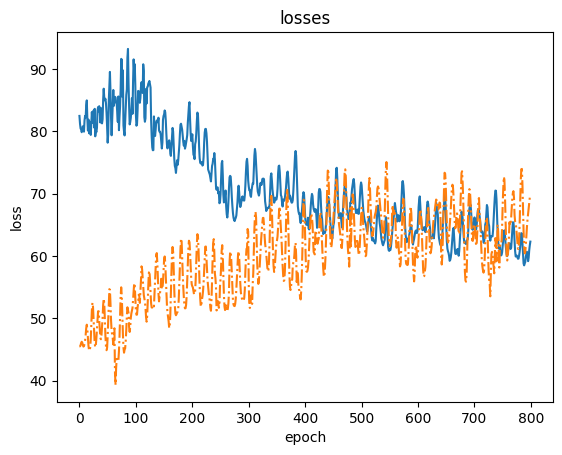

In [8]:
plt.plot(losses)
plt.plot(losses_val, '-.')

plt.xlabel("epoch")
plt.ylabel("loss")
plt.title('losses')
plt.show()




# with torch.no_grad():
#     correct = 0
#     total = 0
#     for i, (labels, images) in enumerate(processed_data):
#         images = images.reshape((1, 4, 60, 80))
#         images = images.to(device)
#         labels = torch.tensor(labels, dtype=torch.float32)
#         labels = labels.to(device)
#         outputs = model(images)
#         print([labels[0], labels[1]], [outputs[0], outputs[1]])




In [15]:
from osrparse import Replay, parse_replay_data

In [22]:
map = "map1"
video = ImageDataset(processed_data, processed_labels)

video_loader = DataLoader(video, batch_size=1)

video_output = cv2.VideoWriter("osu_dl_video.avi",cv2.VideoWriter_fourcc(*'DIVX'),30, (800, 600))

replay = Replay.from_path("C:\\Users\\Yile0\\Downloads\\"+ map + ".osr")

model = ConvNeuralNet(2)
model.cuda(device)
epoch_start = 0


epoch_start = 0
# added code that allows it to train again from a checkpoint
# it lets me train in chunks over time.
checkpoint = torch.load('model_duo.pth')
model.load_state_dict(checkpoint['model_state_dict'])
epoch_start = checkpoint['epoch']
loss = checkpoint['loss']

# FPS of recording
FPS = 60

# toss the first one because it doesn't make any sense
replay = replay.replay_data[2:len(replay.replay_data)-10]

FOLDER_PATH = "C:/Users/Yile0/PycharmProjects/osutime/frames/"+ map + "/"

model.eval()

timer = 0

for i, (images, labels) in tqdm(enumerate(video_loader)):
    timer += replay[i].time_delta * 0.6666
    nearest_frame = int(timer//16.666666)
    frame = cv2.imread(FOLDER_PATH + str(nearest_frame) + ".png")
    frame = cv2.resize(frame,(800,600))
    images = images.to(device)
    # Move tensors to the configured device
    # images already got loaded on
    # images = images.to(device)
    output = (model(images)[0] * 1.5625).detach().cpu().numpy()
    
    frame = cv2.circle(frame,(int(output[0]), int(output[1])),20, (0,0,255), -1) #draw circle
    frame = cv2.circle(frame,(int(data['x'].iloc[i]*1.5625),int(data['y'].iloc[i]*1.5625)),20, (0,255,0), -1) #draw circle
    
    video_output.write(frame)
    
video_output.release()
cv2.destroyAllWindows()
    
    

C:\Users\Yile0\AppData\Local\Temp\ipykernel_45336\908050225.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('model_duo.pth')
8930it [01:19, 112.

In [13]:
import cv2
cap = cv2.VideoCapture('osu_dl_video.mp4')

while(cap.isOpened()):
    ret, frame = cap.read()
 
    cv2.imshow('frame',ret)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
